In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import pandas as pd
import cython
from scipy.optimize import curve_fit

masses = {
    "P" : 0.93827203,
    "PIP" : 0.13957018,
    "KAON" : 0.493677
}

WARNING  Overriding pythran description with argspec information for: numpy.concatenate
WARNING  Overriding pythran description with argspec information for: numpy.empty_like


In [2]:
%%cython --annotate
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt
cimport cython

cdef float c_special_units = 29.9792458
cdef float MASS_PIP = 0.13957018

@np.vectorize
@cython.nonecheck(False)
@cython.cdivision(True)
def vertex_time(float sc_t, float sc_r, float r_beta):
    return 


@cython.nonecheck(False)
@cython.cdivision(True)
cdef float dt_calc(float mass, float vertex, float momentum, float sc_t, float sc_r):
    if momentum == 0 or sc_t == 0 or sc_r == 0:
        return 100
    cdef float r_beta = 1.0 / sqrt(1.0 + (mass / momentum) * (mass / momentum))
    cdef float vt = sc_t - sc_r / (r_beta * c_special_units)
    
    return vertex - vt

@np.vectorize
def calc_dt(float mass, float vertex, float momentum, float sc_t, float sc_r):
    return dt_calc(mass, vertex, momentum, sc_t, sc_r)


In [3]:
data = pd.read_csv("/Users/tylern/Desktop/show/deltaT.dat")
data = data.replace(0, np.nan)
data = data.dropna()
print(len(data))

2824325


In [4]:
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r
0,3.0,0.430126,-0.442297,1.0,55.5219,2.308410,73.5635,499.756
2,4.0,0.960026,-1.965630,-1.0,48.7890,0.787715,66.5264,537.264
4,1.0,0.522632,1.641330,1.0,65.3677,0.804731,92.1960,523.770
7,5.0,0.502915,-2.636870,1.0,66.1954,0.358935,84.5807,500.577
9,6.0,0.440094,2.661290,1.0,60.4883,1.395380,81.1383,509.147


In [5]:
%time
for mass in masses:
    data[f"dt_{mass}"] = calc_dt(masses[mass], data.vertex, data.p, data.sc_t, data.sc_r)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [6]:
data = data.dropna()
data = data[(data.theta < 1.0) & (np.abs(data.dt_PIP) < 1.2)]
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r,dt_P,dt_PIP,dt_KAON
2,4.0,0.960026,-1.96563,-1.0,48.7890,0.787715,66.5264,537.264,10.134499,0.462936,3.412491
7,5.0,0.502915,-2.63687,1.0,66.1954,0.358935,84.5807,500.577,28.347359,-0.469940,10.008751
11,1.0,0.966624,1.77200,1.0,50.9726,0.660273,67.0019,471.882,11.321434,0.058804,3.624229
12,2.0,0.217975,0.50507,1.0,63.5326,1.009190,81.3284,521.418,5.952591,-0.237621,1.566338
34,1.0,0.428161,1.39754,1.0,55.9862,0.638606,74.4574,531.774,13.054176,-0.314430,3.949135


In [7]:
def two_gauss(x, *p):
    A, mu, sigma, A2, mu2, sigma2 = p
    g1 = A*np.exp(-(x-mu)**2/(2.*sigma**2))
    g2 = A2*np.exp(-(x-mu2)**2/(2.*sigma2**2))
    return g1+g2

def gauss(x, *p):
    A, mu, sigma = p
    g1 = A*np.exp(-(x-mu)**2/(2.*sigma**2))
    return g1

def poly(x, a, b, c, d):
    y = a*x**3 + b*x**2 + c*x + d
    return y


def get_slices(data, sec=1, charge=1, min_p = 0.0, max_p = 4.0, num_steps = 120, particle="dt_PIP", show=False):
    slices = []
    mom = np.linspace(min_p, max_p, num=num_steps, endpoint=True)
    d = data[(data.charge == charge) & (data.sec == sec)]
    for m in range(len(mom[:-1])):
        _min = mom[m]
        _max = mom[m+1]
        slic = d[(d.p > _min) & (d.p <= _max)]
        if len(slic) > 100:
            if show:
                ydata, xdata, _ = plt.hist(slic[particle], bins=200, range=(-5,5))
            else:
                ydata, xdata = np.histogram(slic[particle], bins=200, range=(-5,5))
                
            xdata = (xdata[1:] + xdata[:-1])/2.0
            try:
                p0 = [1.0, 0.0, 0.01]
                param_bounds=((0,    -0.5,  0),
                              (np.inf,0.5,  1.0)
                             )
                popt, pcov = curve_fit(gauss, xdata, ydata, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)

                if popt[2] > 0.4:
                    x2 = xdata[xdata>-0.8]
                    y2 = ydata[xdata>-0.8]
                    popt, pcov = curve_fit(gauss, x2, y2, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)
                
                if show:
                    plt.plot(xdata, gauss(xdata, *popt), 'r-',
                        label='fit: A=%5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
                    plt.legend()
                slices.append([(_min+_max)/2.0, popt[1], popt[2]])
            except RuntimeError:
                try:
                    p0 = [1.0, 0.0, 0.01]
                    param_bounds=((0,    -0.5,  0),
                                  (np.inf,0.5,  0.5)
                             )
                    popt, pcov = curve_fit(gauss, xdata, ydata, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)
                    if show:
                        plt.plot(xdata, gauss(xdata, *popt), 'r-',
                             label='fit: A=%5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
                        plt.legend()
                        
                    if popt[2] < 1.0:
                        slices.append([(_min+_max)/2.0, popt[1], popt[2]])
                except RuntimeError:
                    pass
            else:
                pass
            
            if show:
                plt.show()
                
    return np.array(slices).T

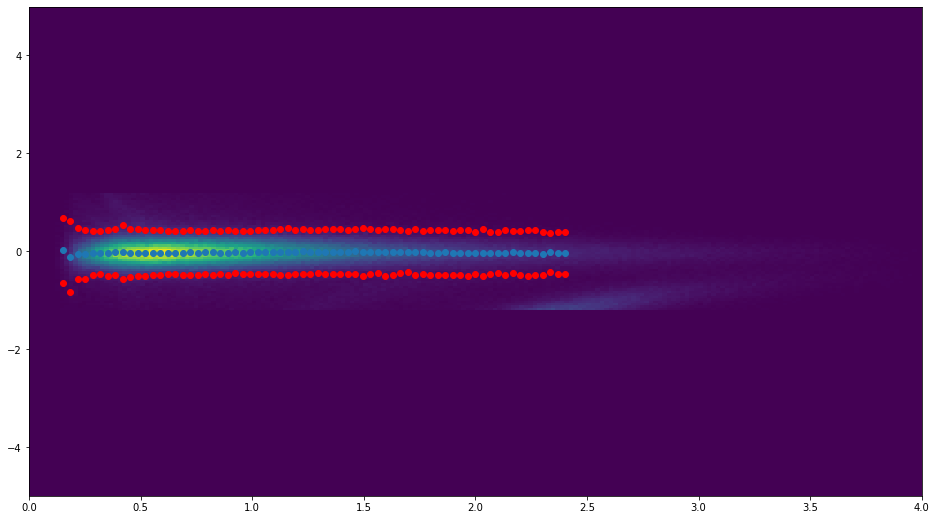

In [8]:
slices = get_slices(data[data.p < 2.4])
slice_p = slices[0]
mu = slices[1]
sigma = slices[2]

fig = plt.figure(figsize=(16,9))
plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 4.0),(-5.0,5.0)))
plt.scatter(slice_p, mu)
plt.scatter(slice_p, mu+2*sigma, c='r')
plt.scatter(slice_p, mu-2*sigma, c='r')
plt.show()

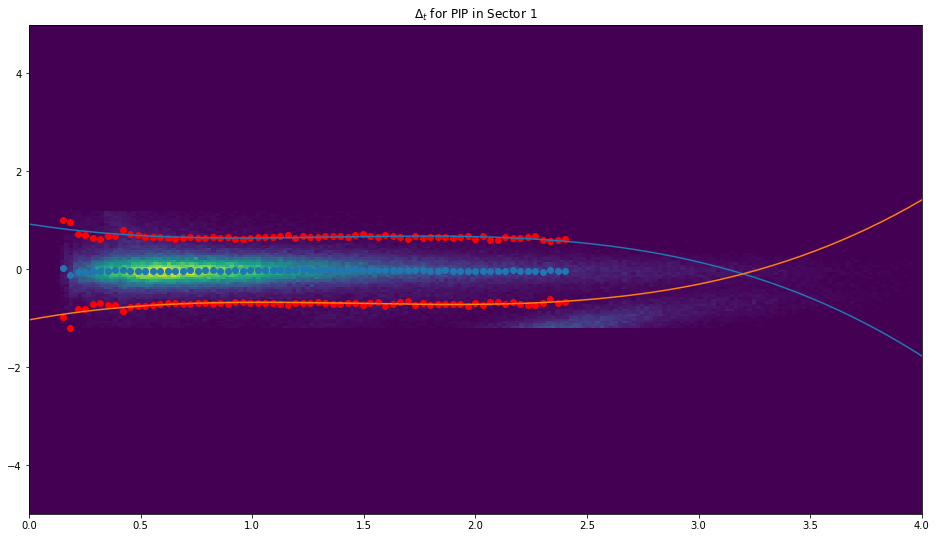

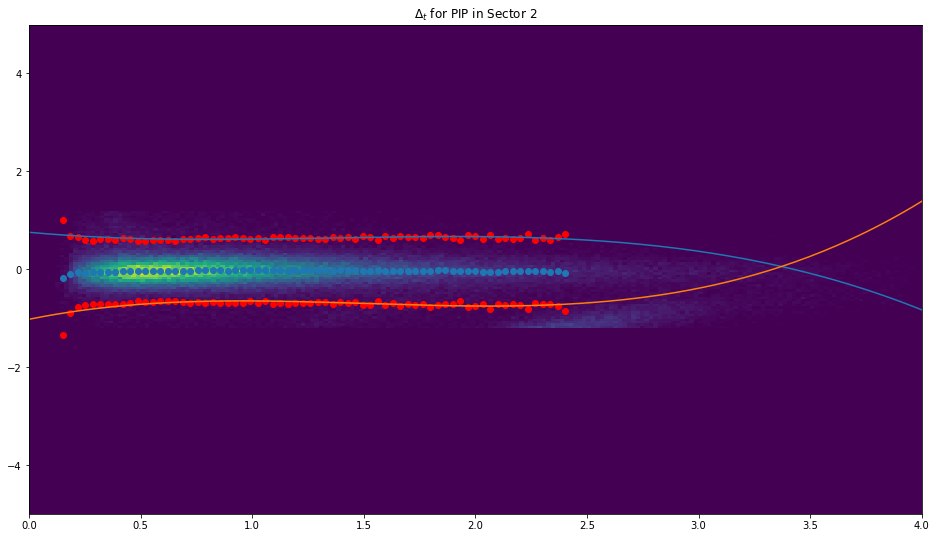

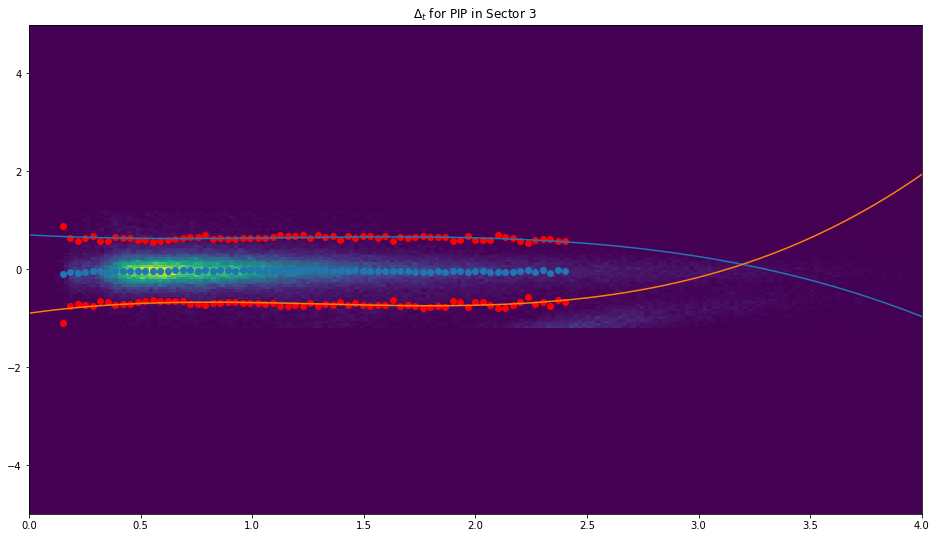

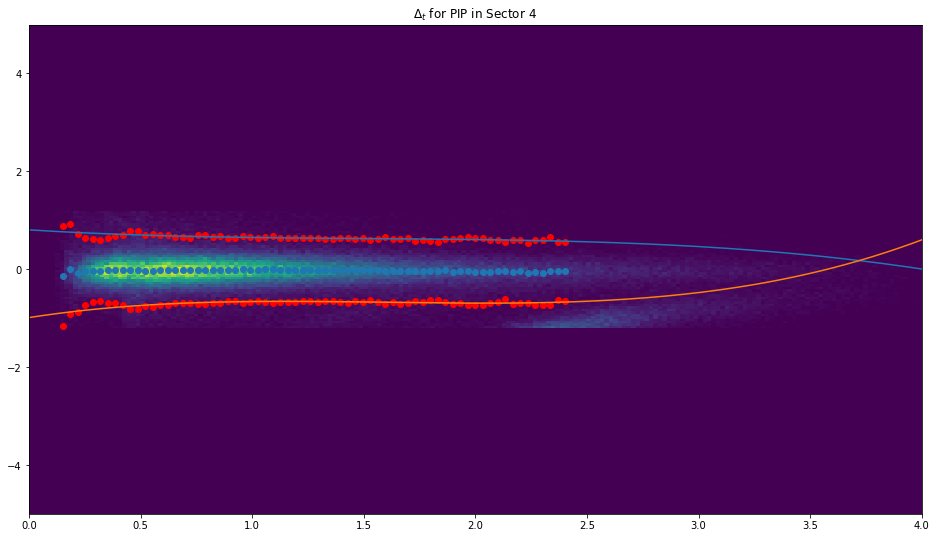

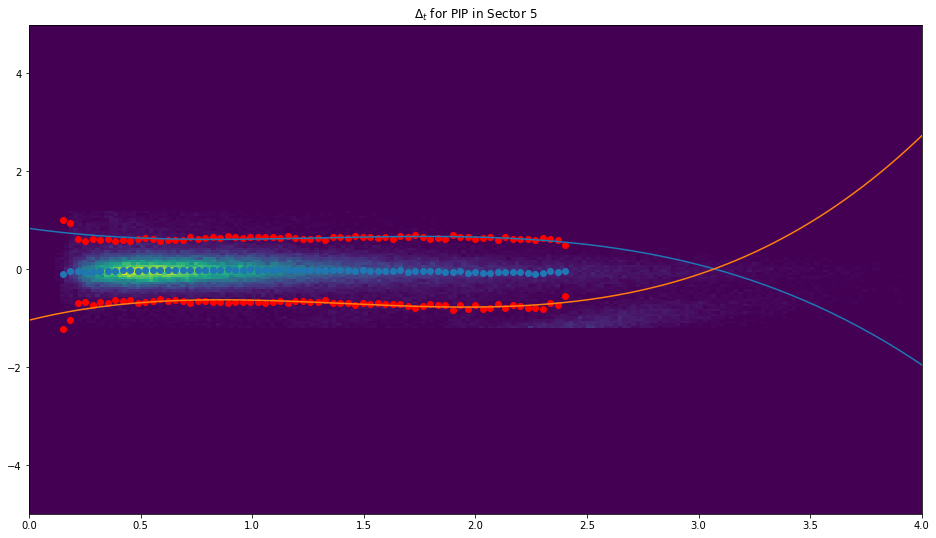

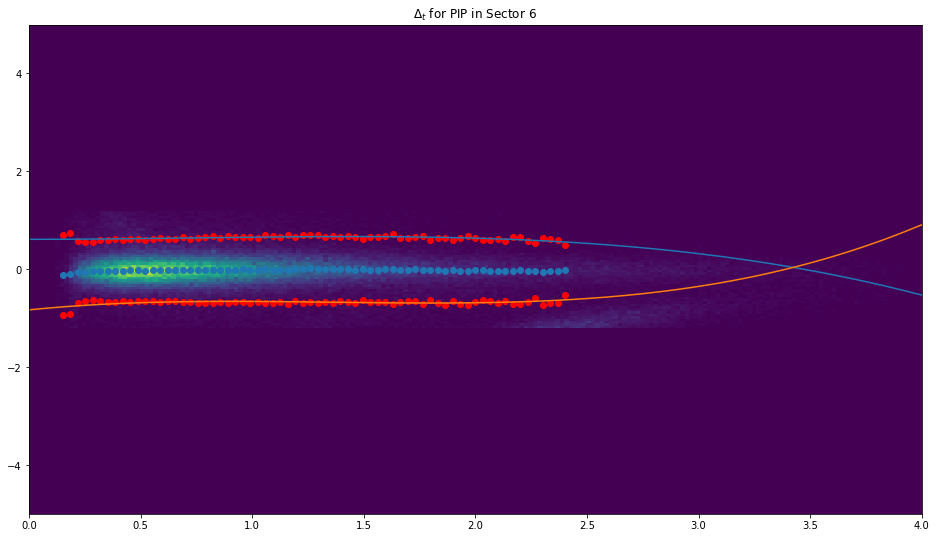

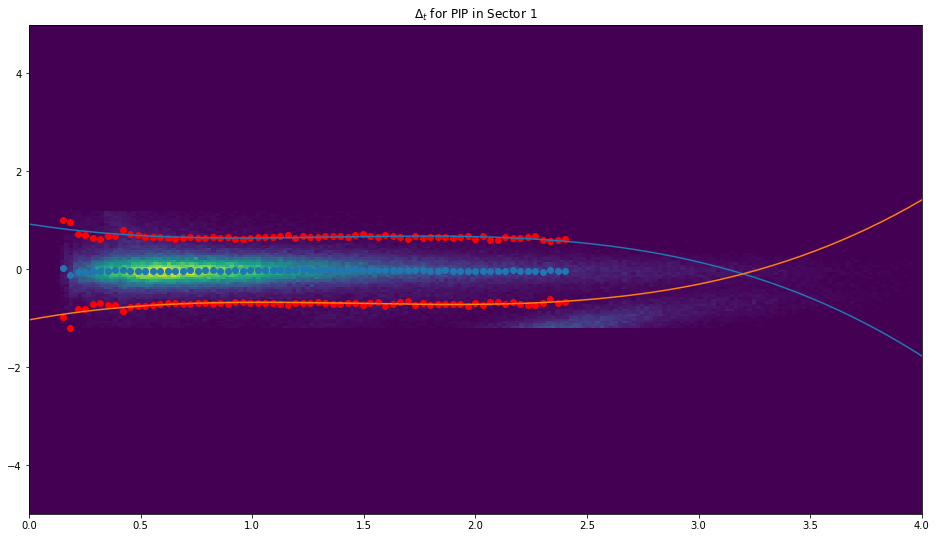

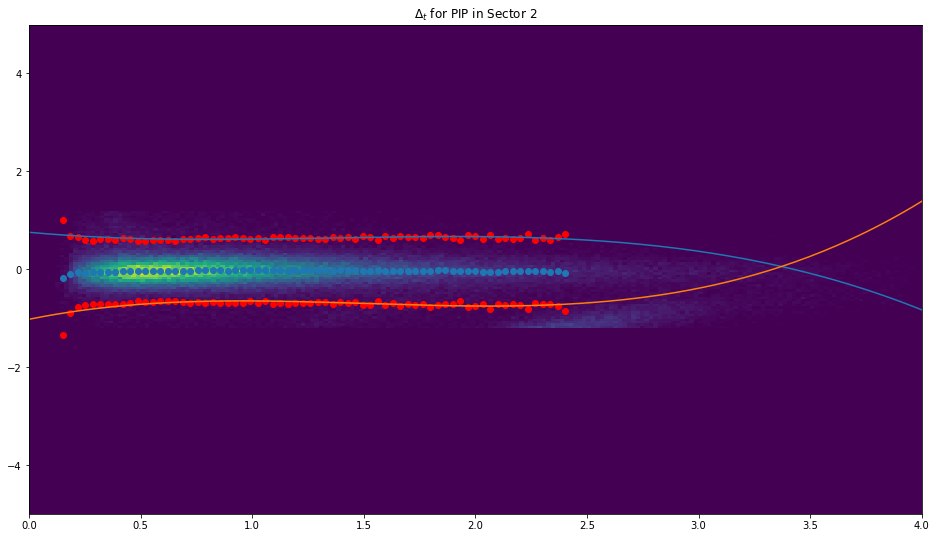

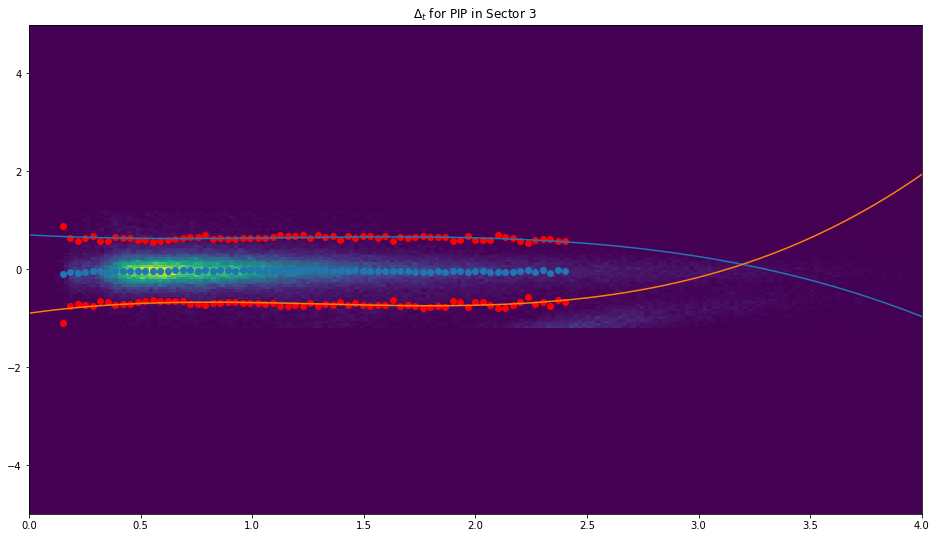

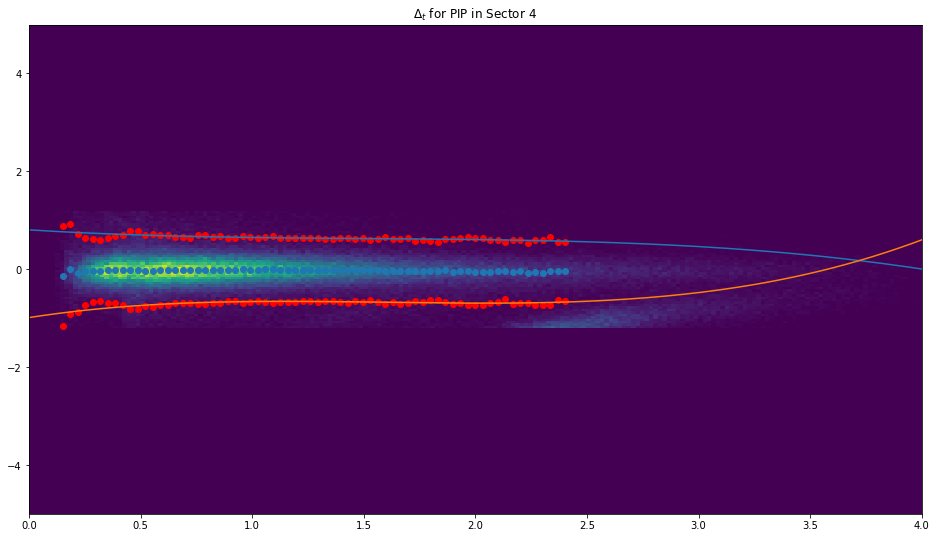

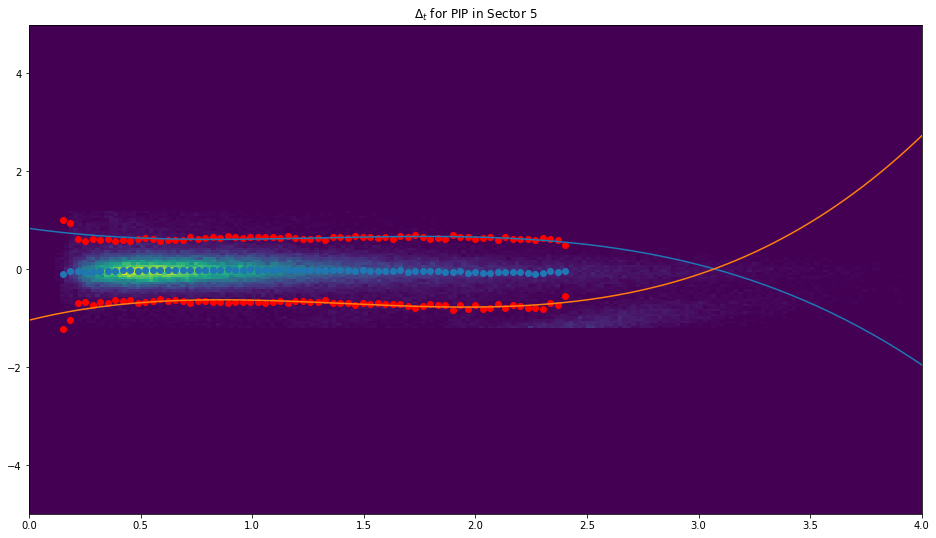

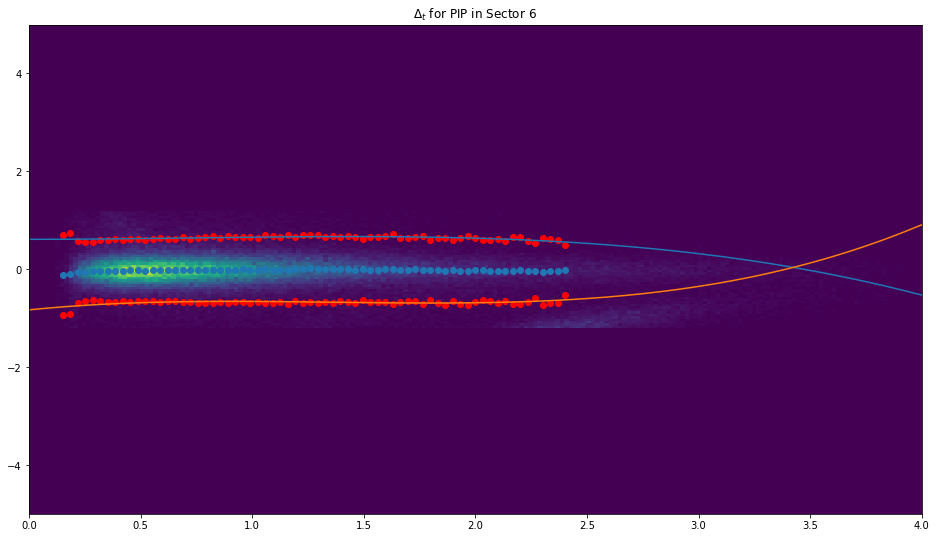

In [9]:
for part in ["dt_PIP","dt_PIP"]:
    for i in range(1,7):
        n_sigma = 3
        slices = get_slices(data[data.p < 2.4], sec=i, particle=part)
        slice_p = slices[0][slices[2] > 0.1]
        mu = slices[1][slices[2] > 0.1]
        sigma = slices[2][slices[2] > 0.1]

        fig = plt.figure(figsize=(16,9))
        plt.title(f"$\Delta_t$ for {part[3:]} in Sector {i}")
        plt.hist2d(data[data.sec == i].p, data[data.sec == i][part], bins=200, range=((0, 4.0),(-5.0,5.0)))
        plt.scatter(slice_p, mu)
        plt.scatter(slice_p, mu+n_sigma*sigma, c='r')
        plt.scatter(slice_p, mu-n_sigma*sigma, c='r')
        popt, pcov = curve_fit(poly, slice_p, mu+n_sigma*sigma)
        xdata = np.linspace(0,4,200)
        plt.plot(xdata, poly(xdata, *popt))

        popt, pcov = curve_fit(poly, slice_p, mu-n_sigma*sigma)
        xdata = np.linspace(0,4,200)
        plt.plot(xdata, poly(xdata, *popt))
        plt.show()

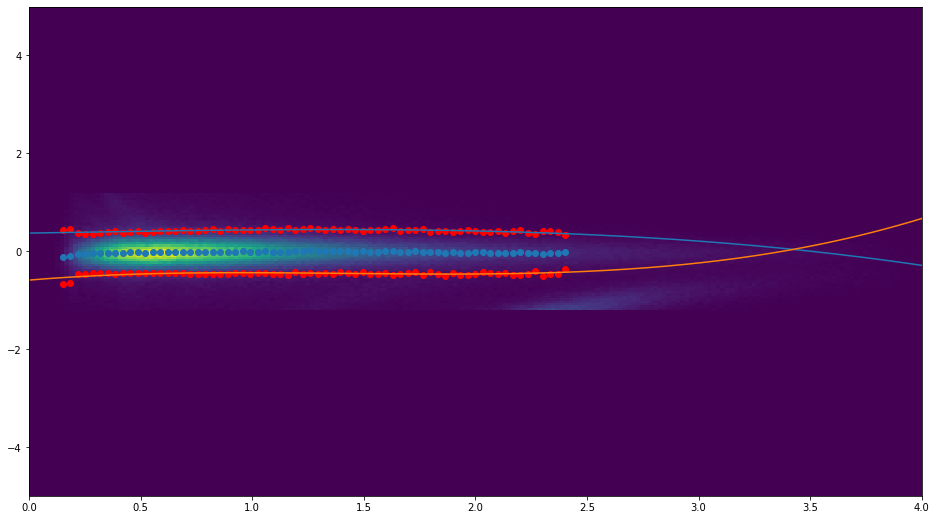

In [10]:
slice_p = slices[0]
mu = slices[1]
sigma = slices[2]

fig = plt.figure(figsize=(16,9))
plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 4.0),(-5.0,5.0)))
plt.scatter(slice_p, mu)
plt.scatter(slice_p, mu+2*sigma, c='r')
plt.scatter(slice_p, mu-2*sigma, c='r')

popt, pcov = curve_fit(poly, slice_p, mu+2*sigma)
xdata = np.linspace(0,4,200)
plt.plot(xdata, poly(xdata, *popt))

popt, pcov = curve_fit(poly, slice_p, mu-2*sigma)
xdata = np.linspace(0,4,200)
plt.plot(xdata, poly(xdata, *popt))

plt.show()

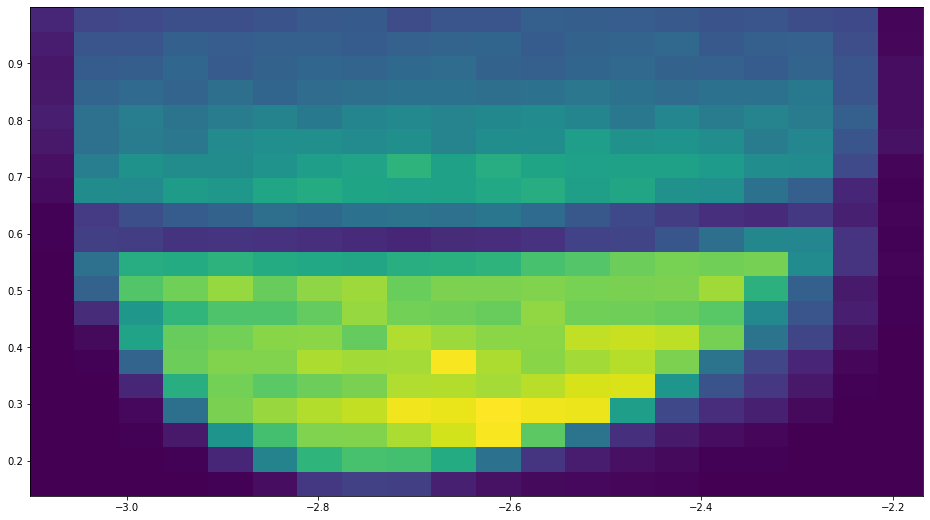

In [11]:
fig = plt.figure(figsize=(16,9))

d = data[(data.theta < 1.0) & (np.abs(data.dt_PIP) < 1.0) & (data.sec == 5)]
plt.hist2d(d.phi, d.theta, bins=20)
plt.show()

In [12]:
data = pd.read_csv("/Users/tylern/Desktop/show/deltaT.dat")

In [13]:
class SliceFitter:
    def __init__(self, 
                 data=None, filename=None,
                 x_name=None, y_name=None, 
                 slice_function=None, edge_function=None, 
                 x_range=(0, 4), y_range=(-5, 5), 
                 x_bins=200, y_bins=200):
        if filename is not None:
            import pandas as pd
            self.filename = filename
            self.data = pd.read_csv(filename)
        elif data is not None:
            self.data = data
        else:
            print("Error: Need to supply data or filename of csv")
            return None
        # remove 0's and NaNs
        self.data = self.data.replace(0, np.nan)
        self.data = self.data.dropna()
        
        self.x_name = x_name
        self.y_name = y_name
        
        self.x_range= x_range
        self.y_range= y_range
        self.x_bins=  x_bins
        self.y_bins=  y_bins
        
    def head(self, *args, **kwargs):
        return self.data.head(*args, **kwargs)
    def plot_2d(self):
        self.points = None
        if self.x_name is None or self.y_name is None:
            print("Error: Set X and Y names")
            return None
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(16,9))
        
        hist, xbins, ybins, quad = plt.hist2d(self.data[self.x_name], self.data[self.y_name], 
                                              bins=(self.x_bins, self.y_bins),
                                              range=(self.x_range, self.y_range))
        if self.points is not None:
            plt.scatter(self.slice_xs, self.mu)
            plt.scatter(self.slice_xs, self.mu+self.n_sigma*self.sigma)
            plt.scatter(self.slice_xs, self.mu-self.n_sigma*self.sigma)
    def fit_slices(self):
        import matplotlib.pyplot as plt
        for sec in range(1,7):
            data = self.data[self.data.sec == sec]
            xs = np.linspace(self.y_range[0],self.y_range[1],num=self.y_bins+1,endpoint=True)
            for x in range(len(xs[:-1])):
                _min = xs[x]
                _max = xs[x+1]
                slic = data[(data[self.x_name] > _min) & (data[self.x_name] <= _max)]
                if len(slic) > 100:
                    fig = plt.figure(figsize=(16,9))
                    plt.hist(slic[self.y_name], bins=self.y_bins)
        
            

        
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


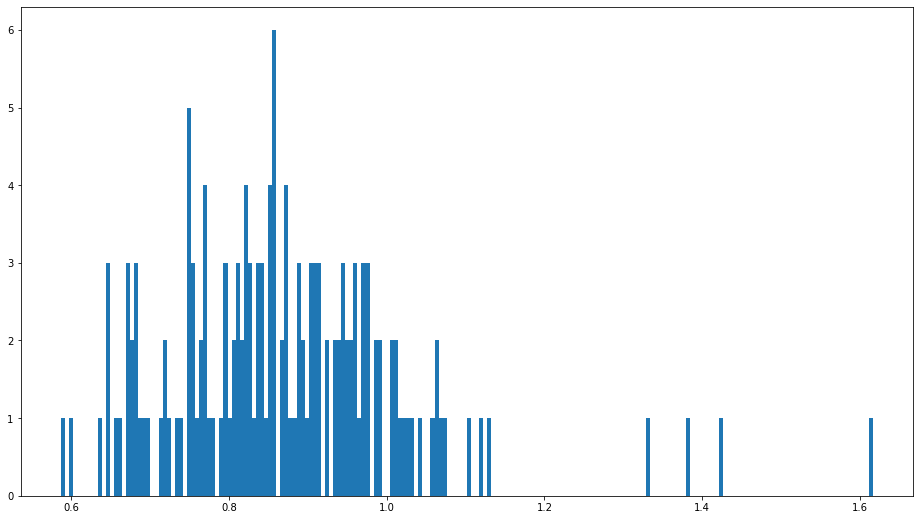

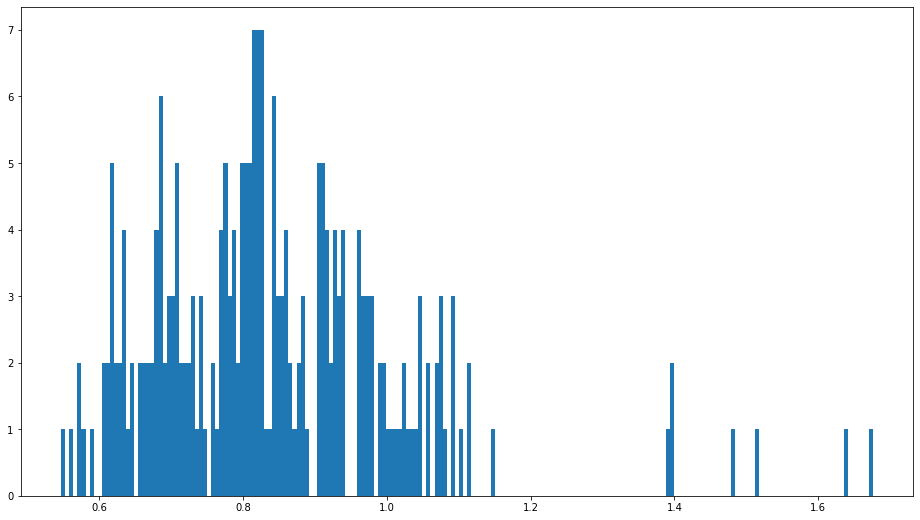

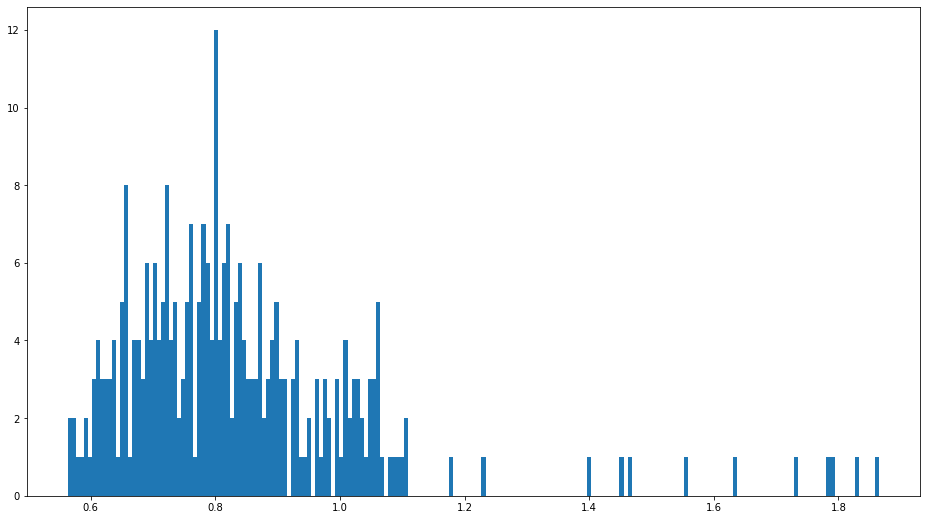

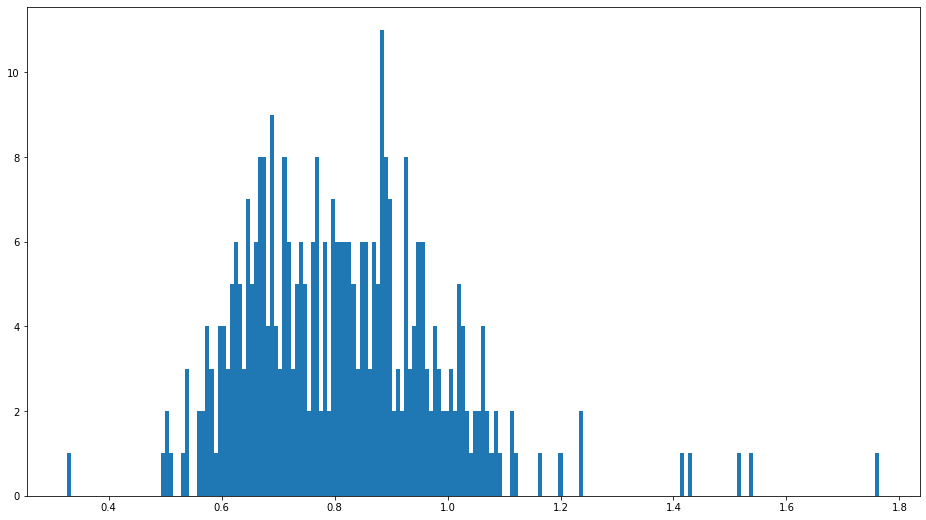

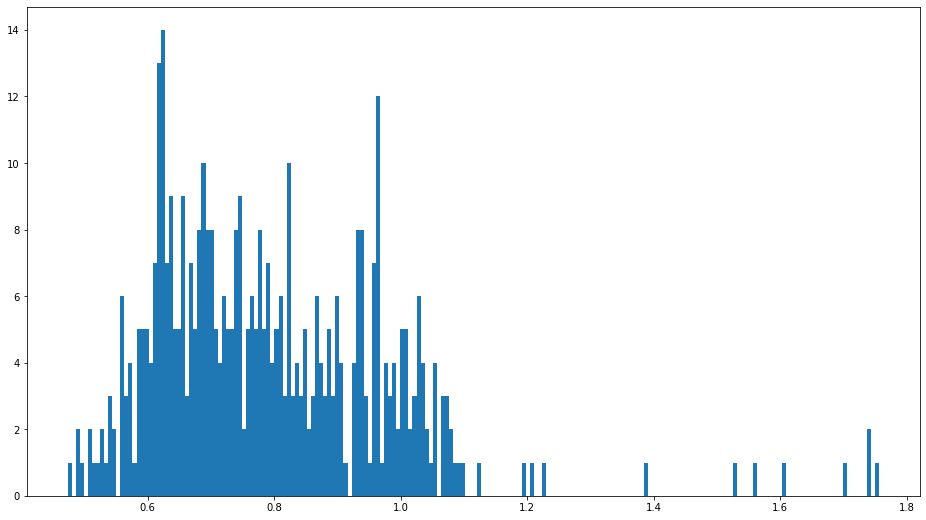

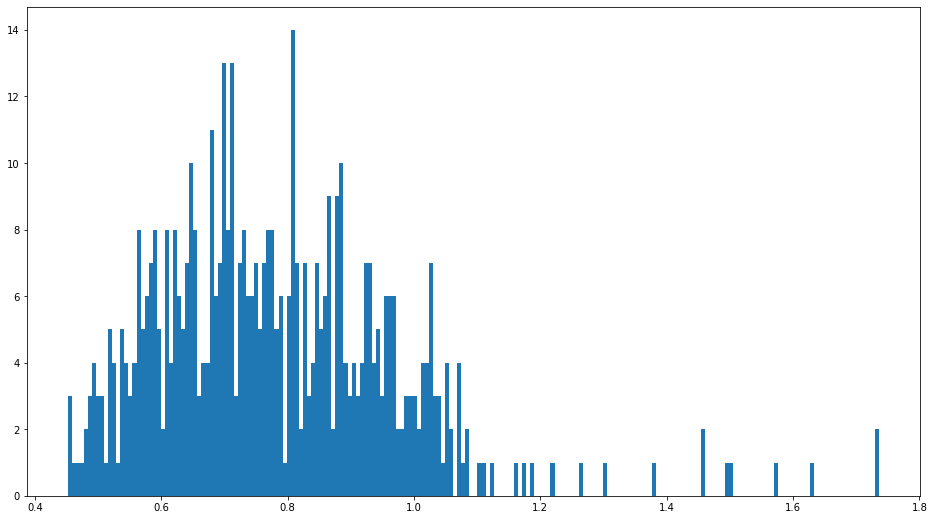

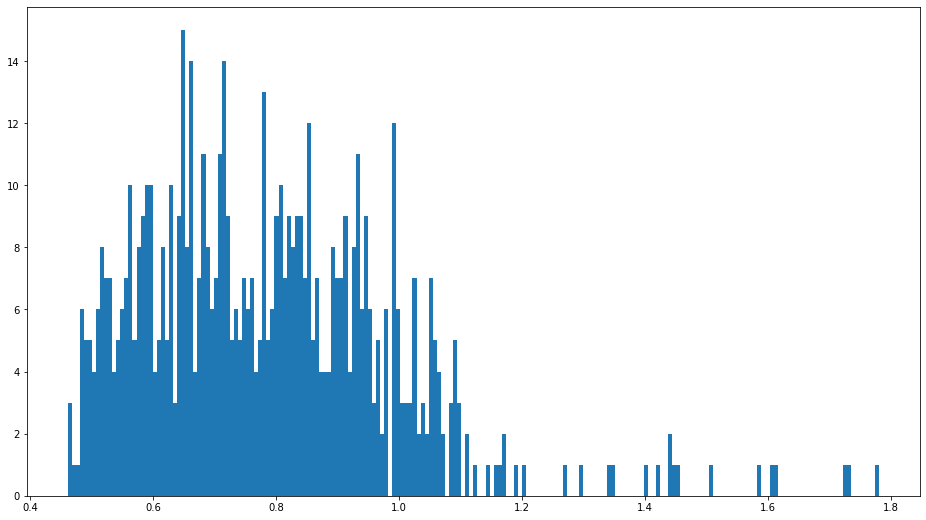

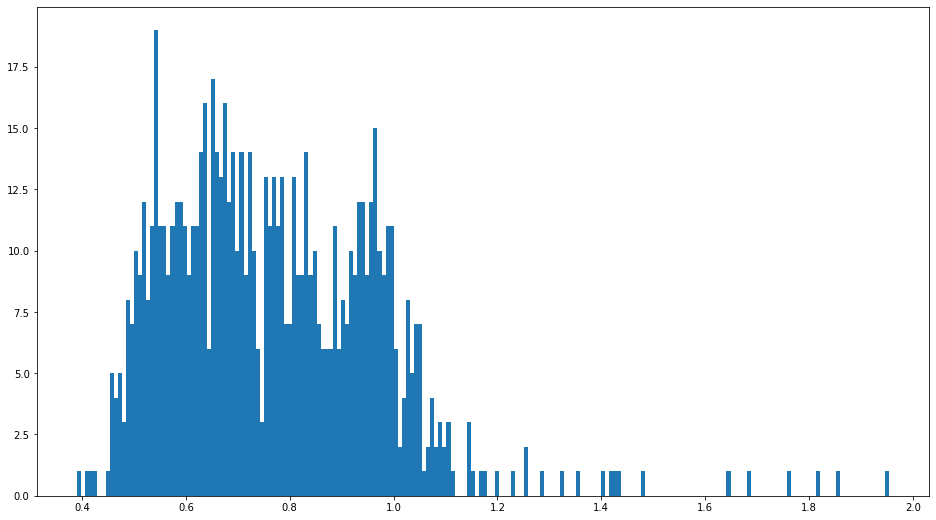

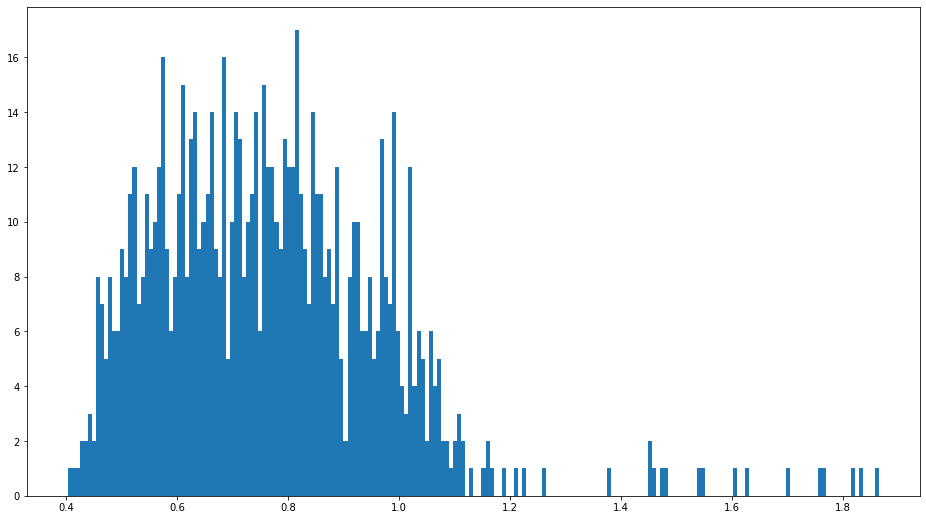

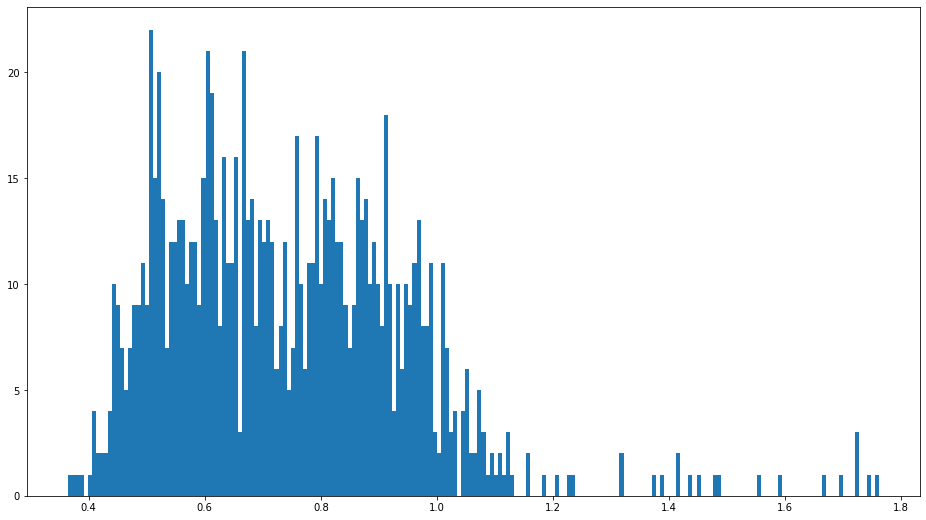

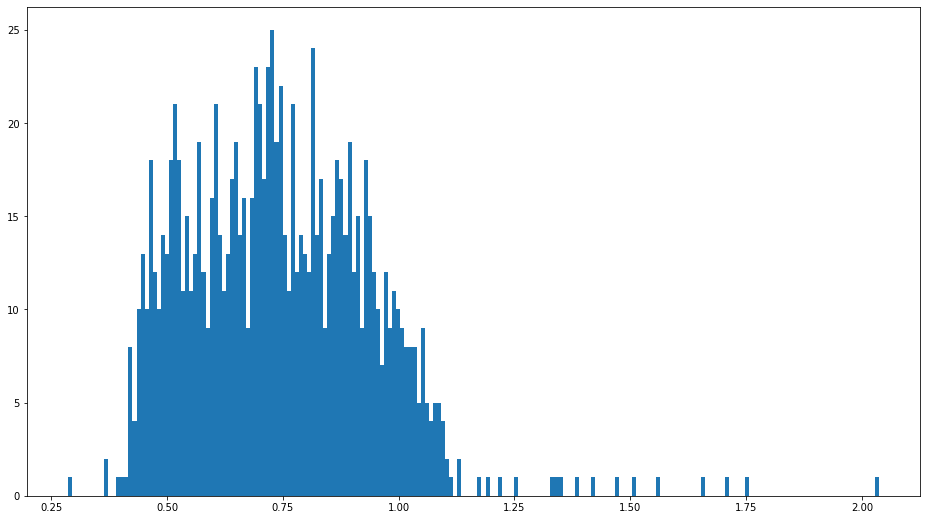

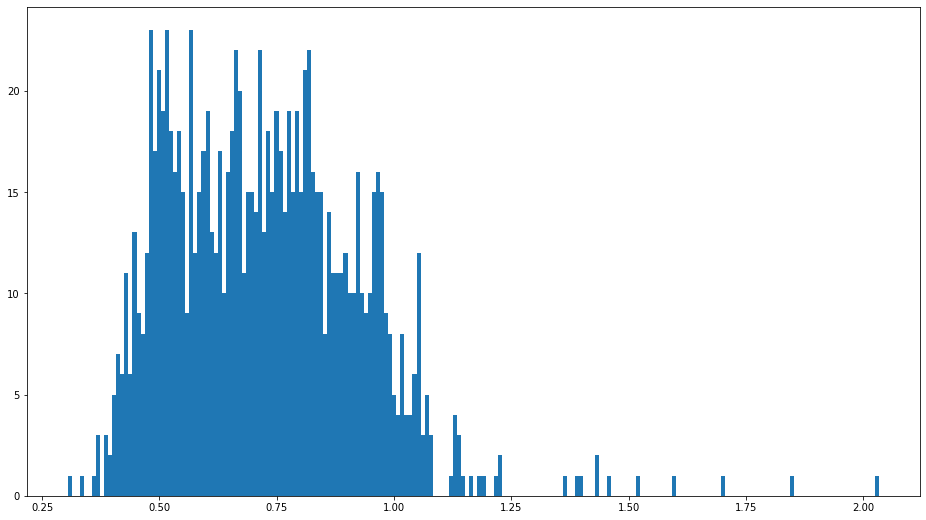

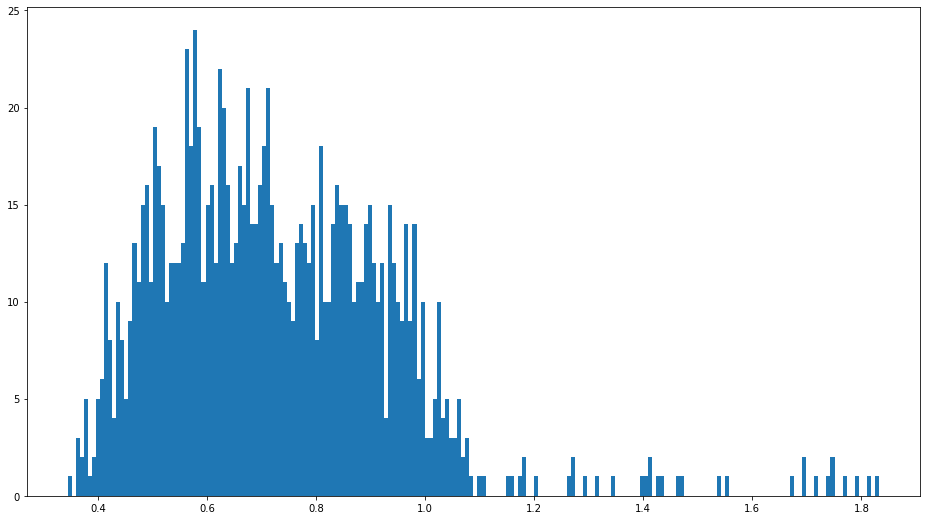

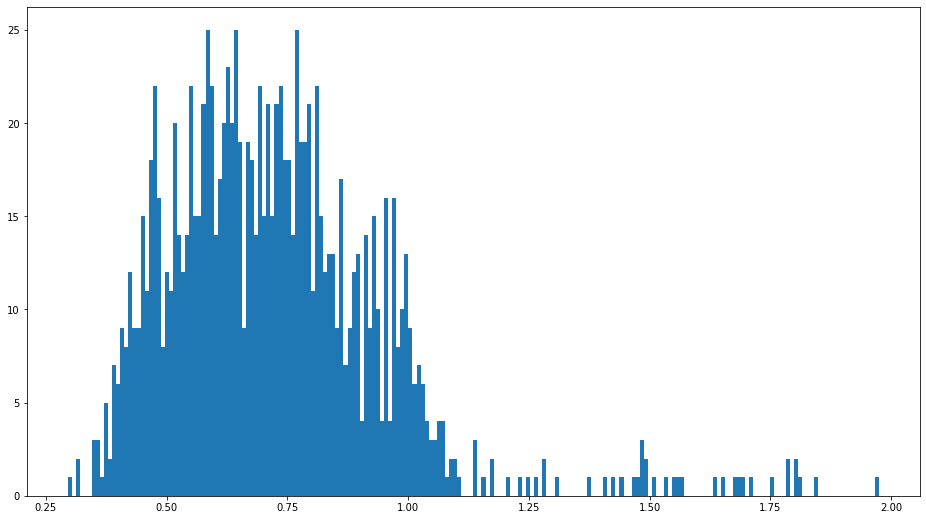

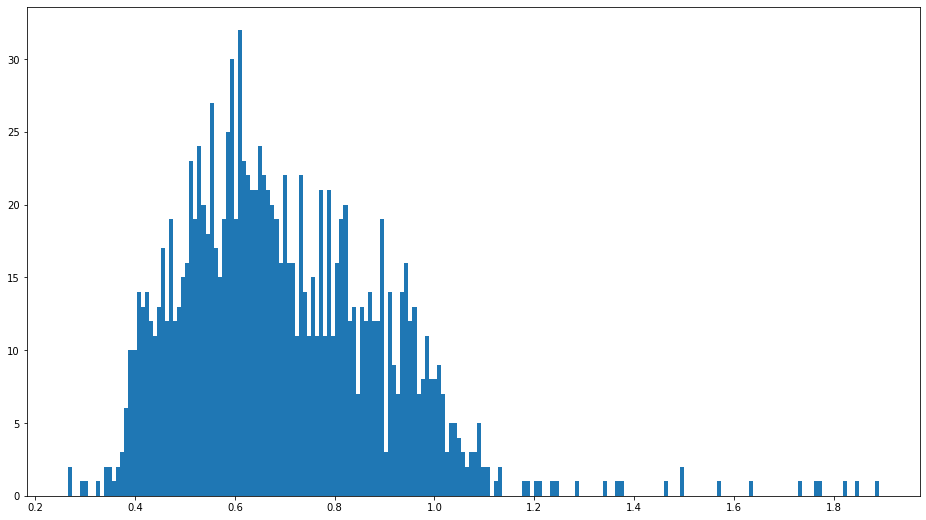

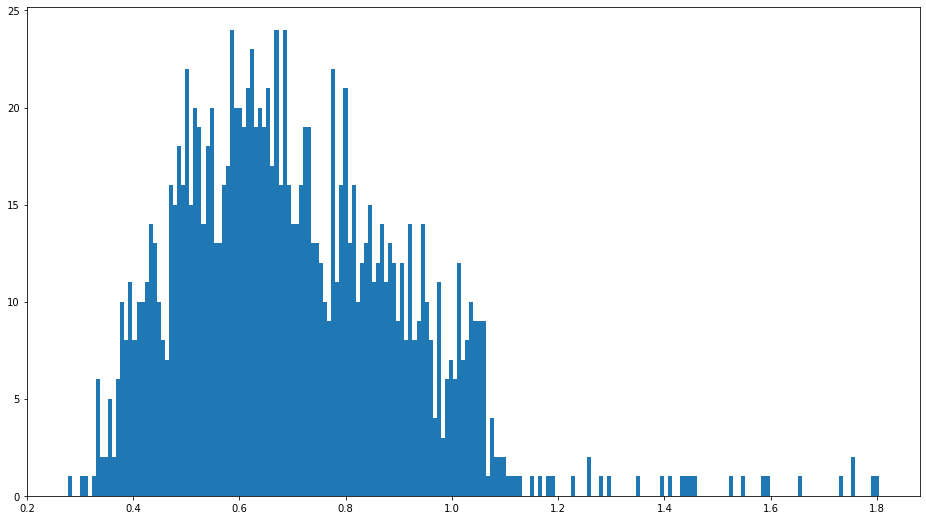

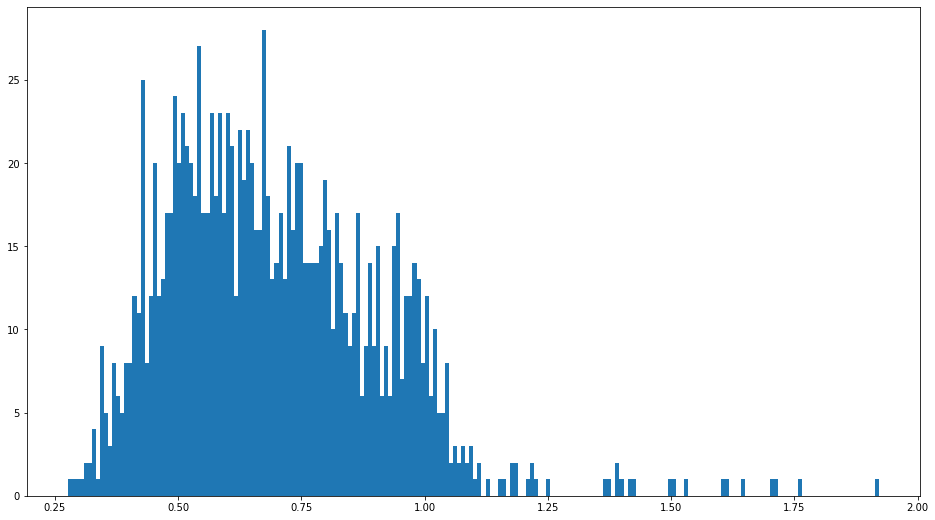

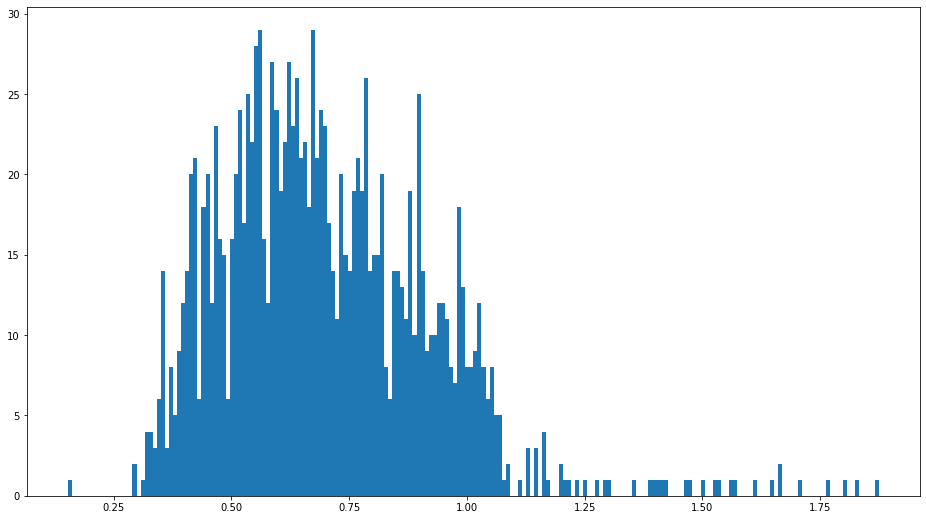

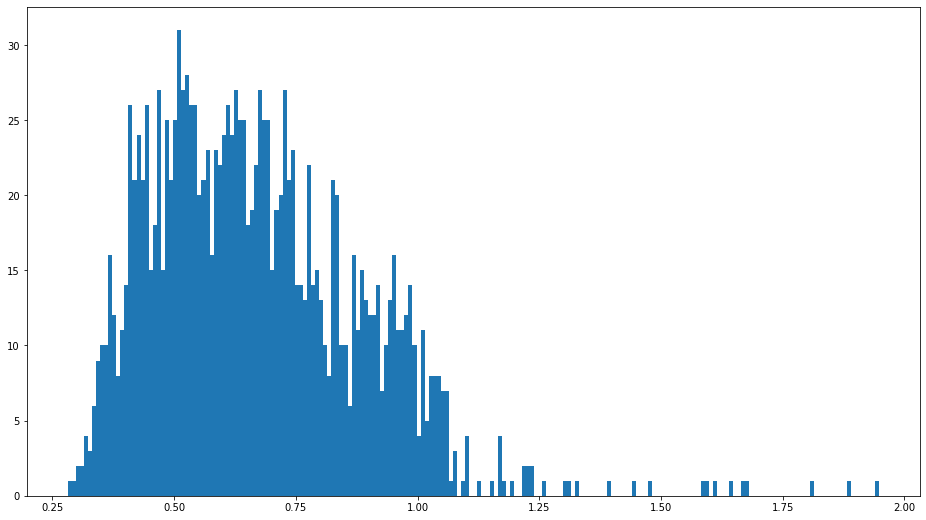

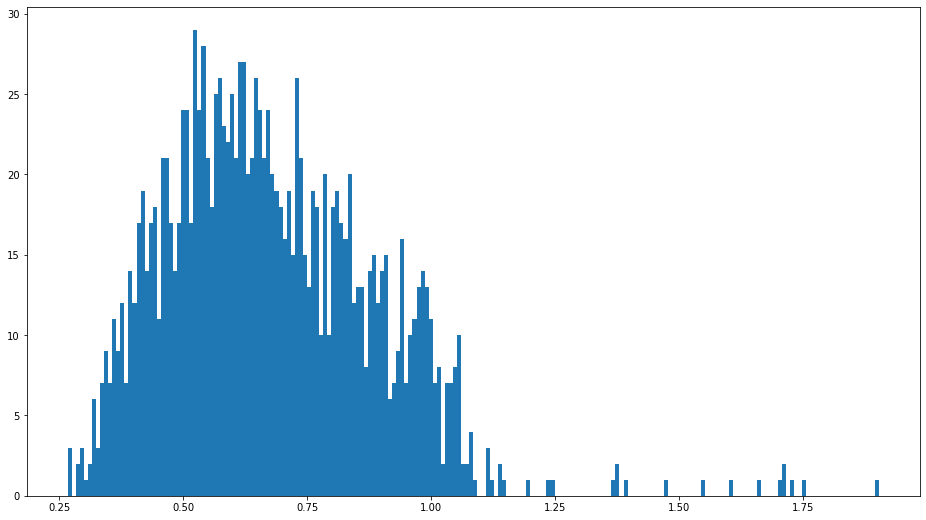

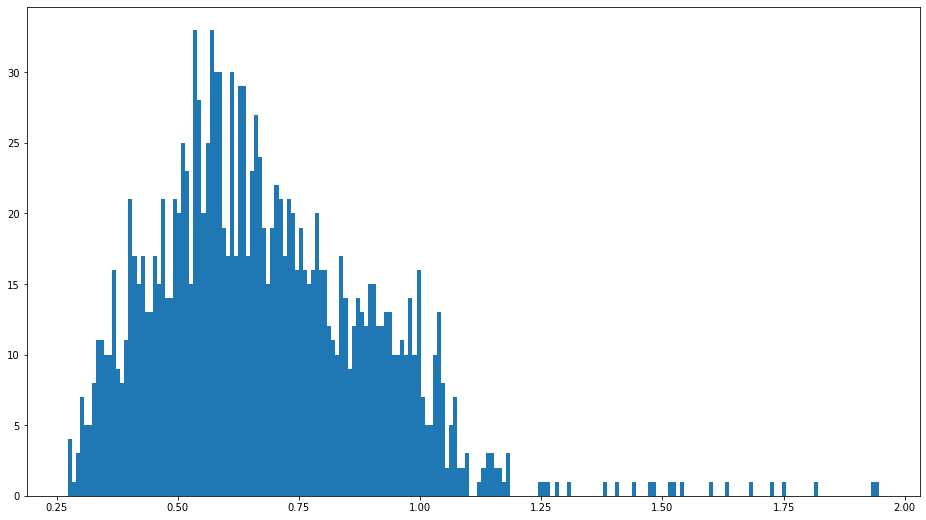

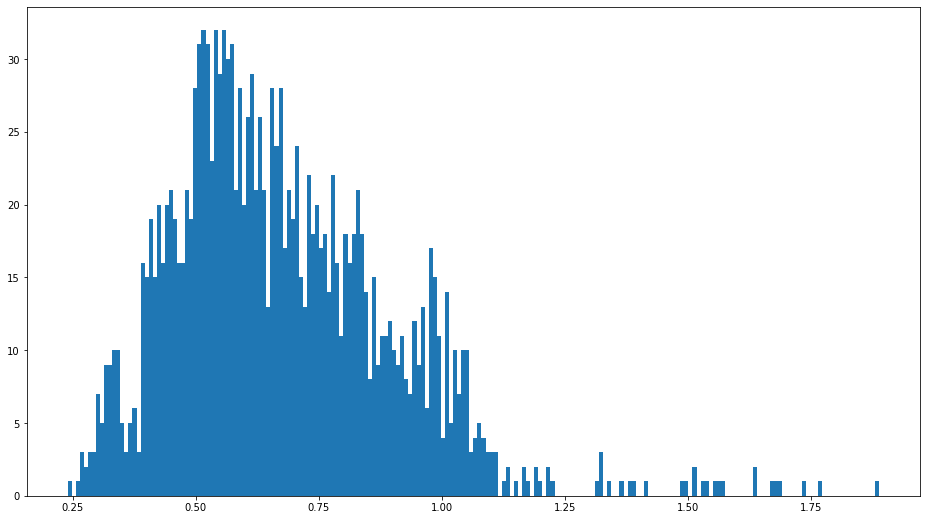

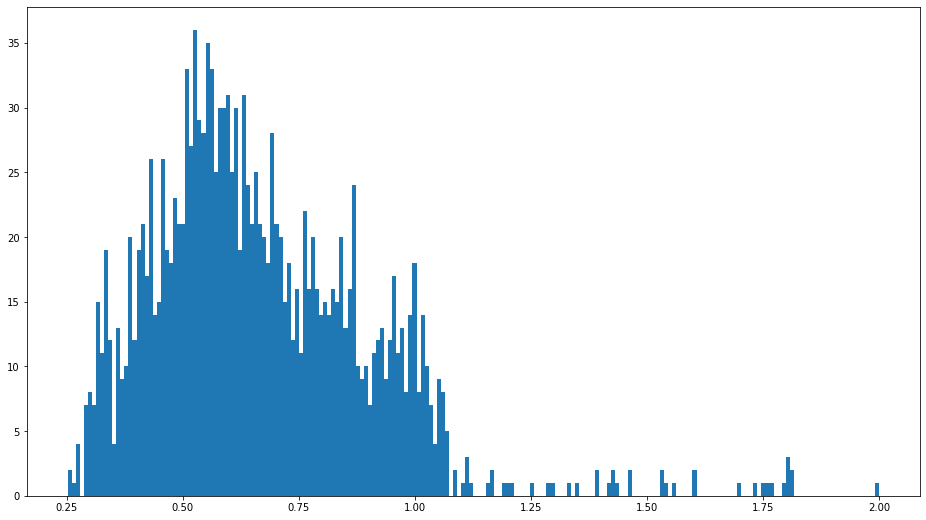

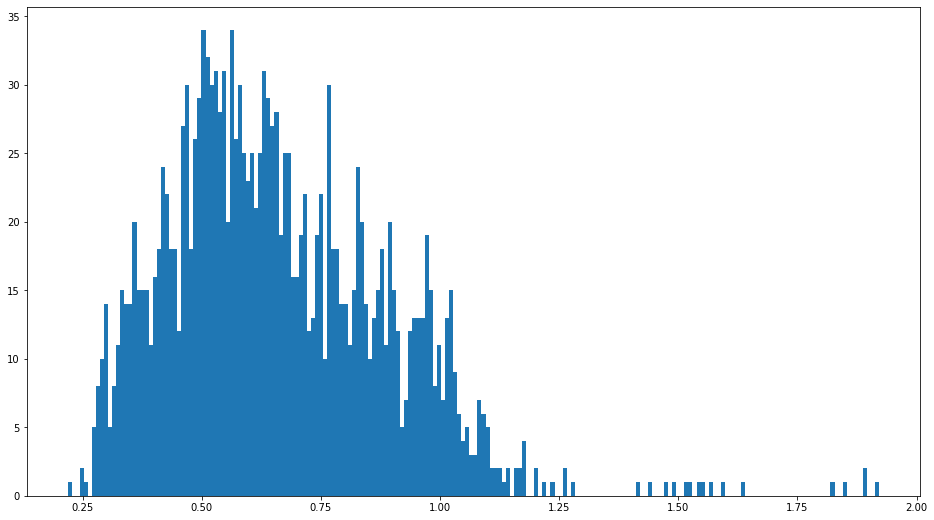

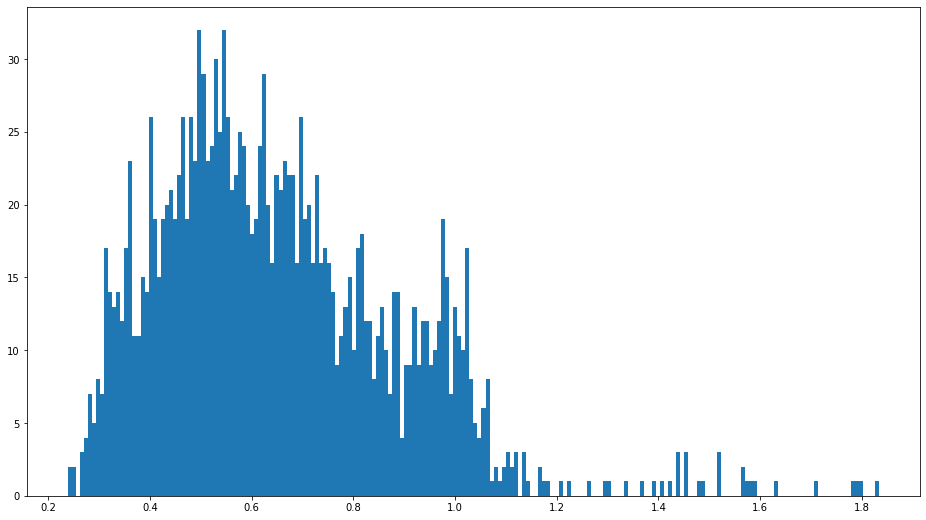

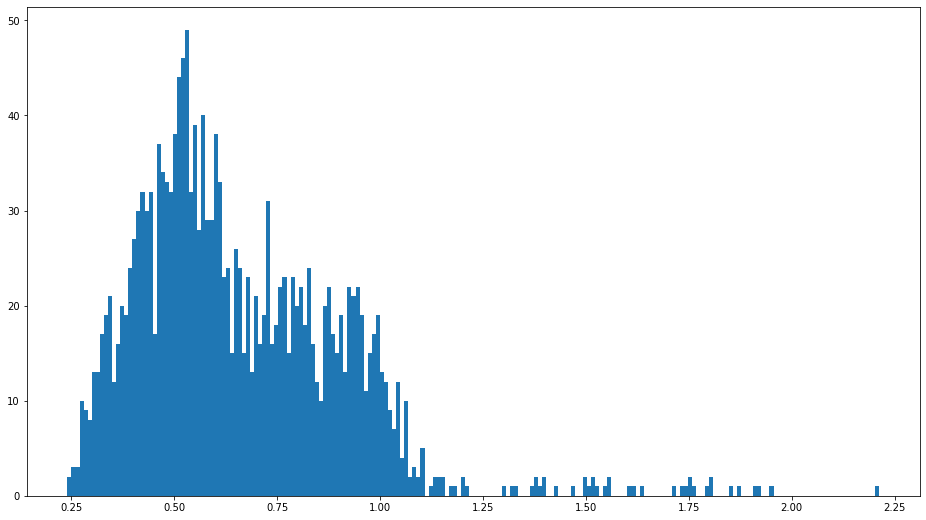

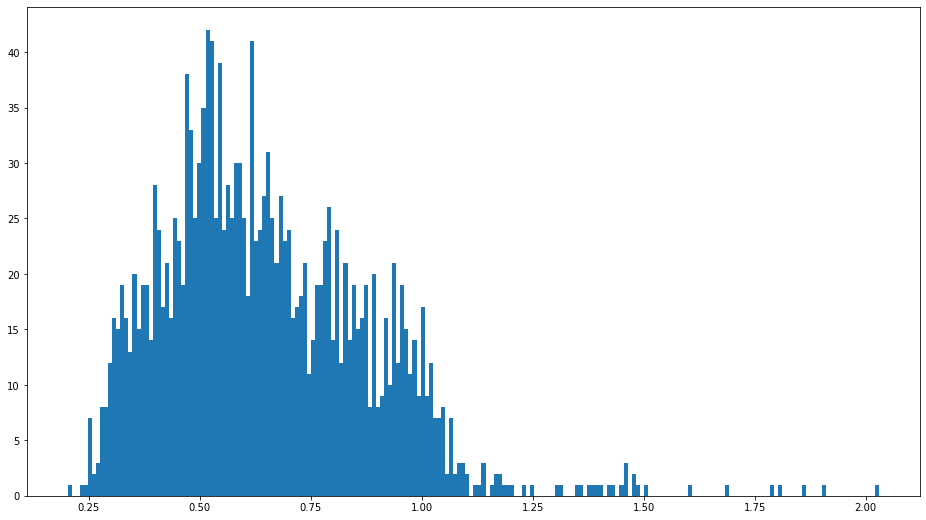

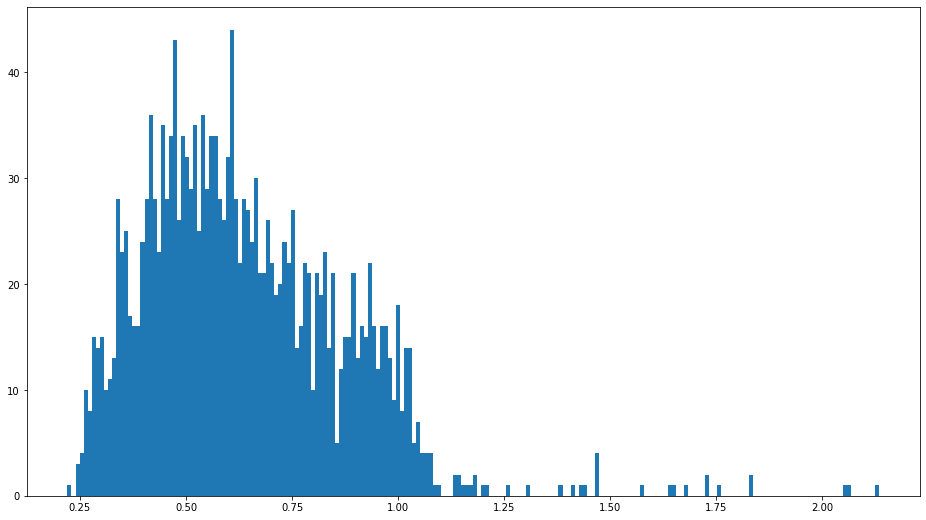

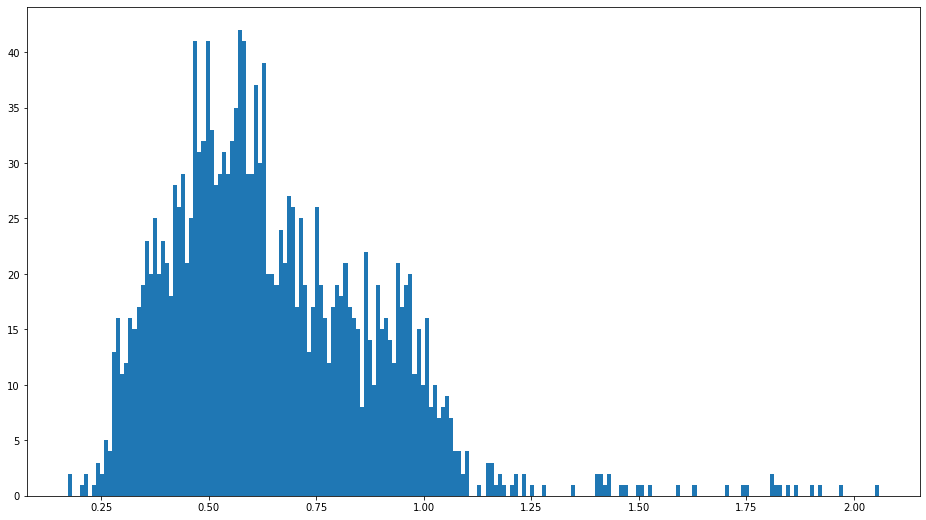

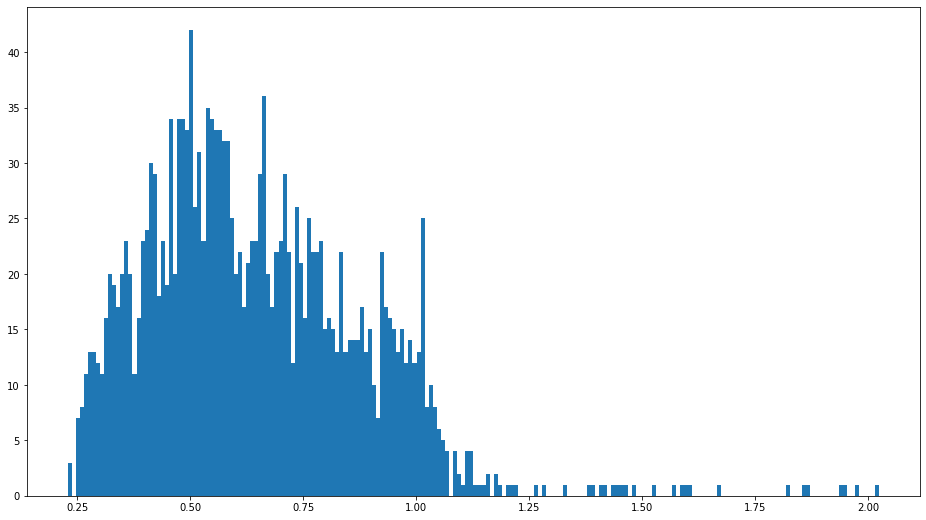

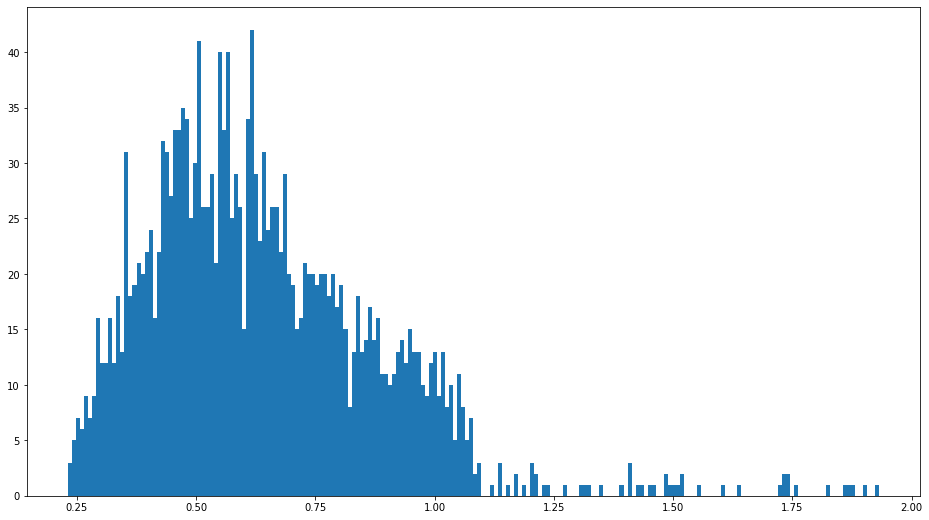

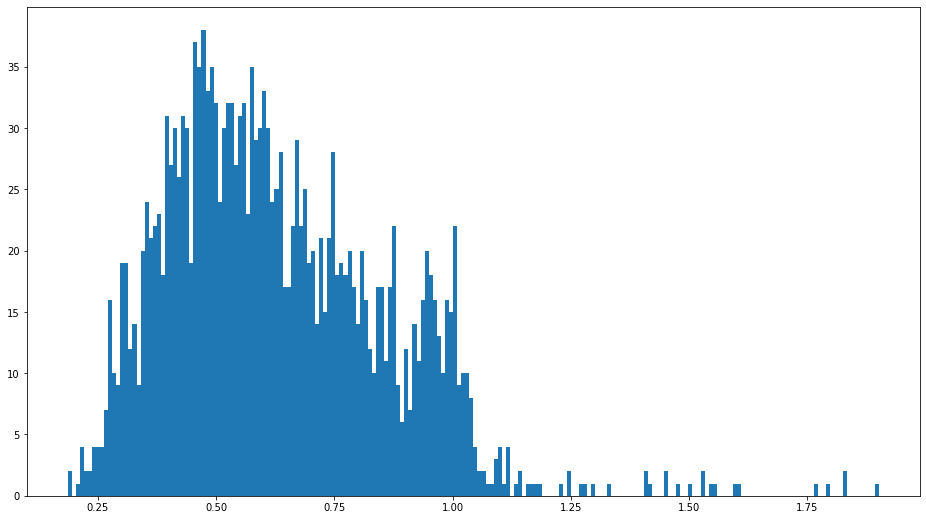

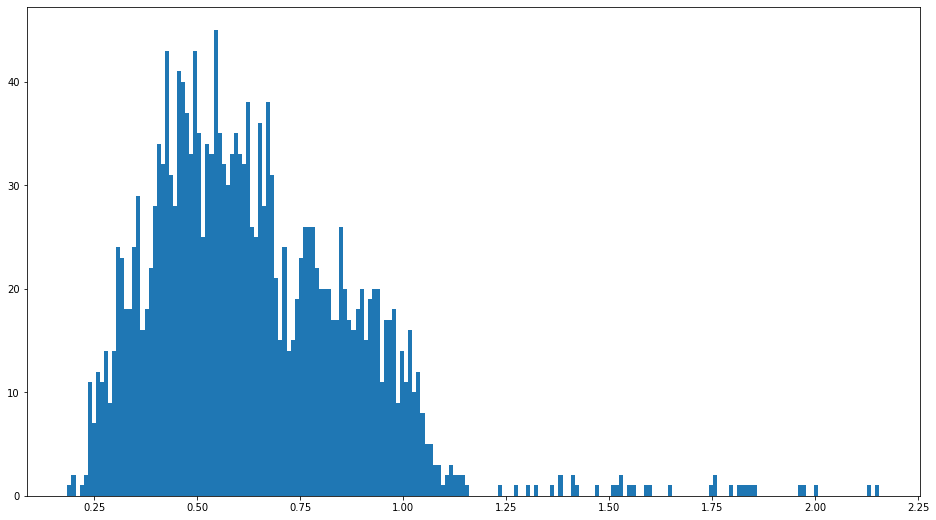

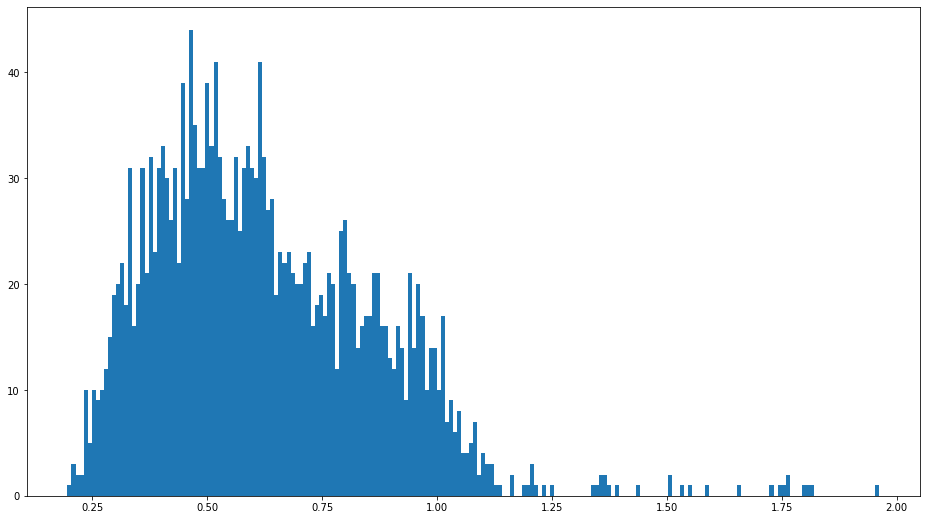

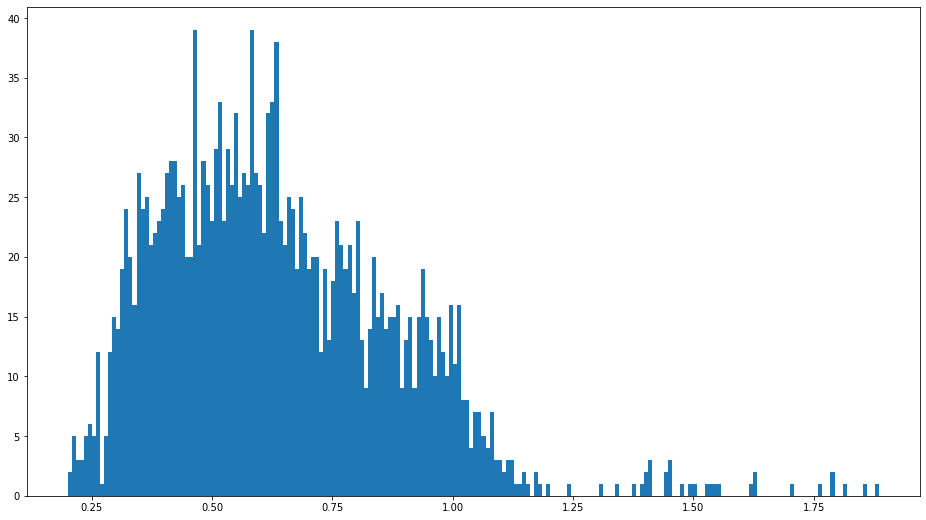

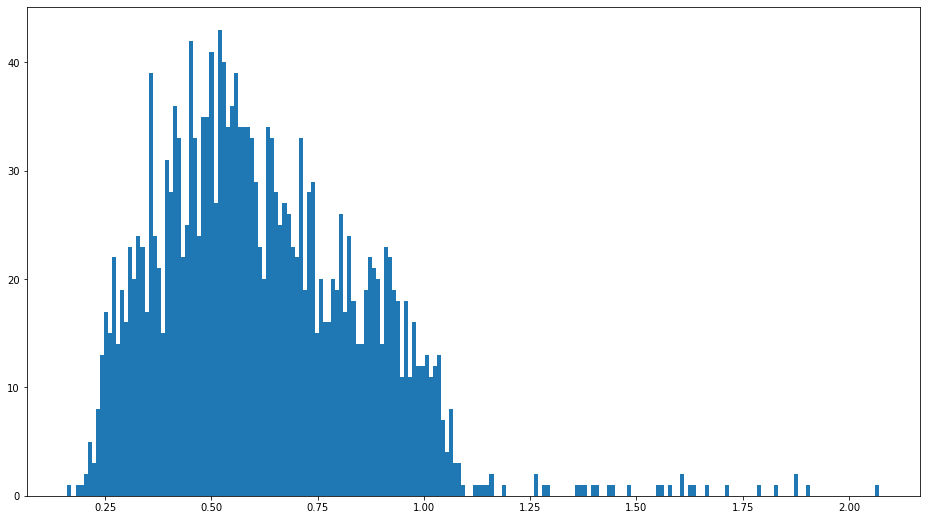

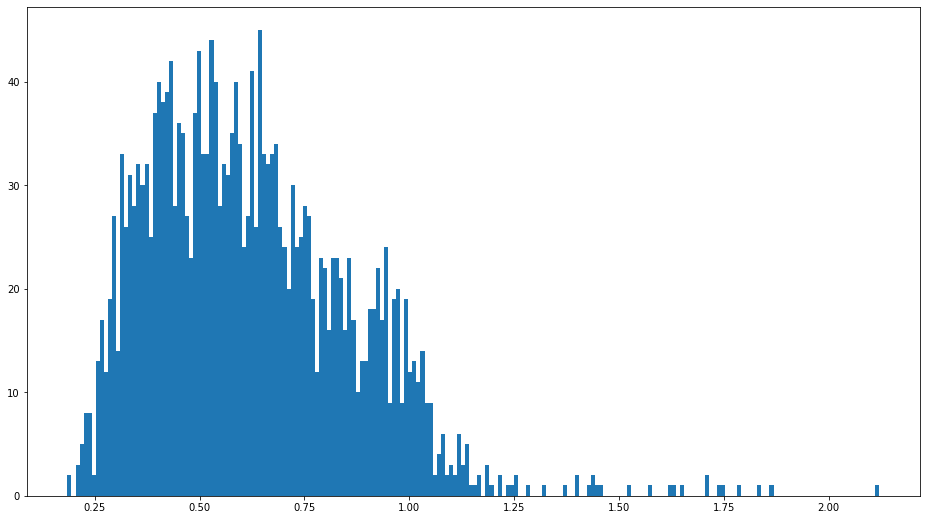

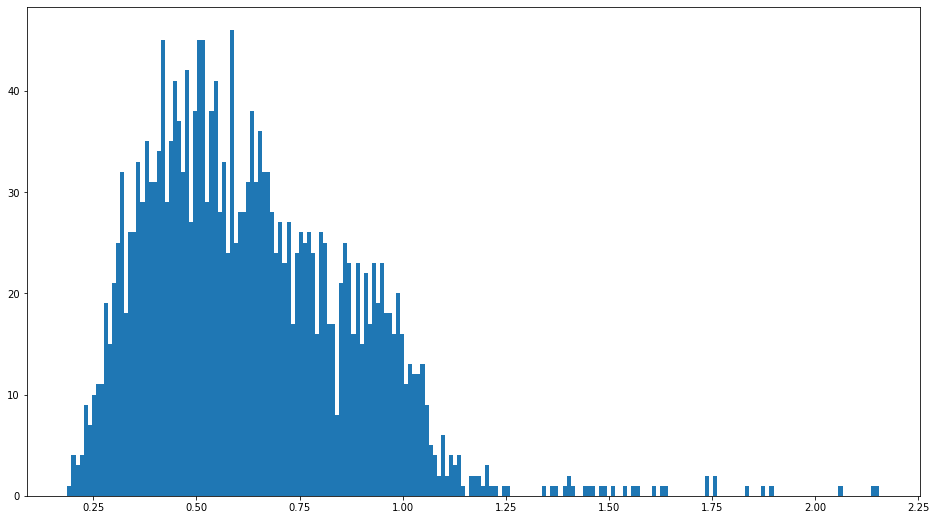

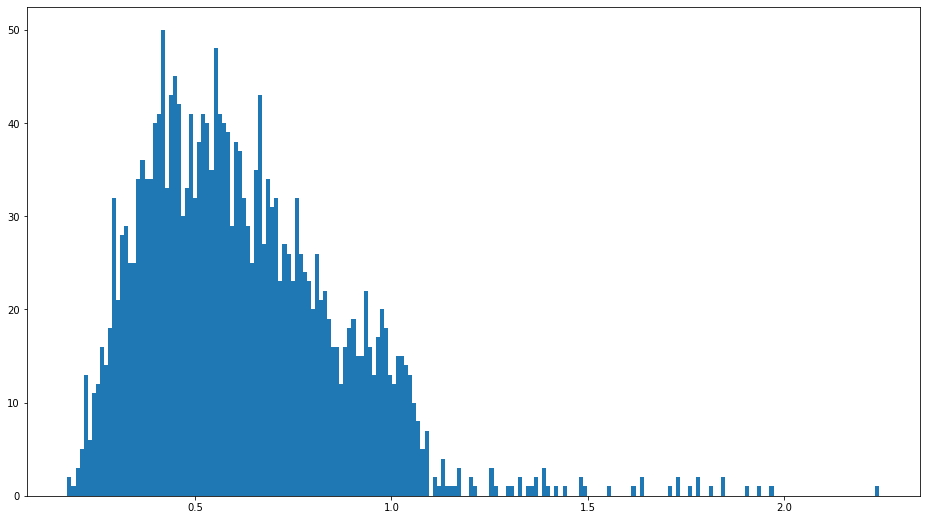

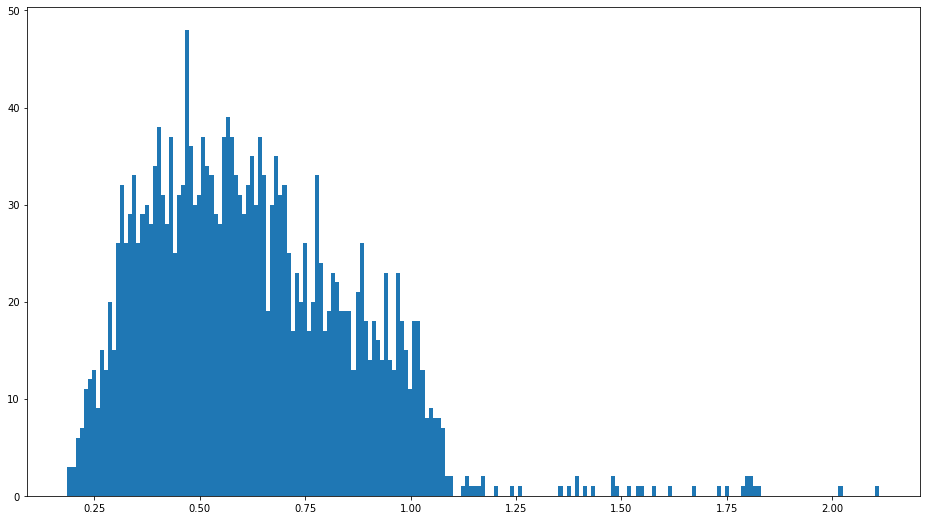

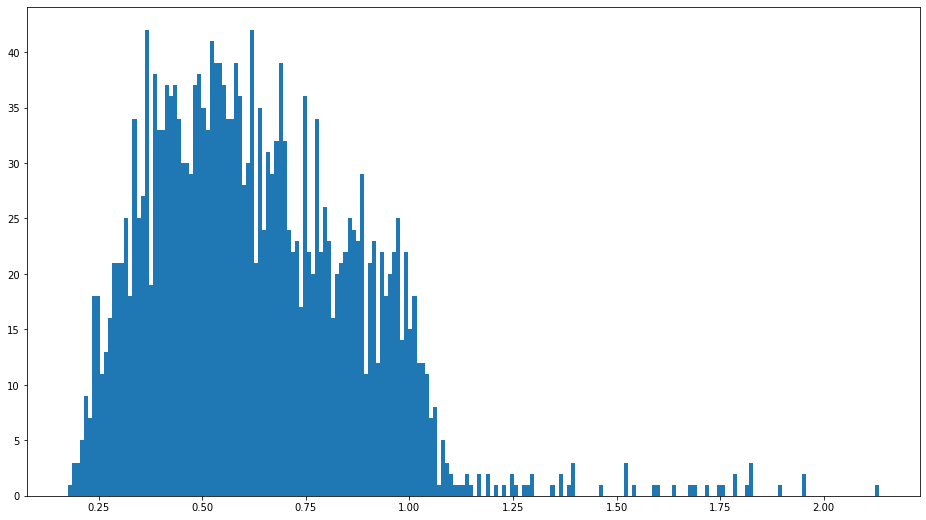

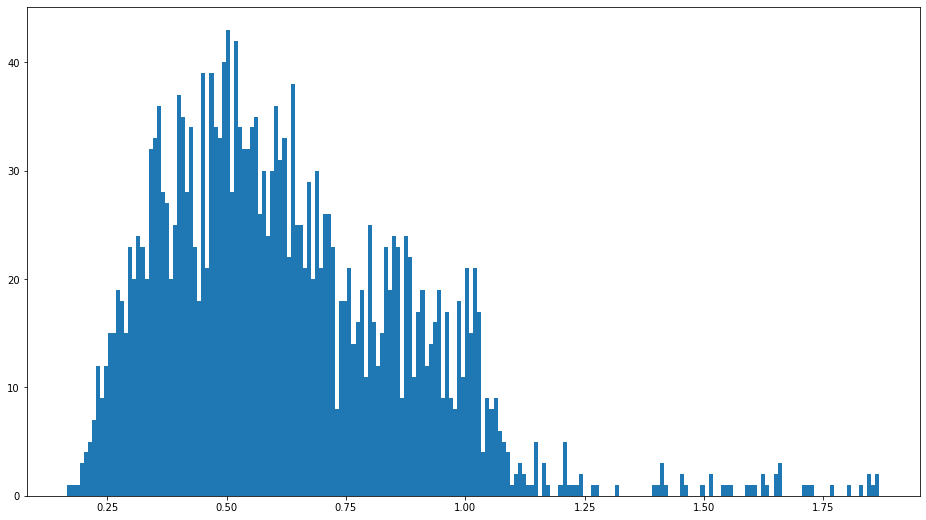

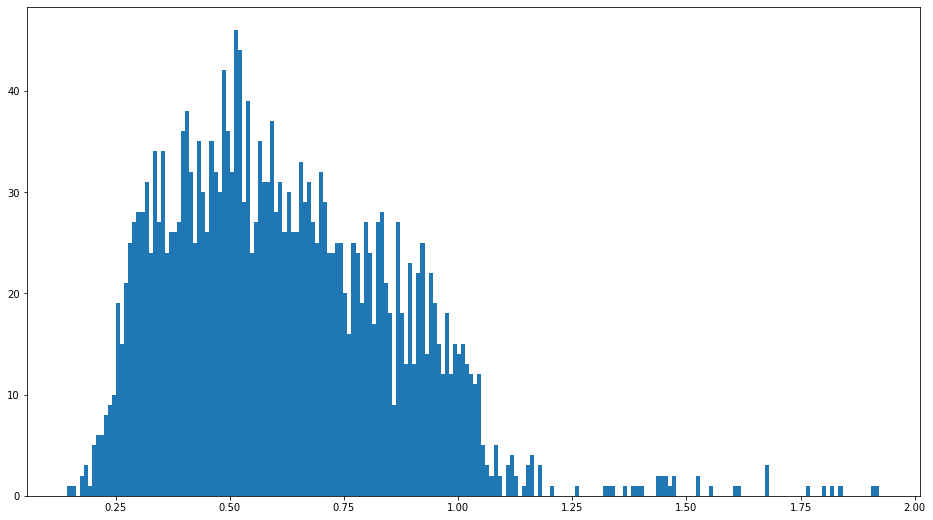

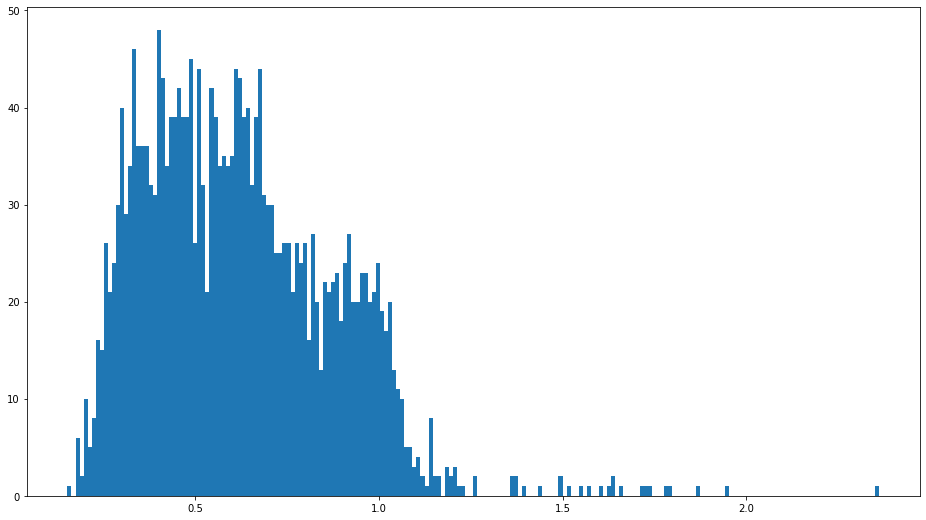

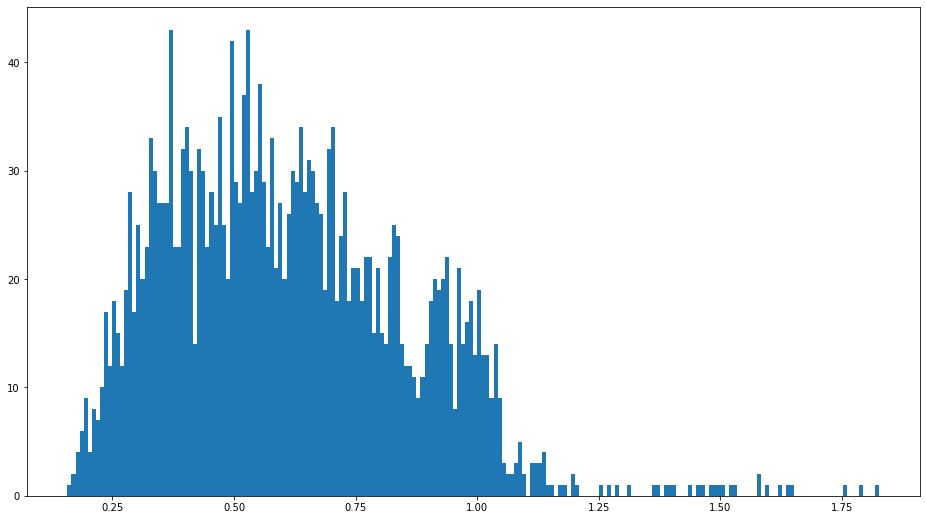

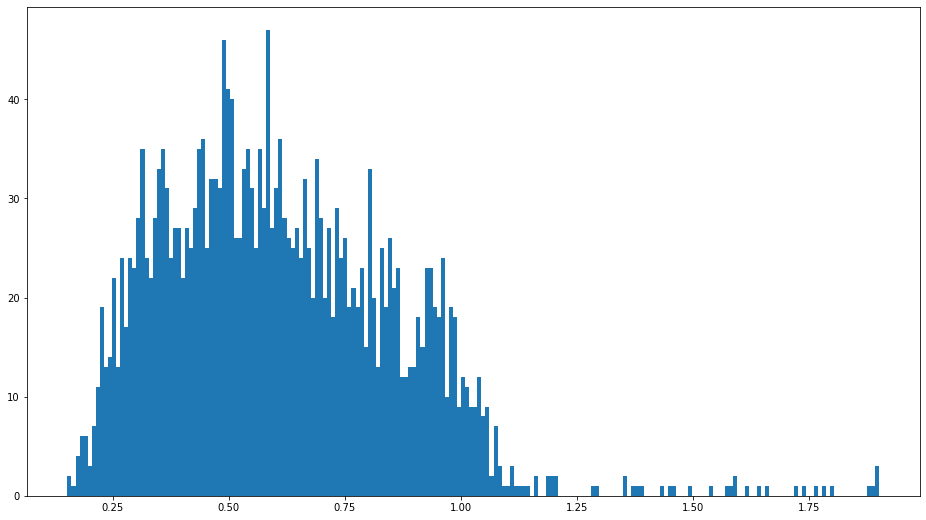

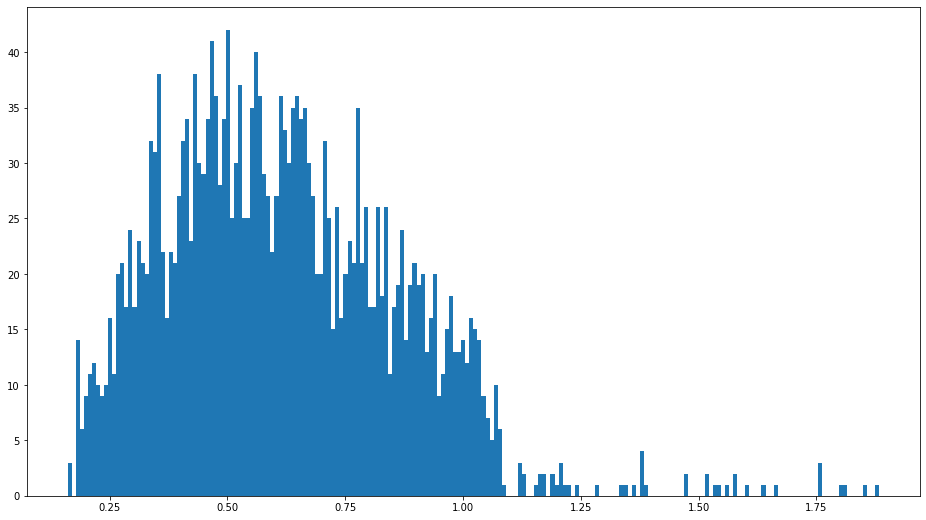

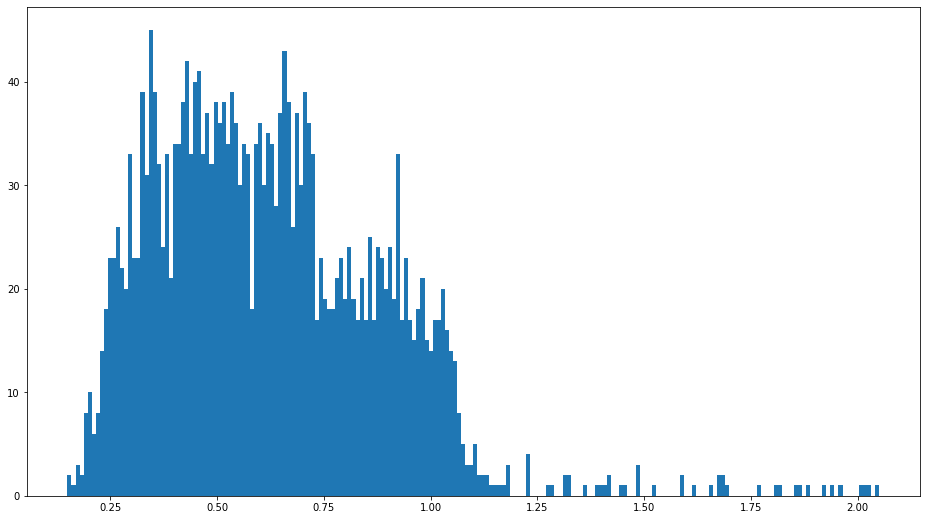

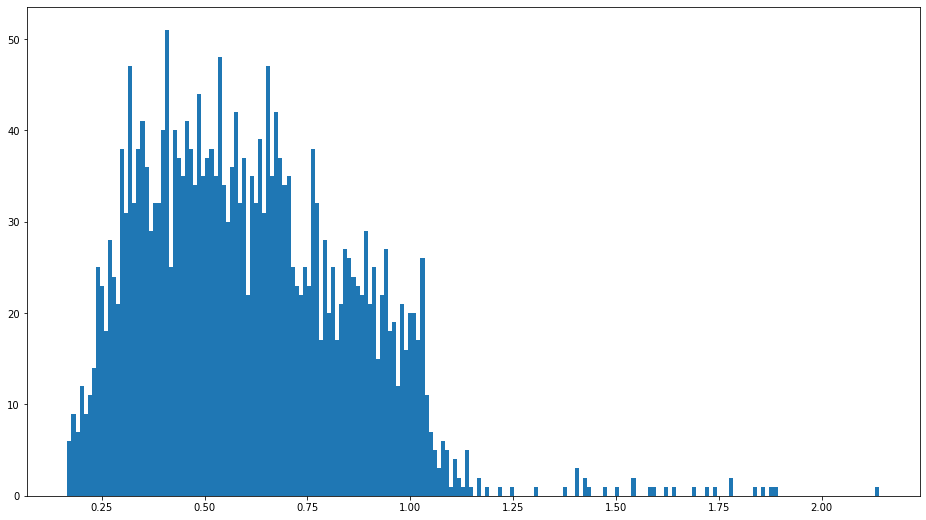

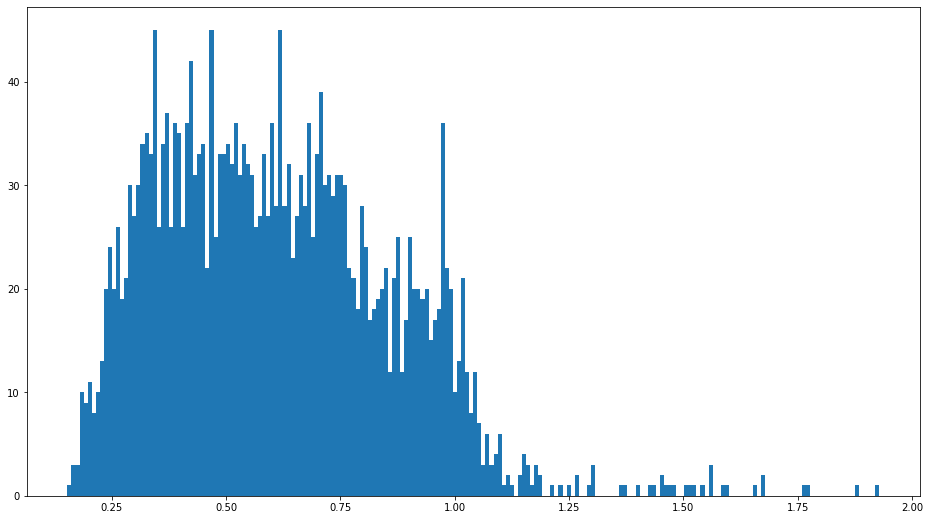

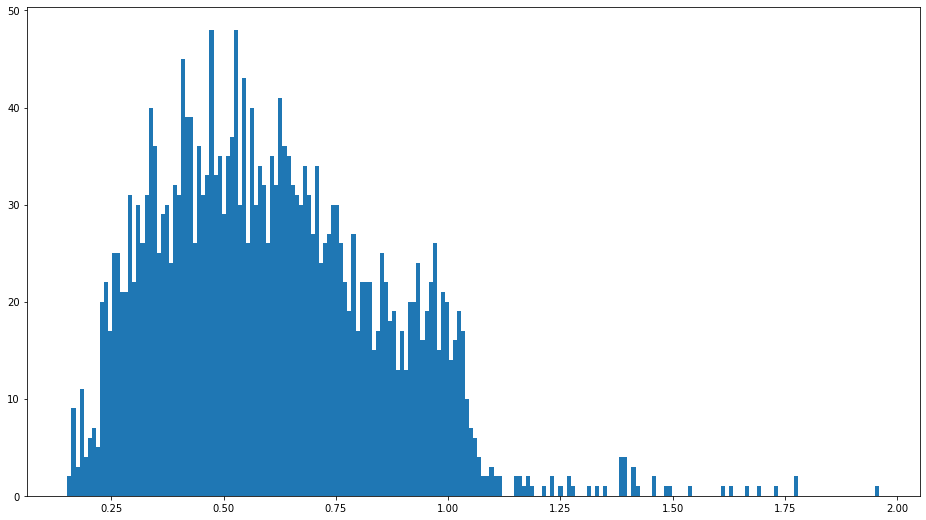

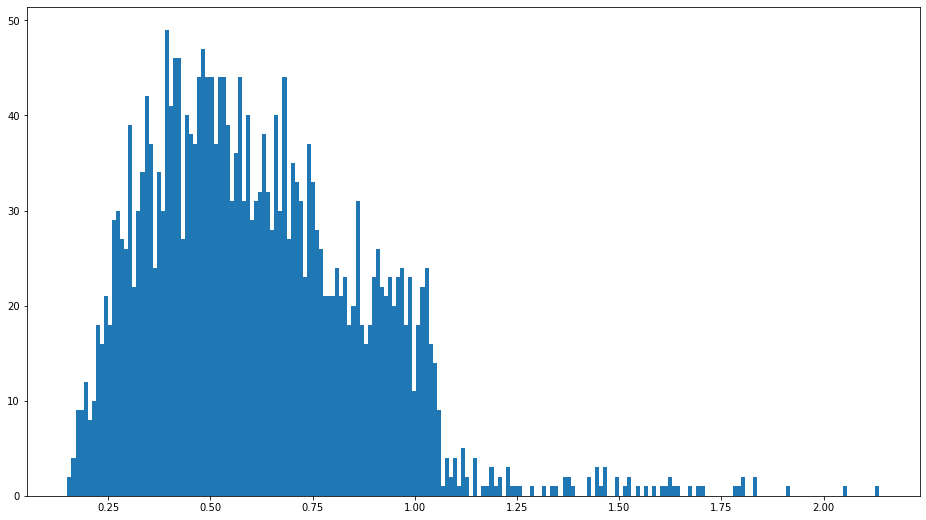

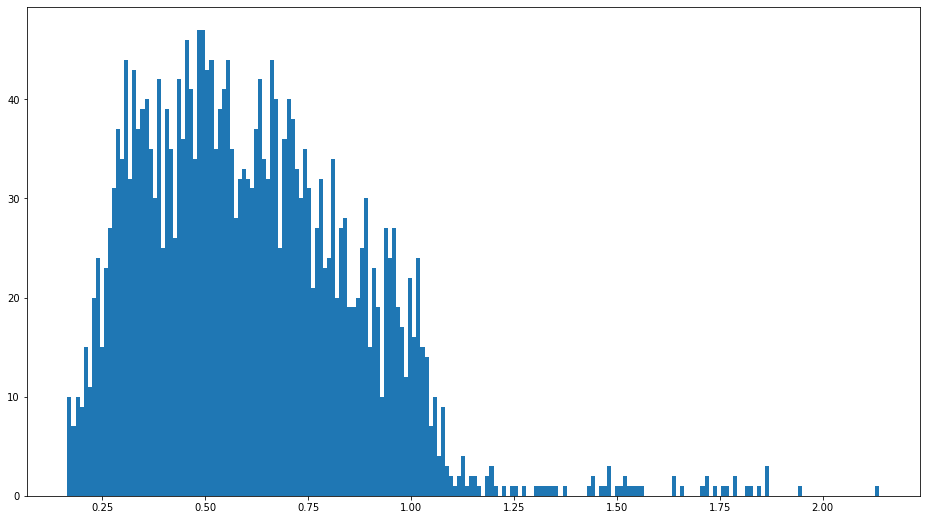

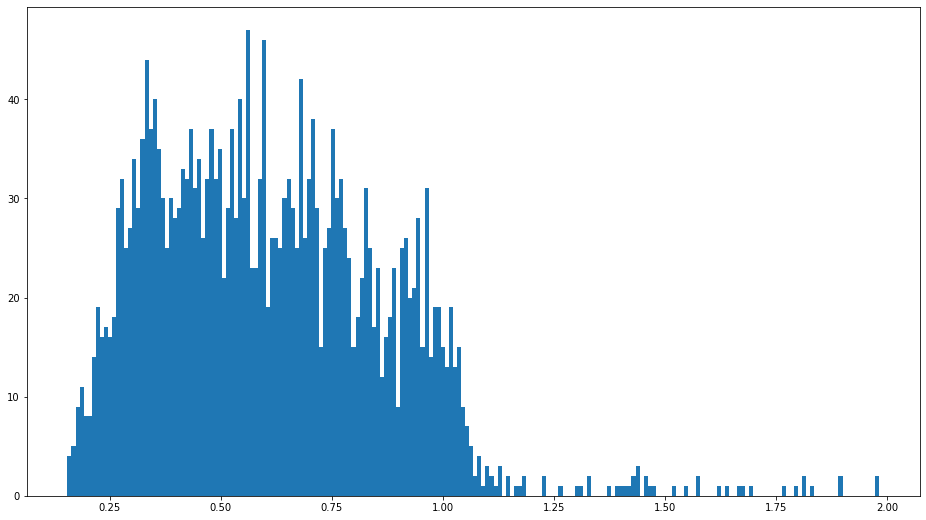

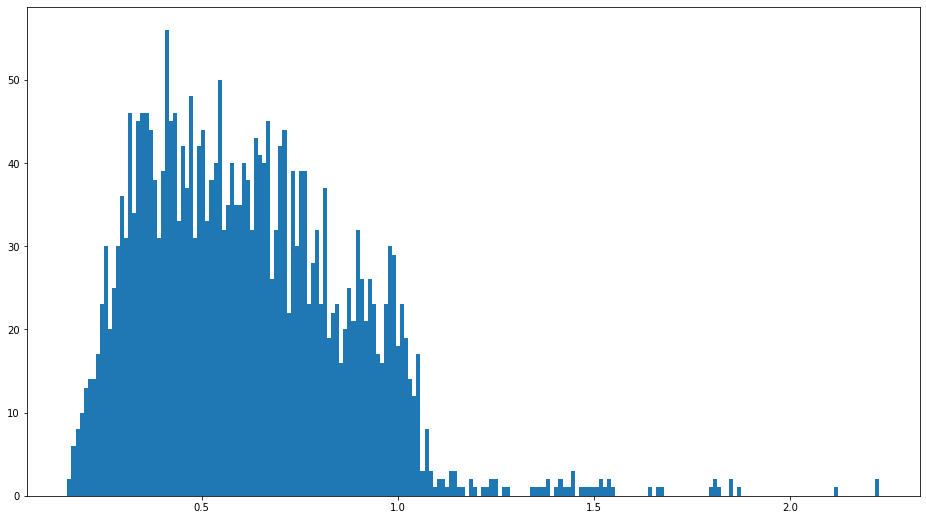

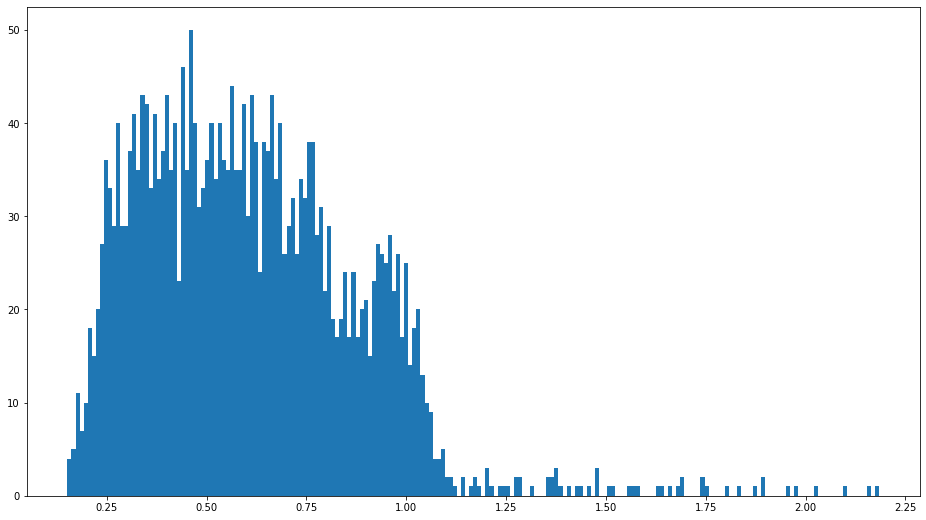

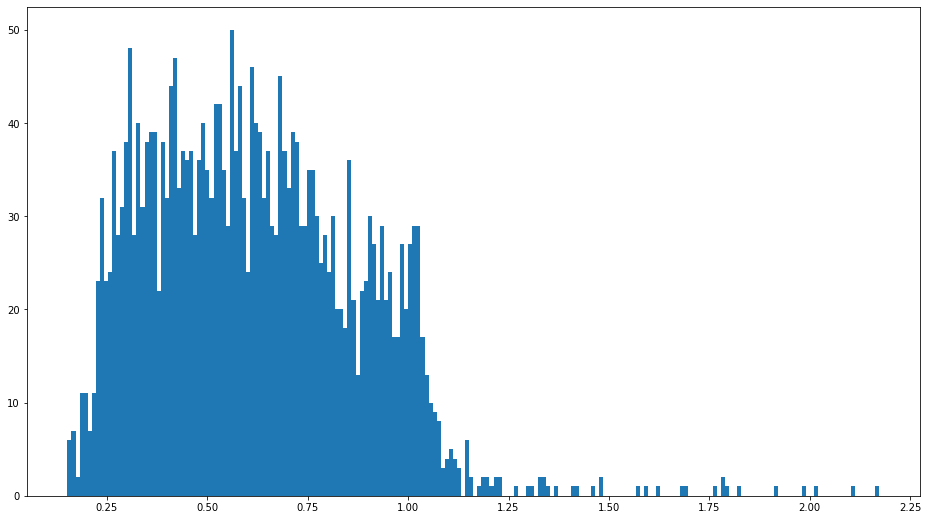

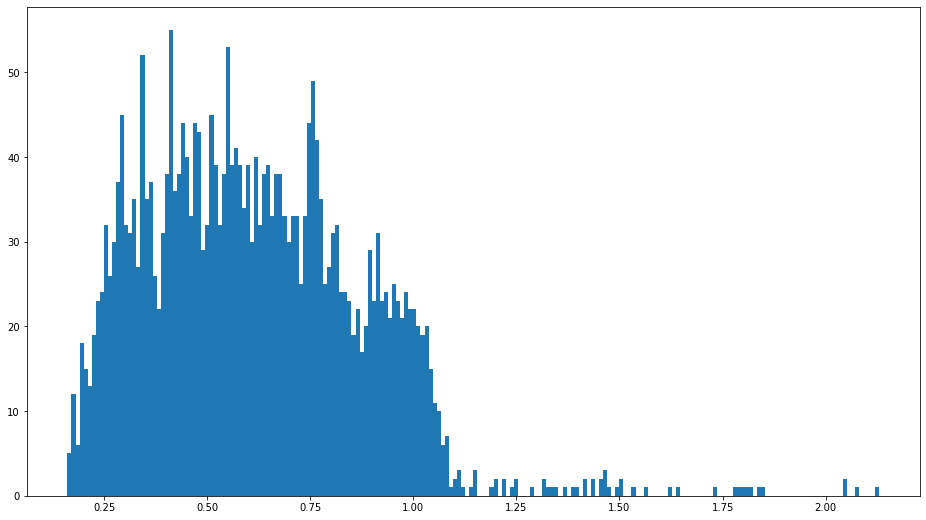

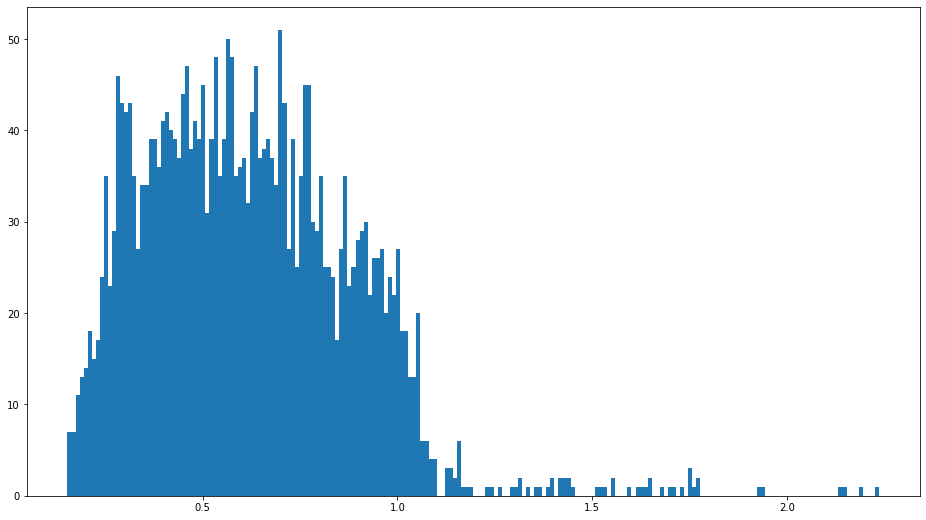

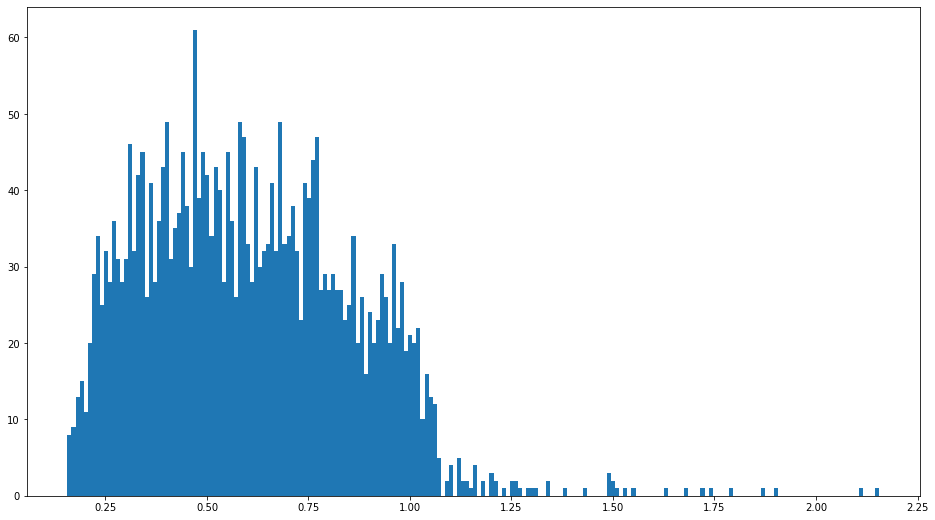

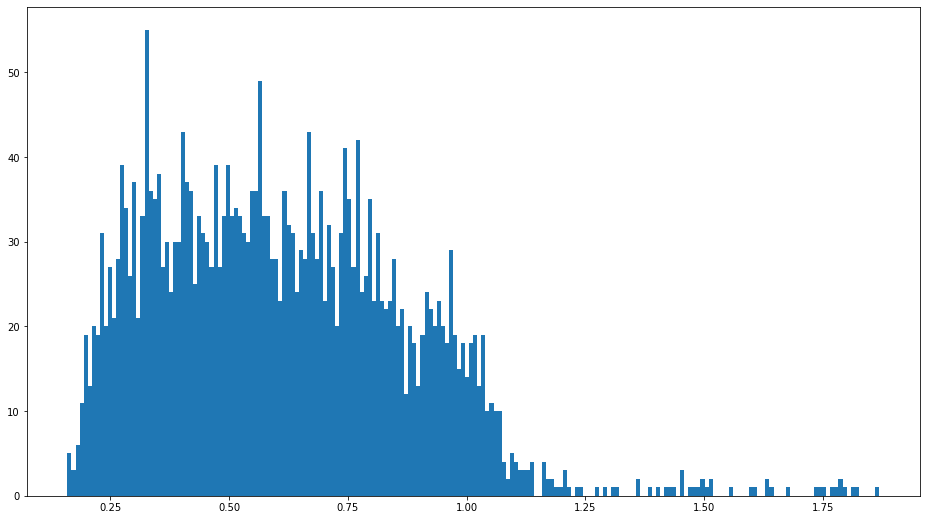

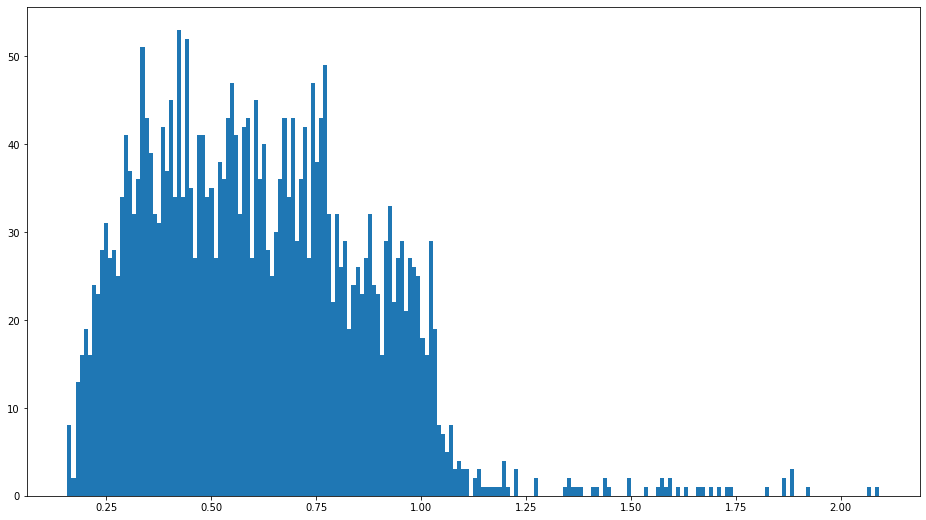

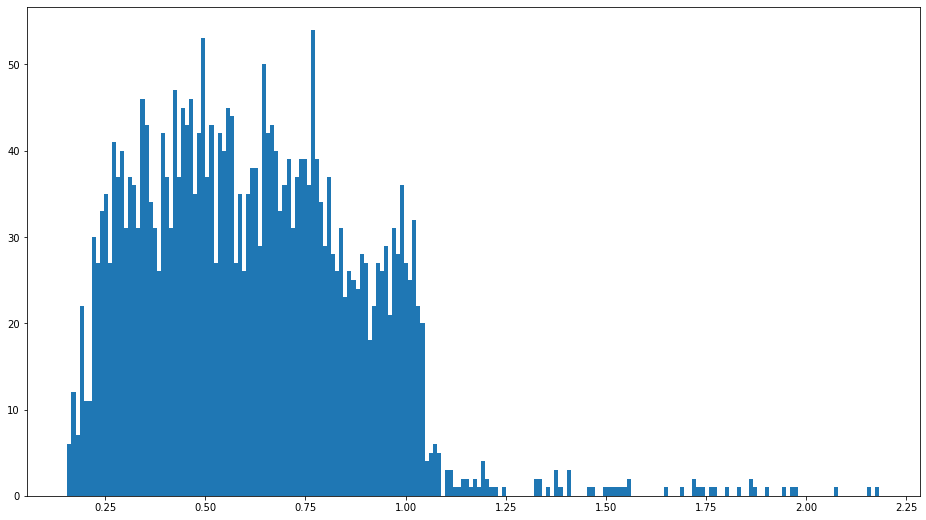

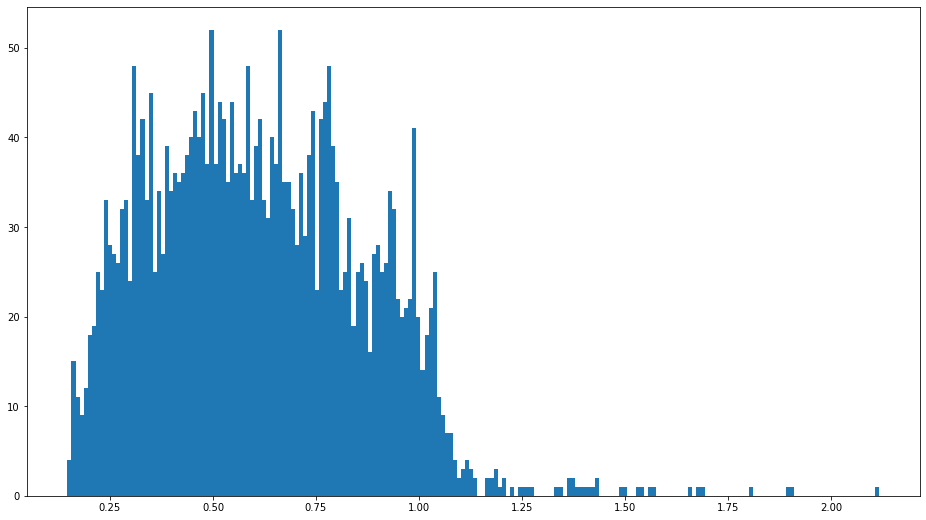

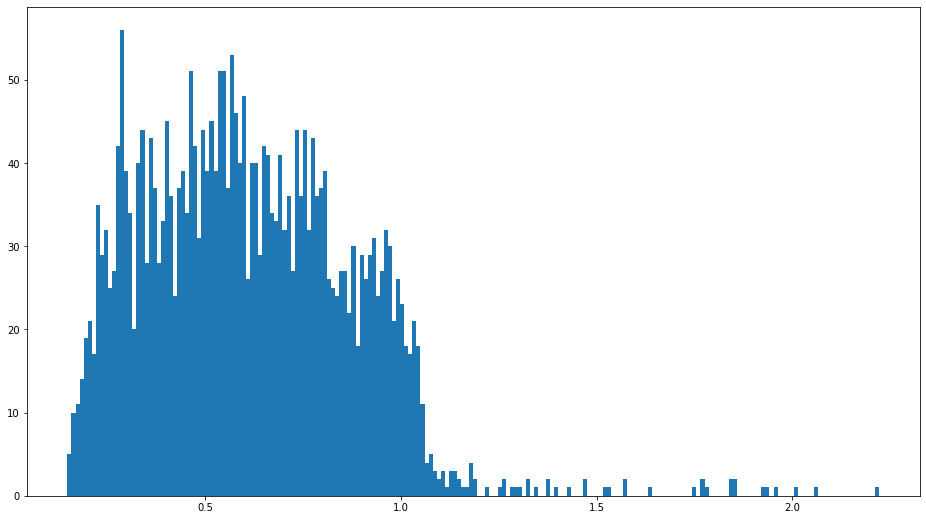

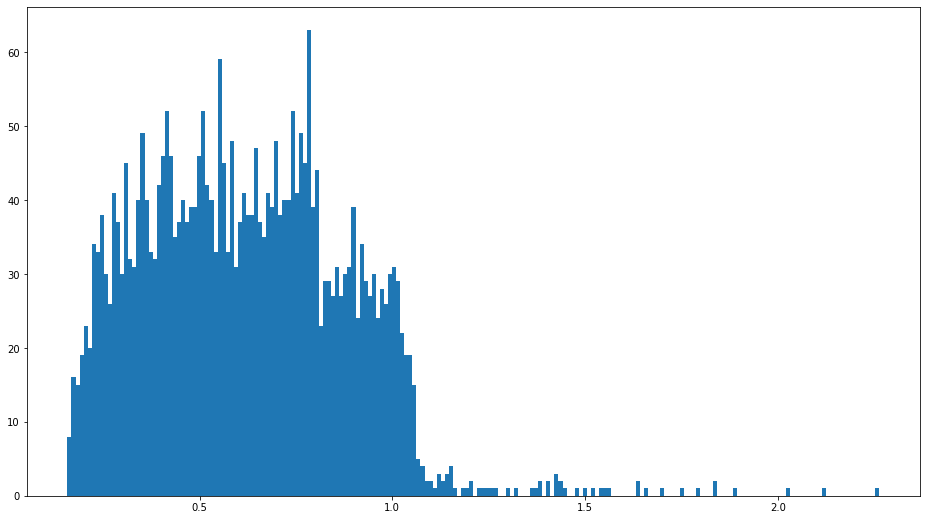

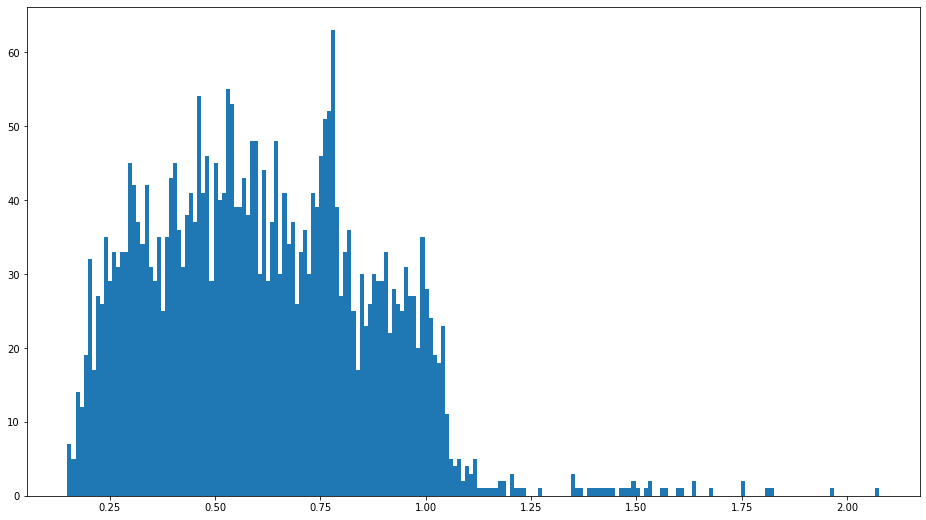

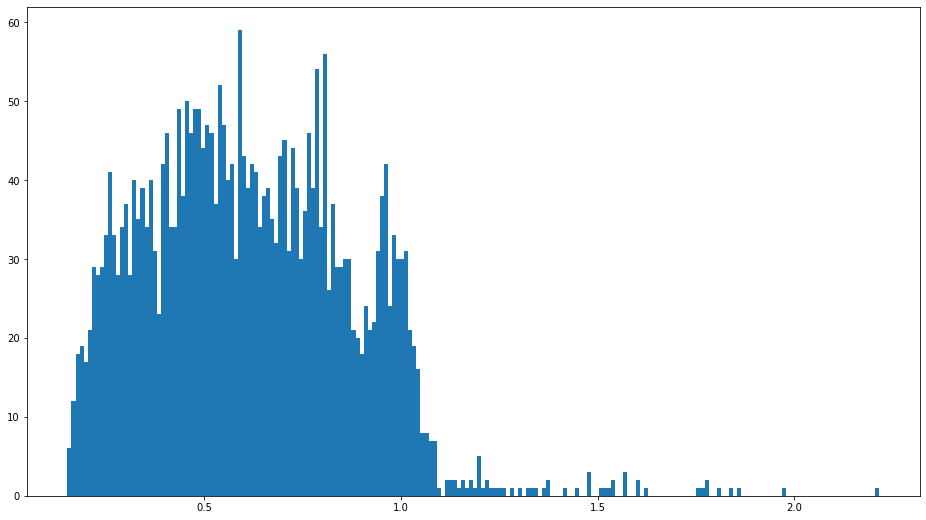

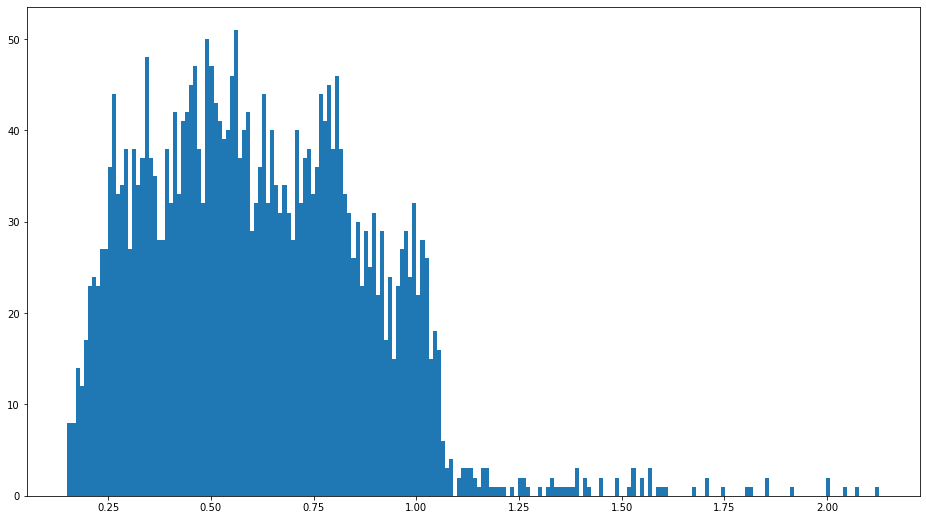

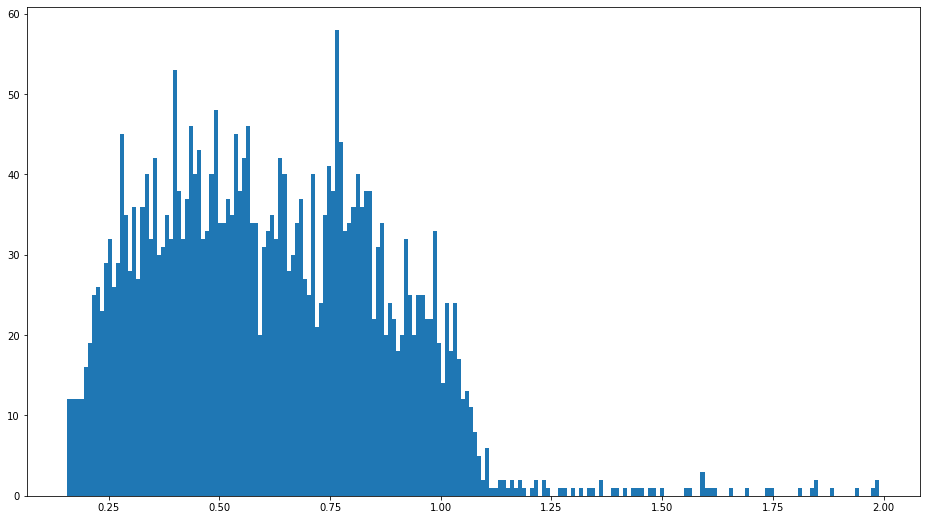

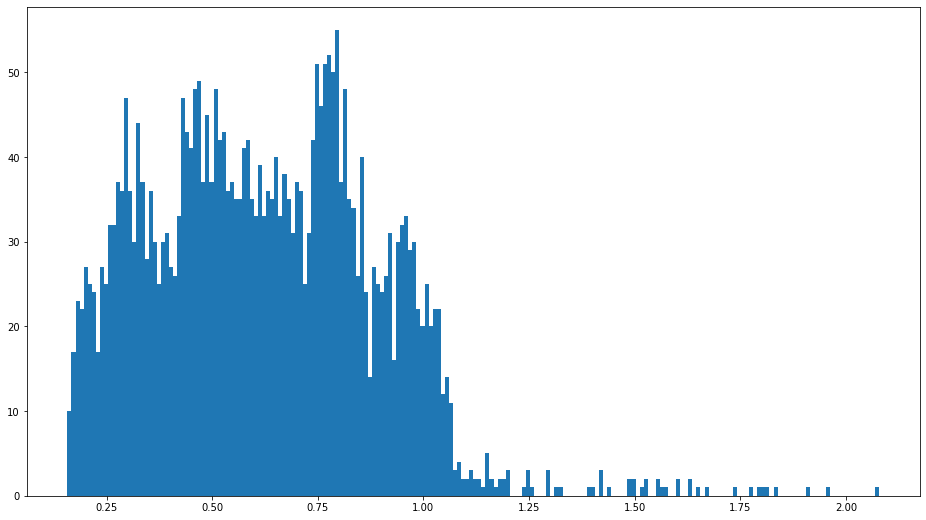

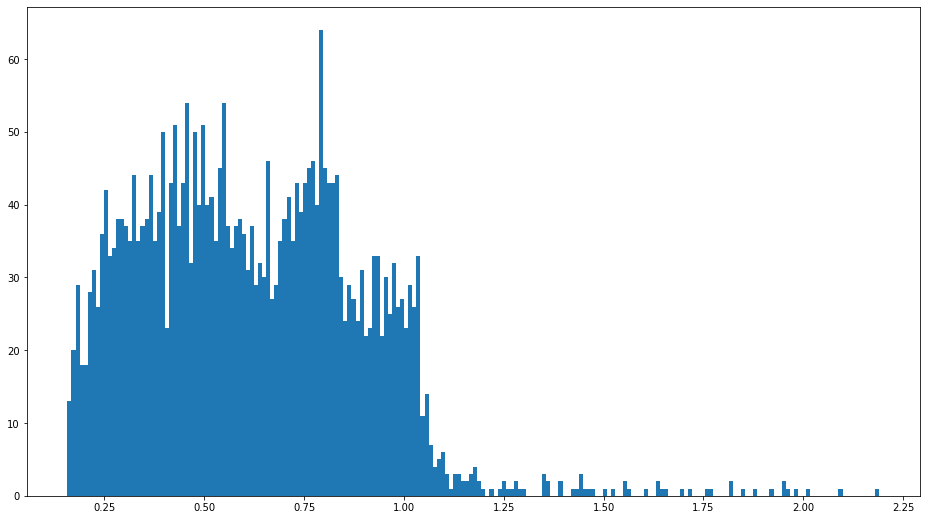

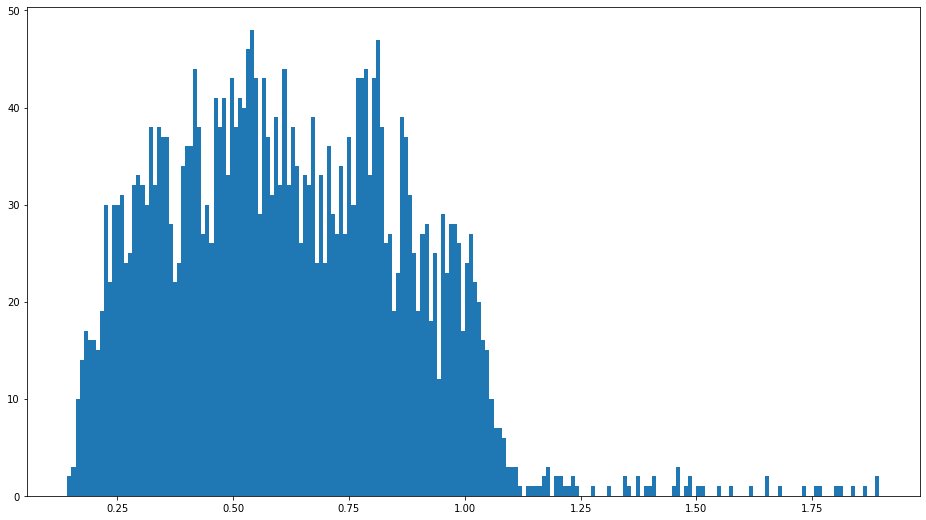

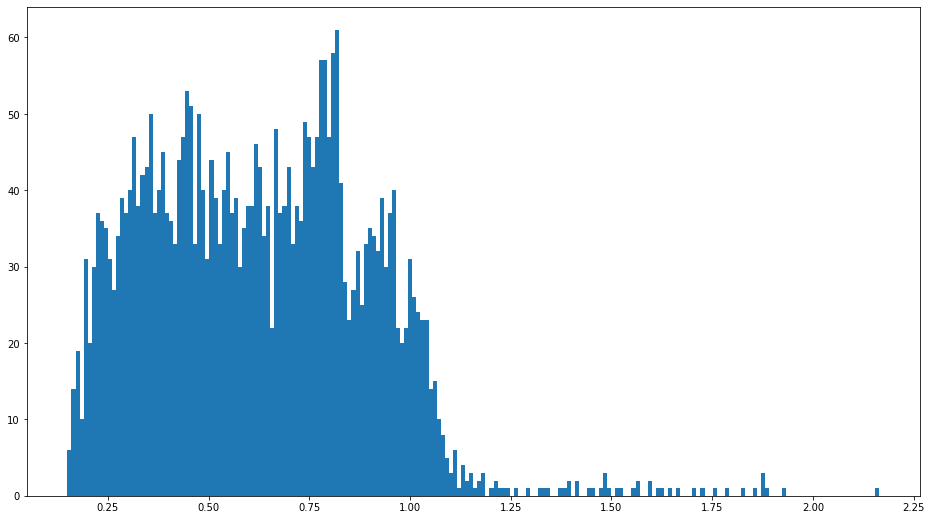

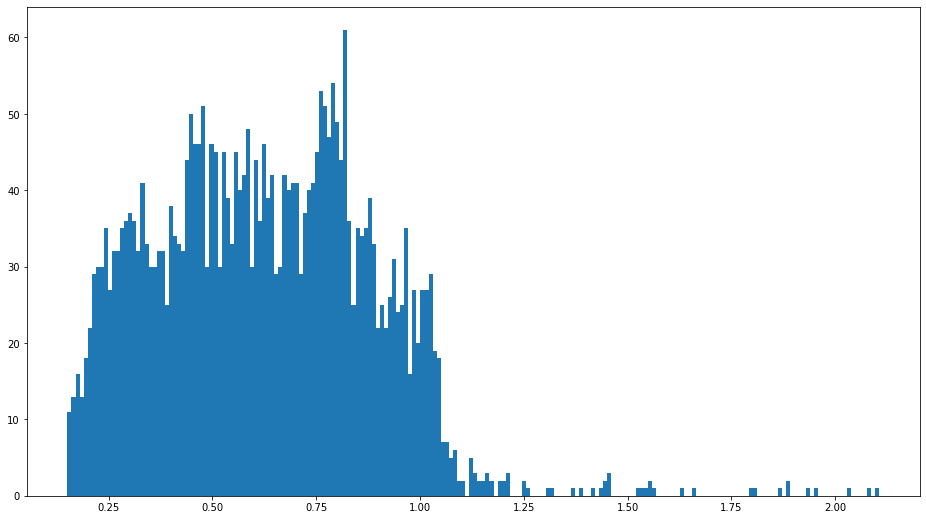

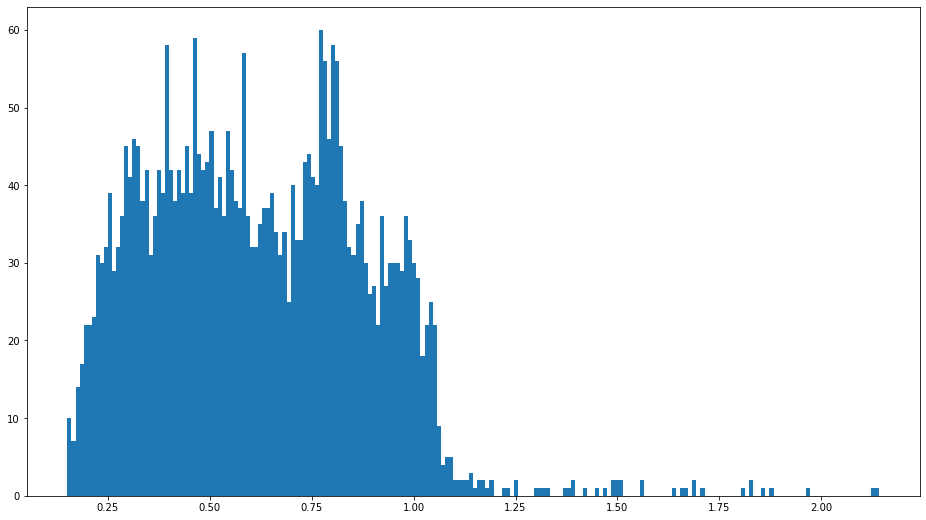

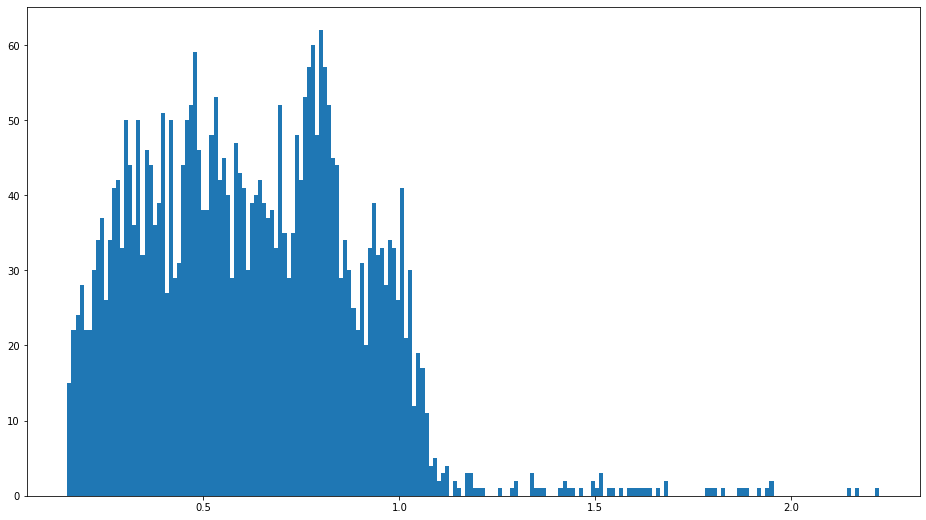

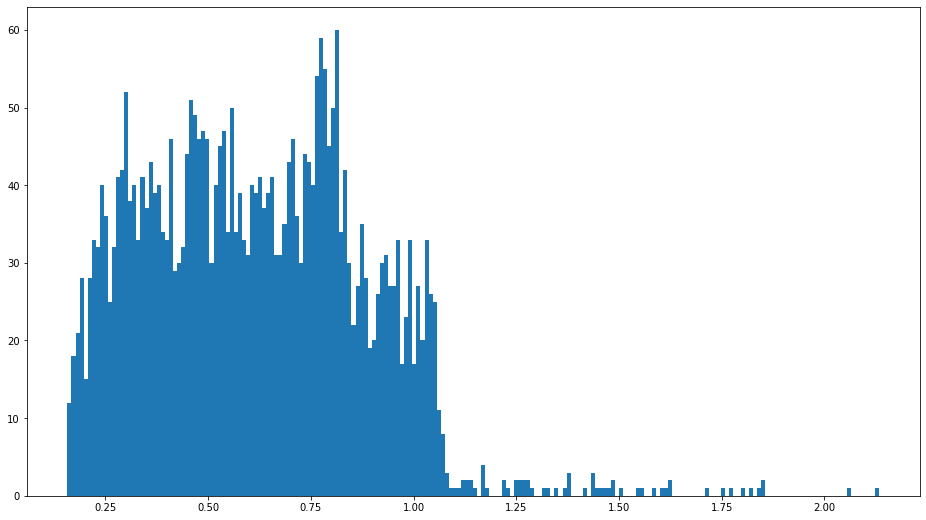

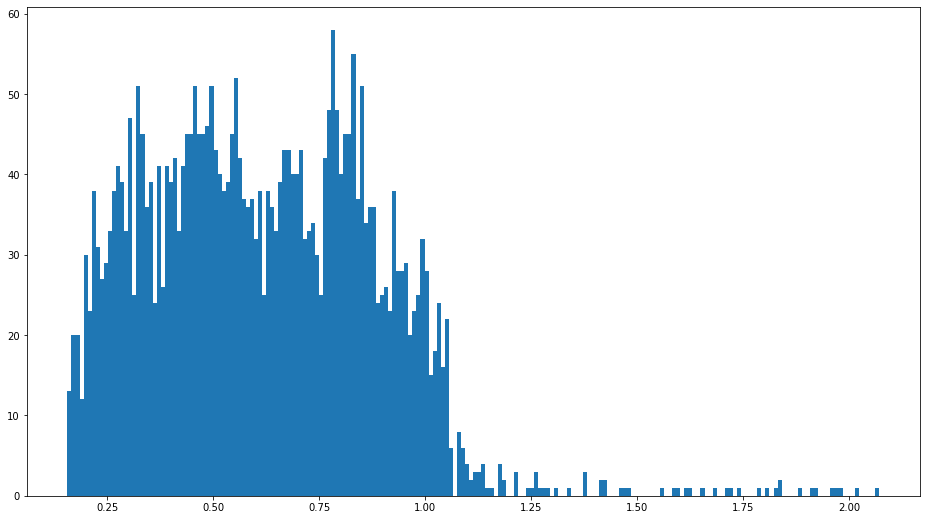

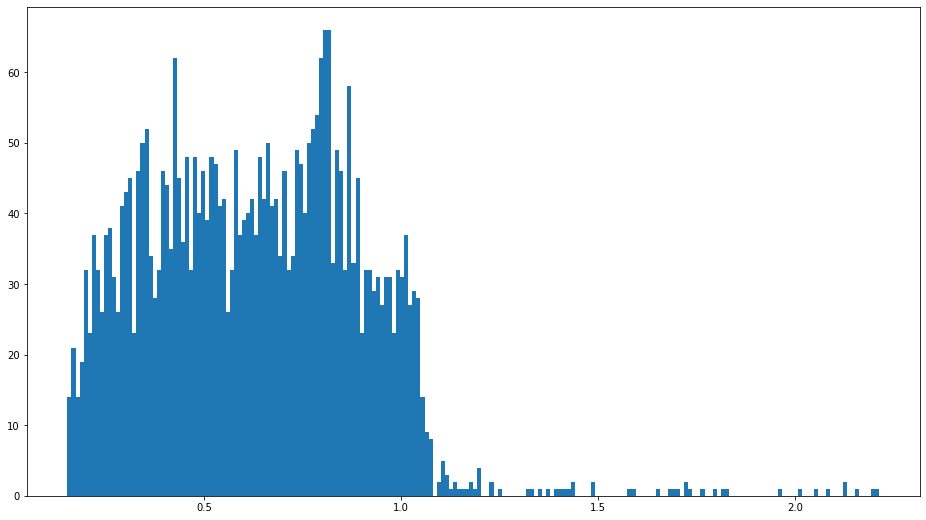

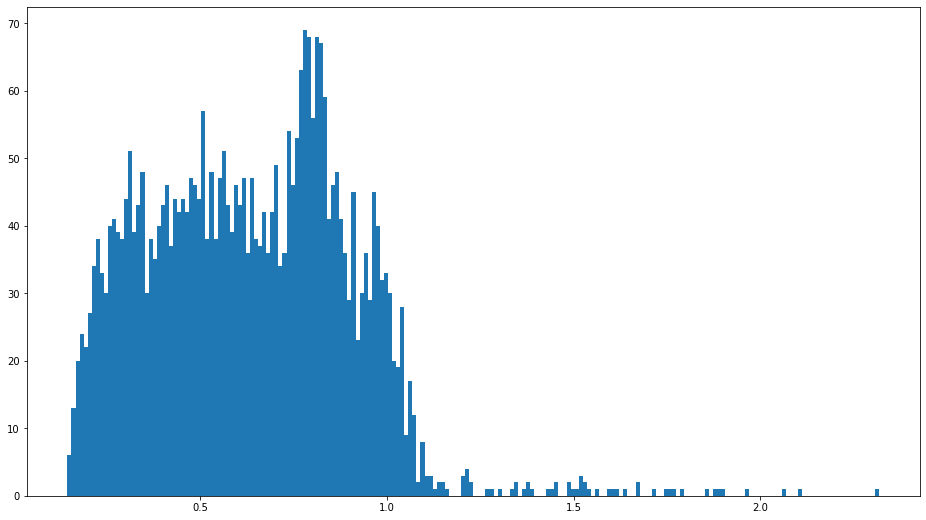

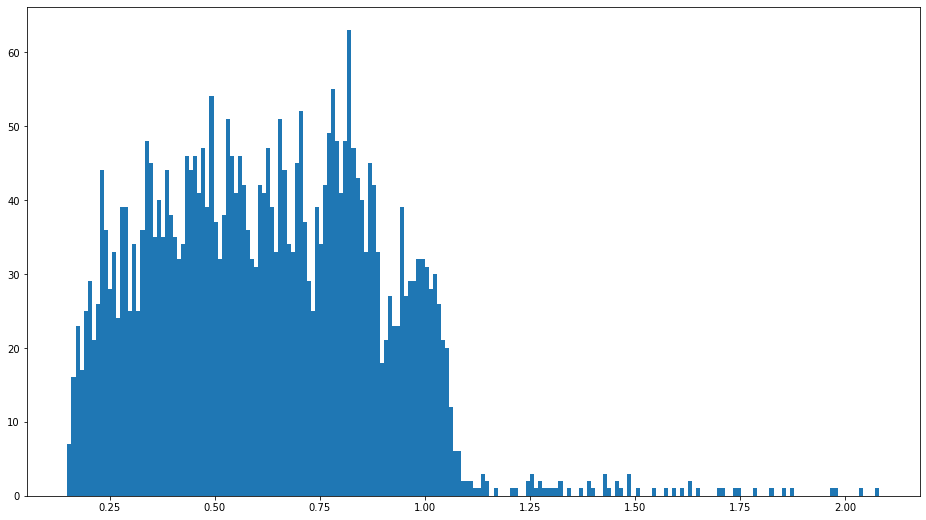

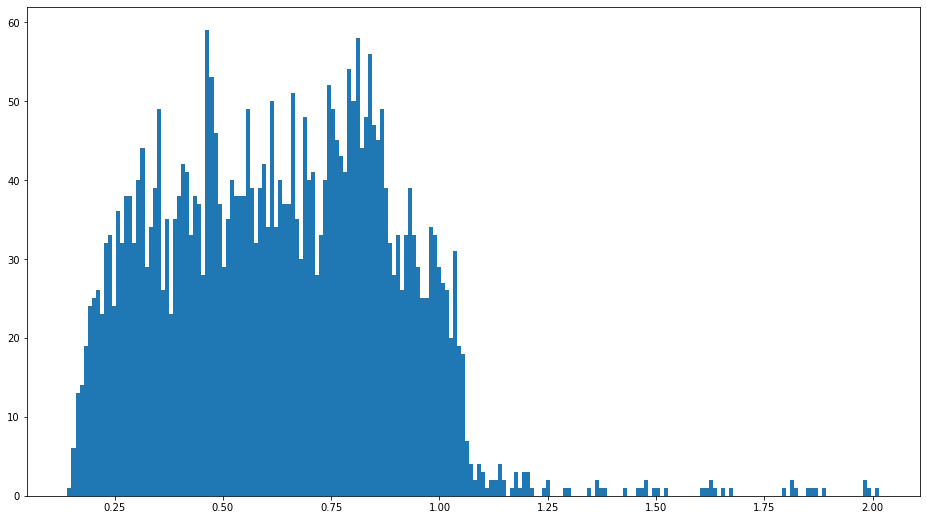

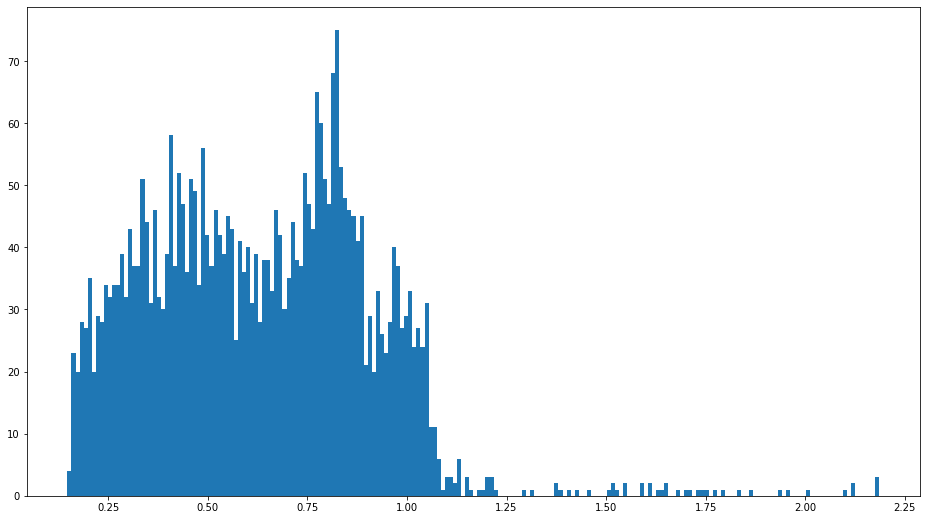

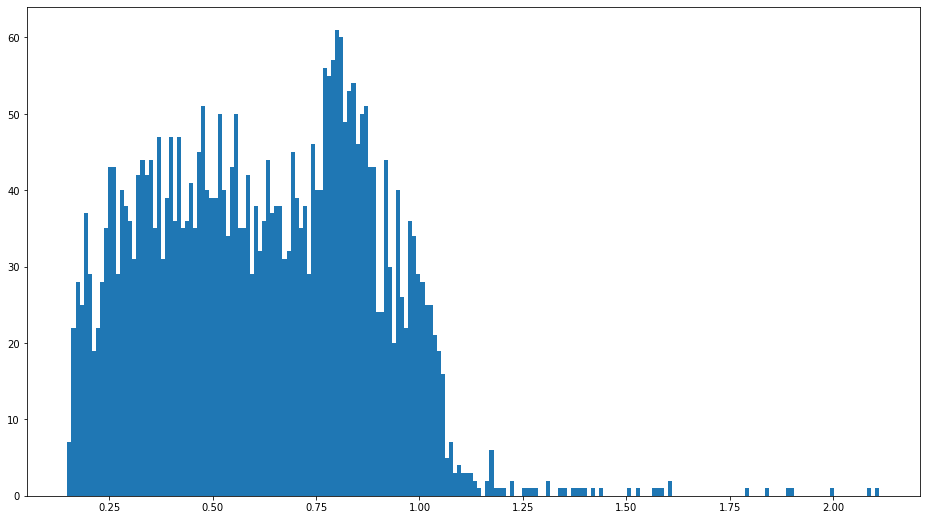

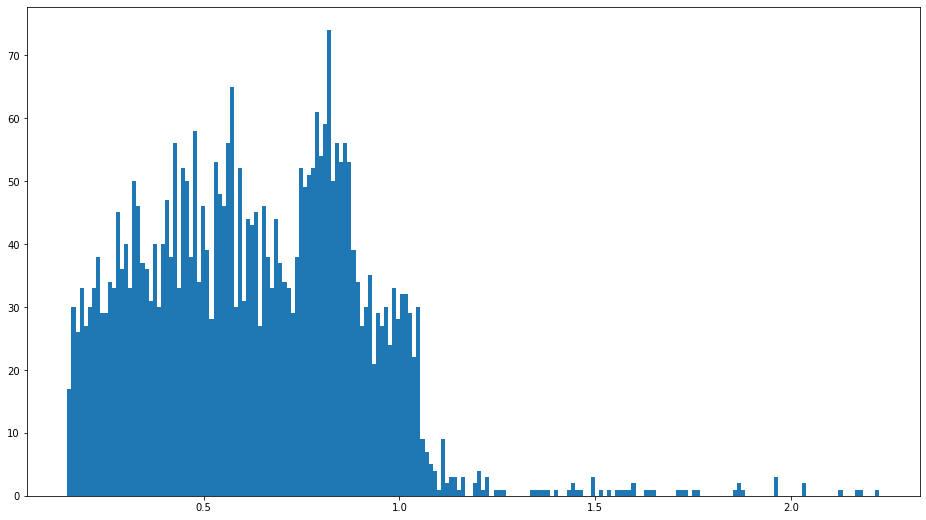

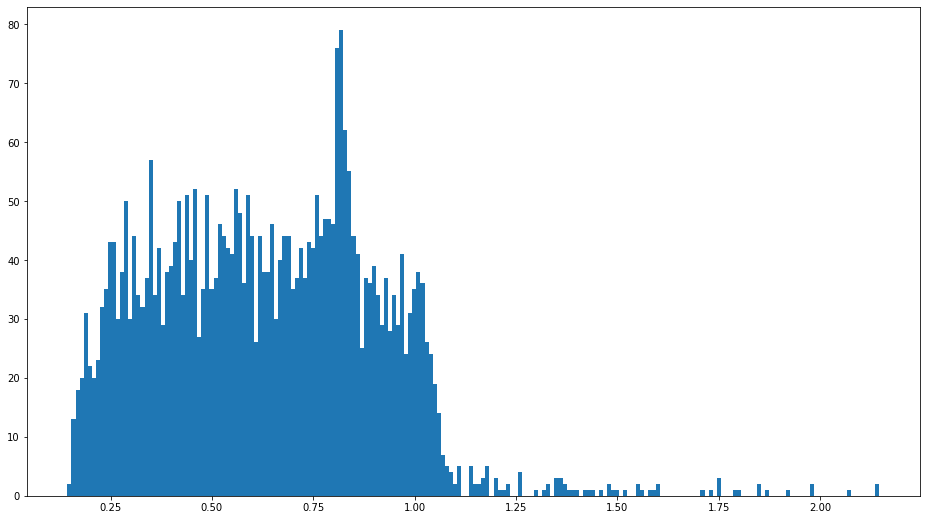

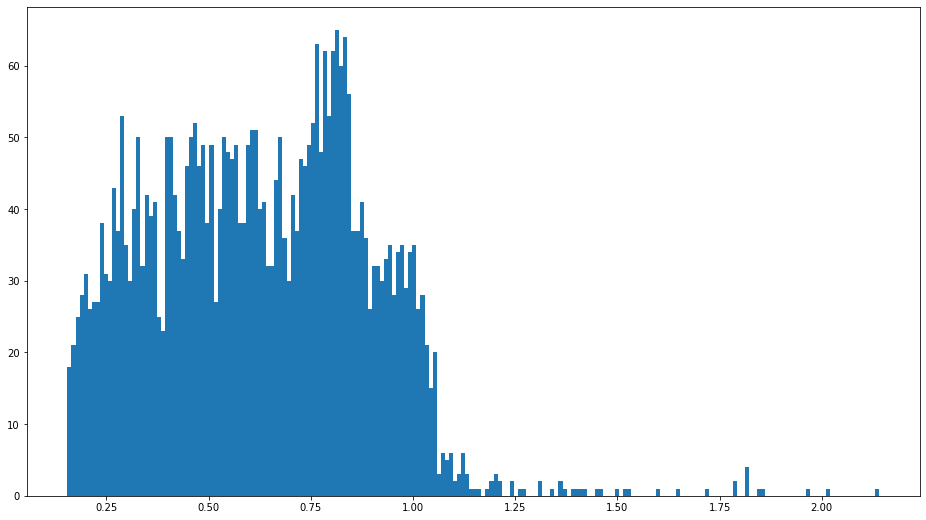

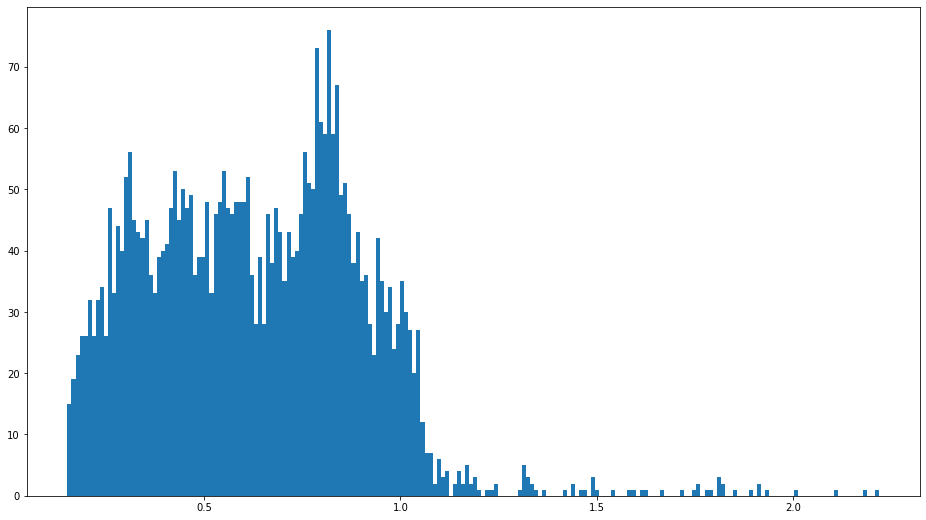

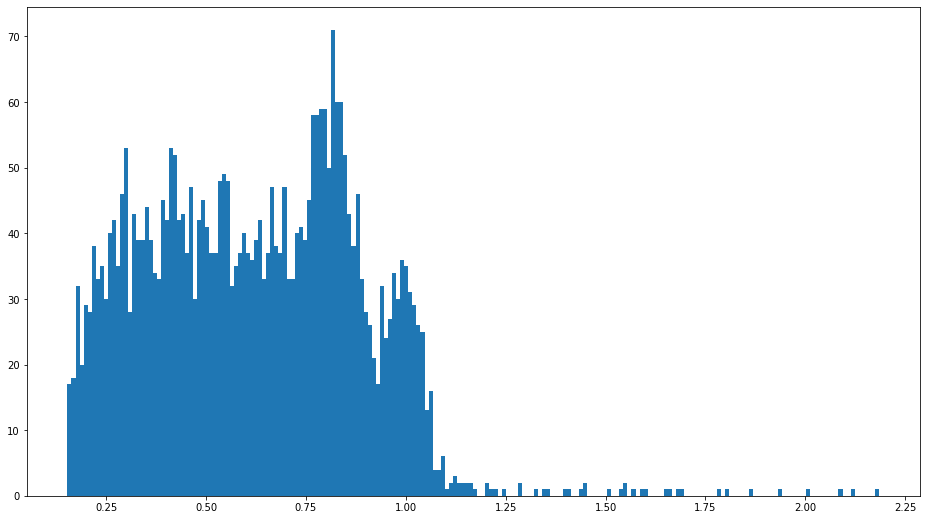

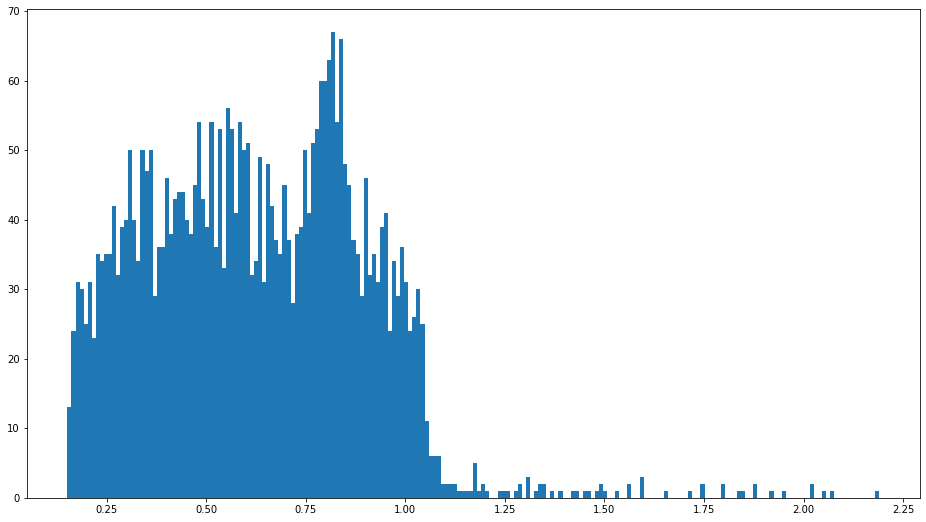

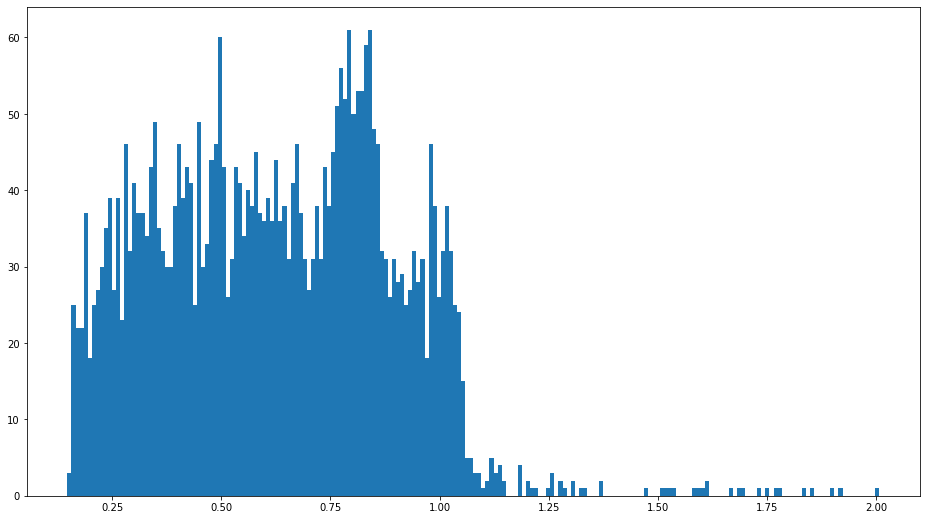

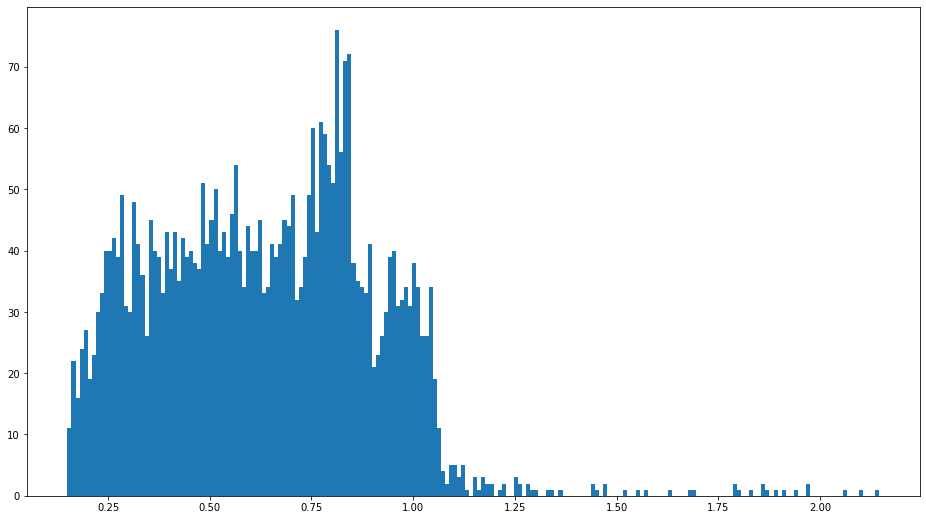

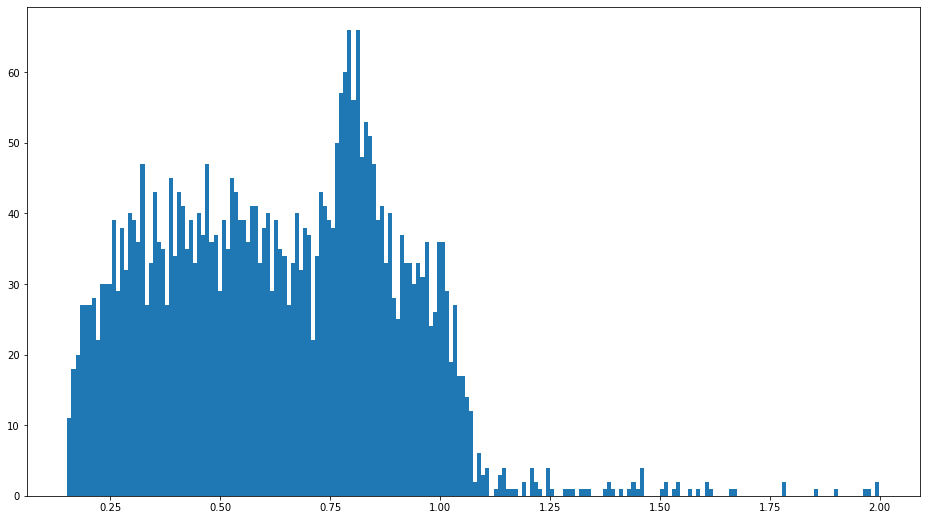

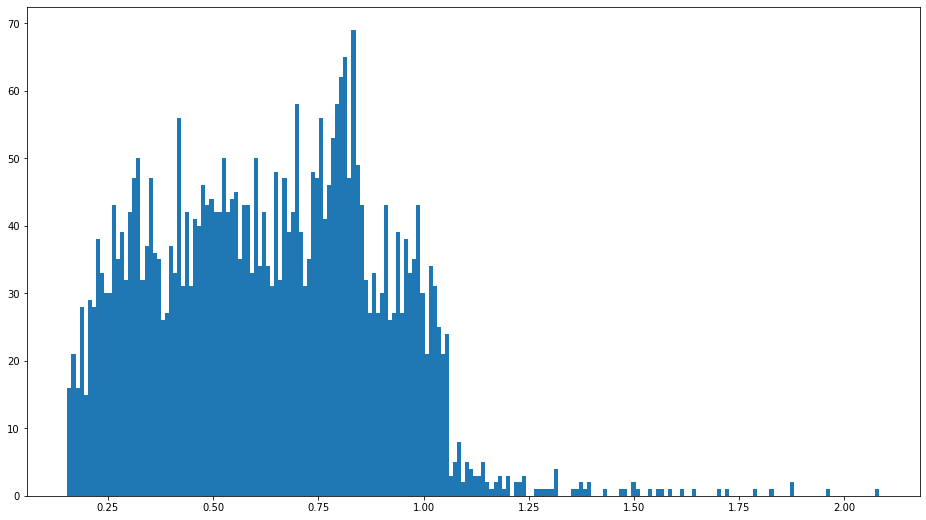

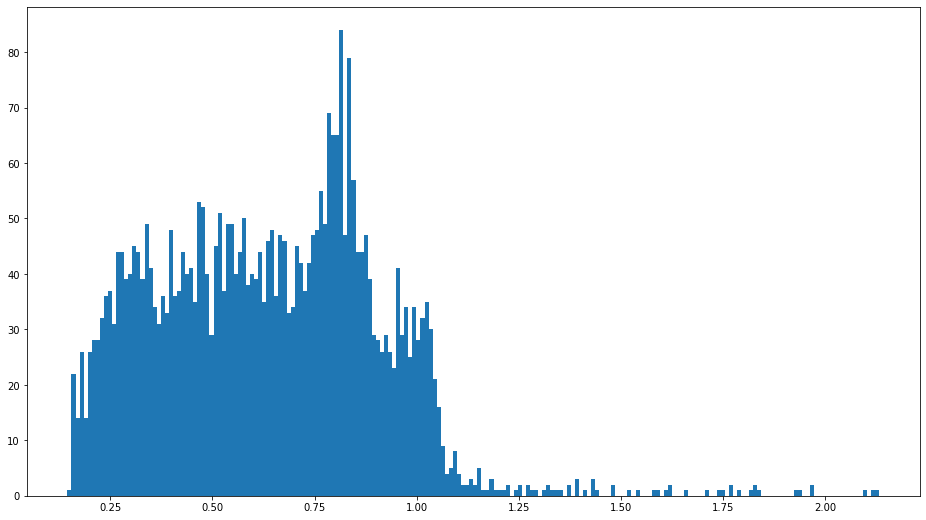

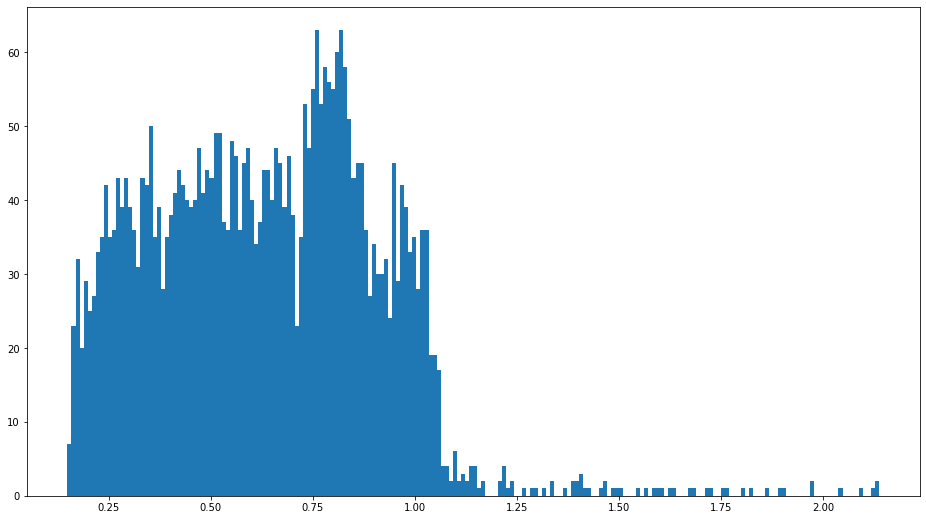

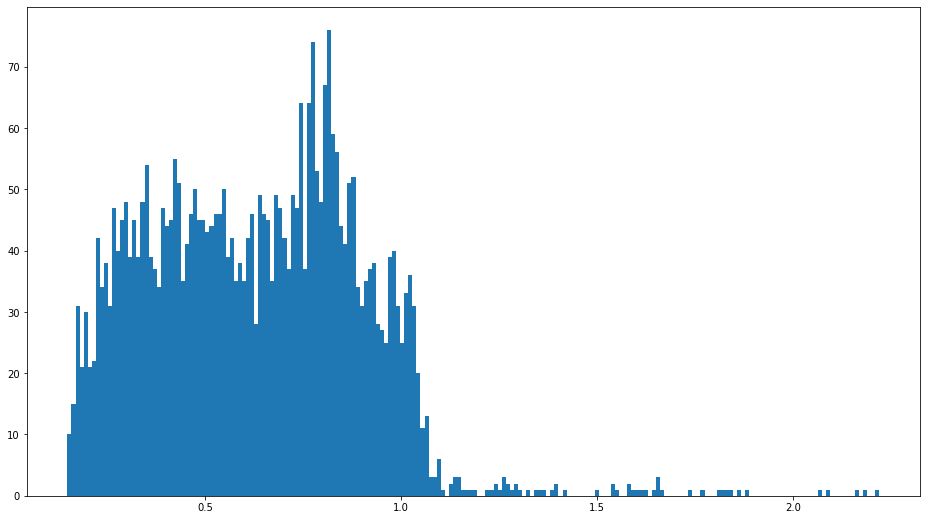

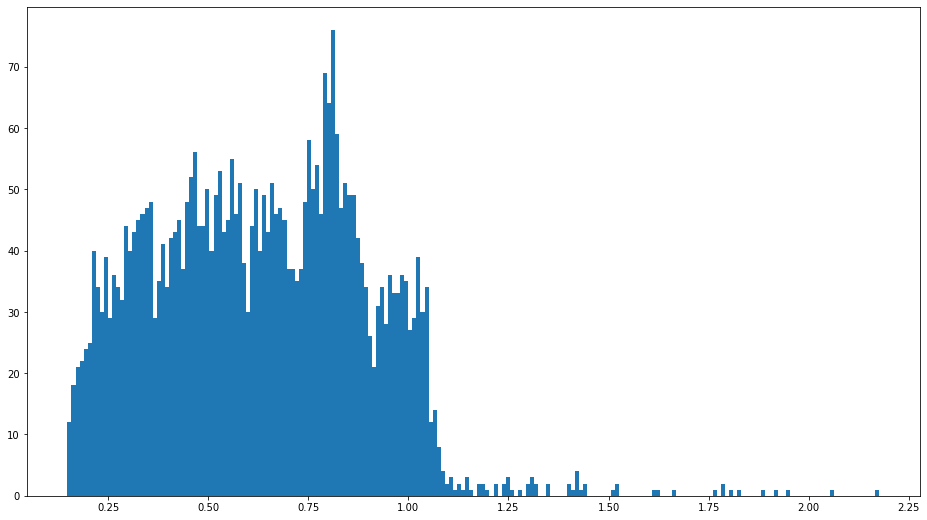

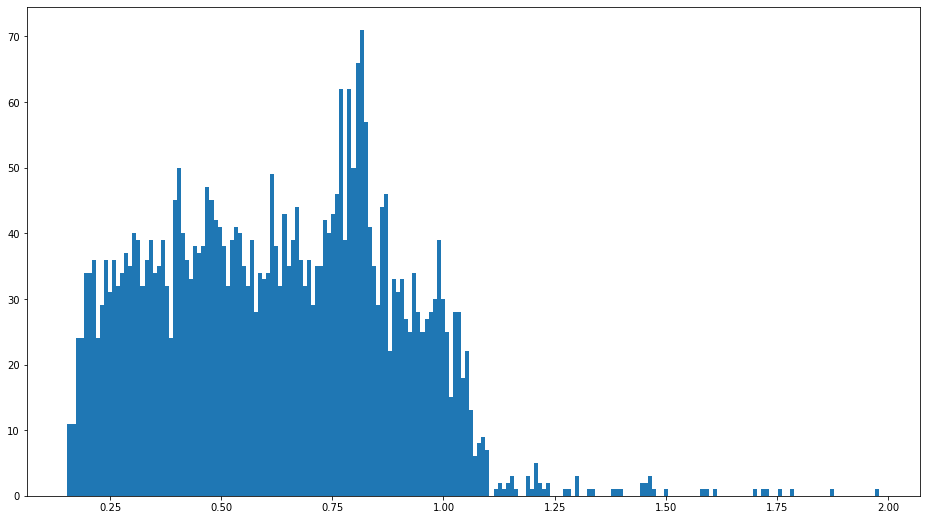

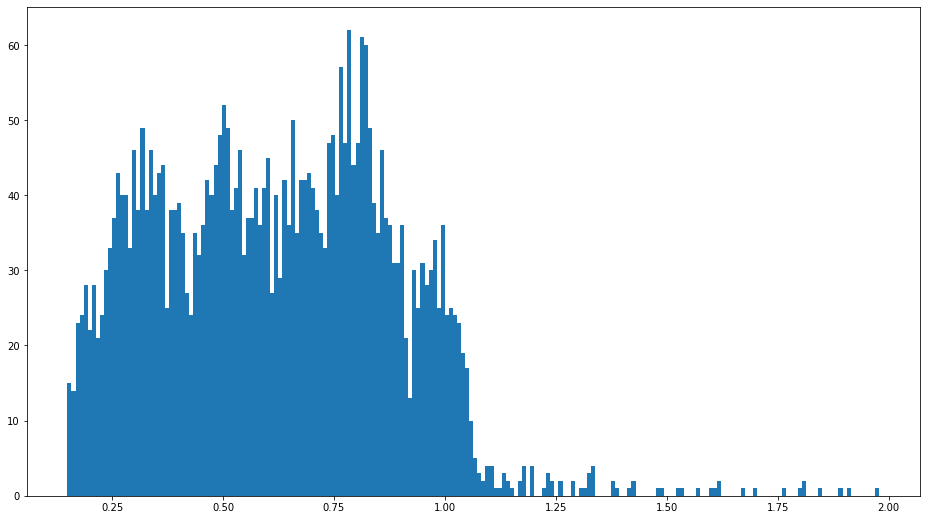

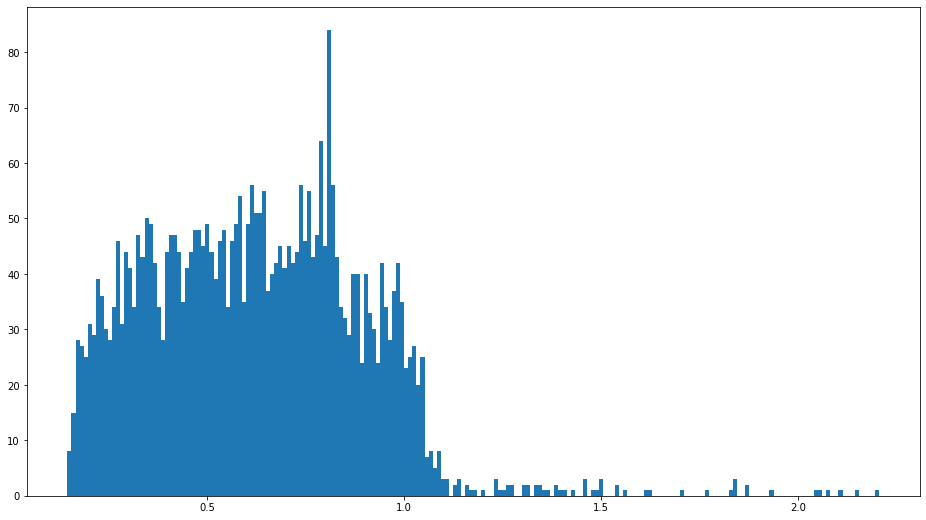

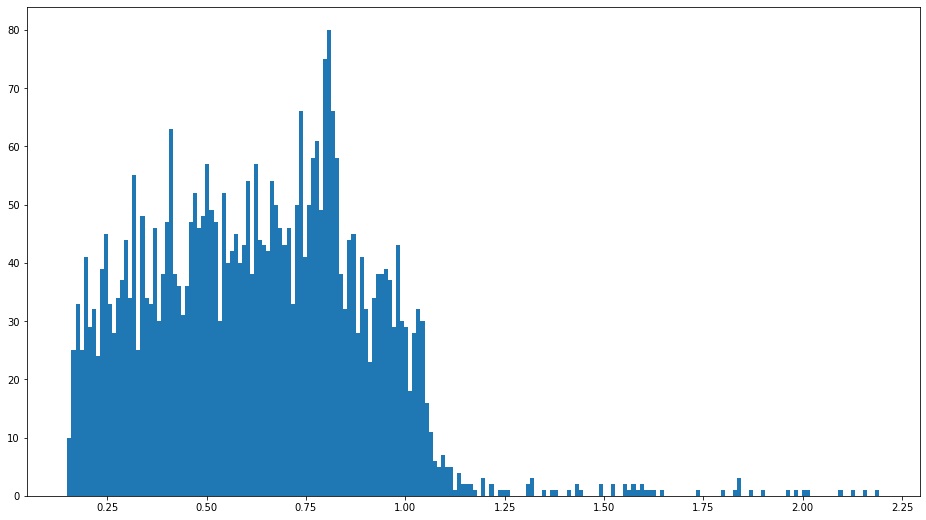

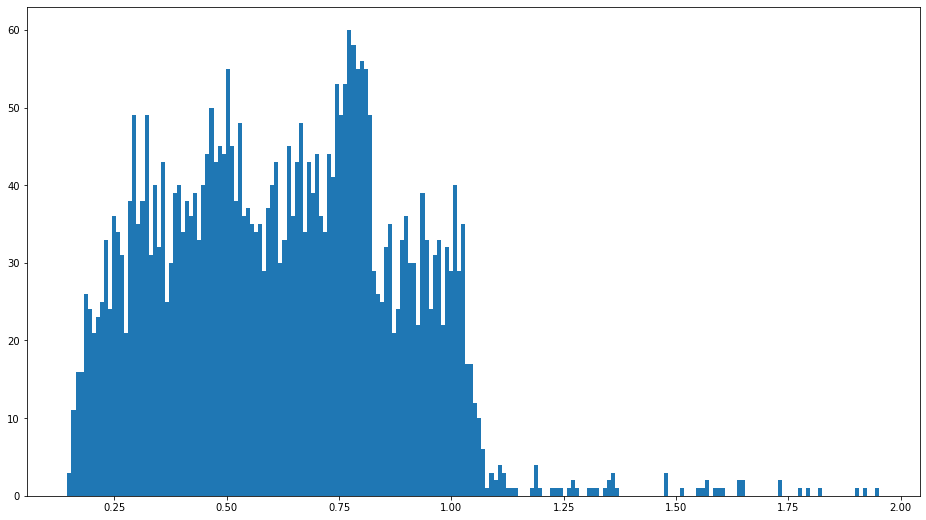

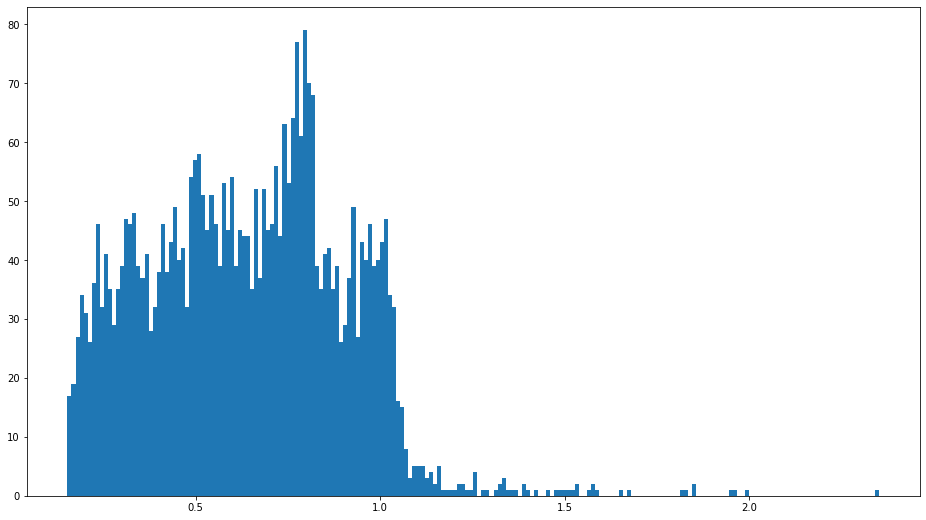

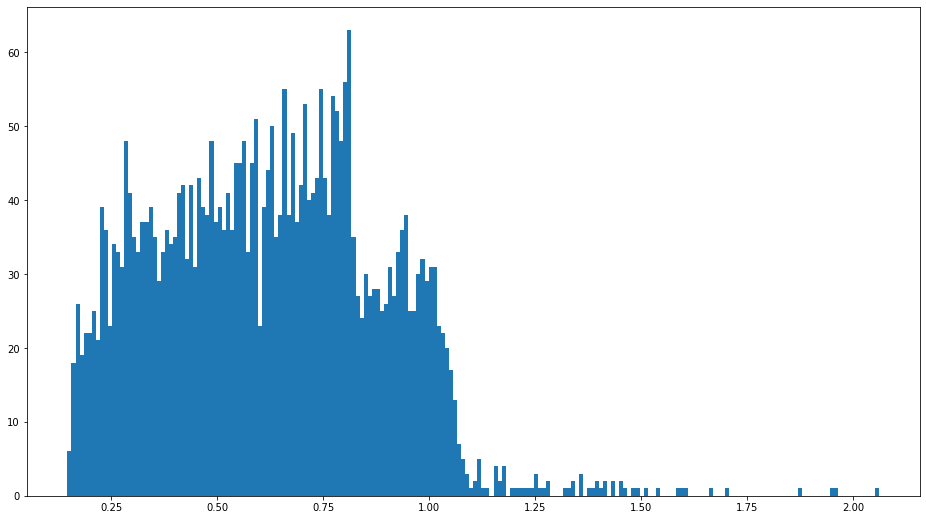

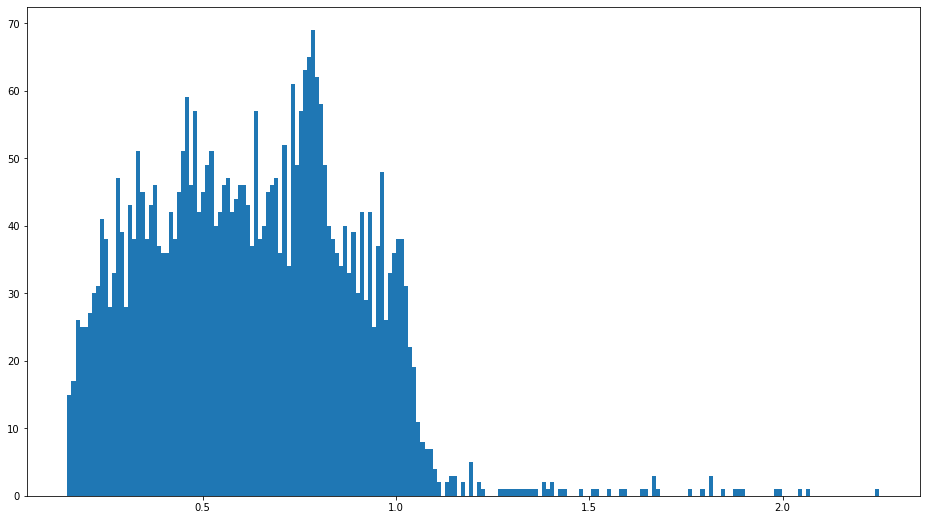

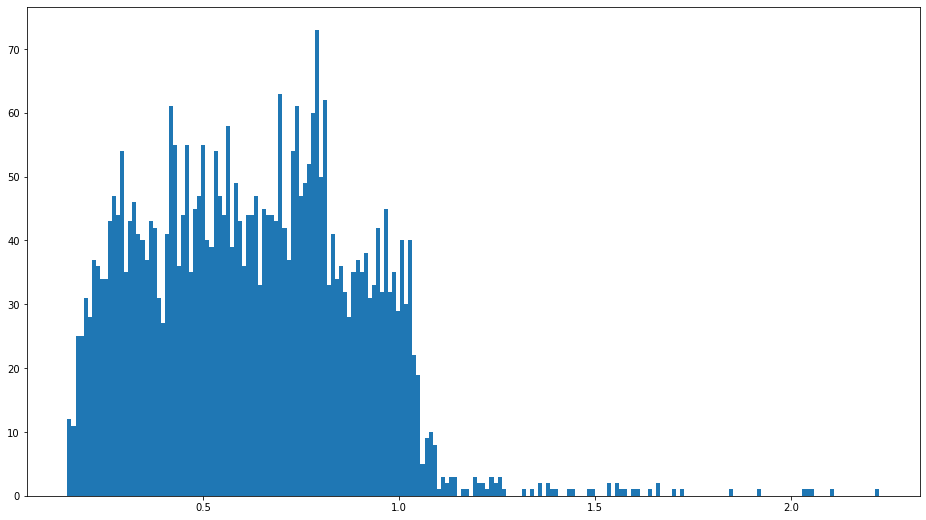

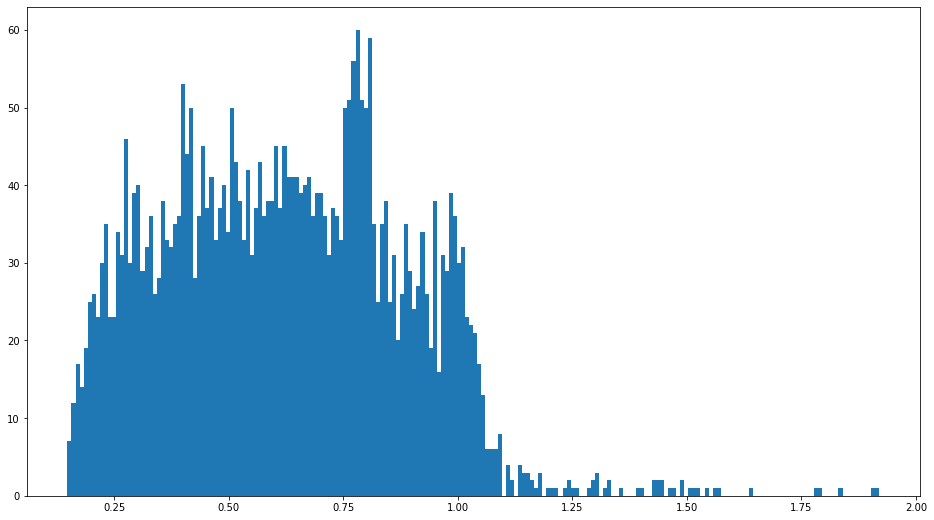

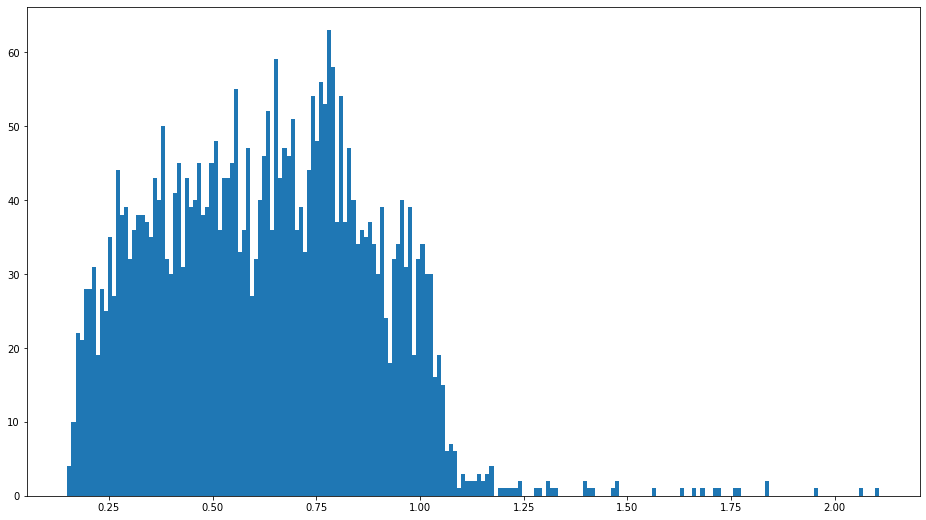

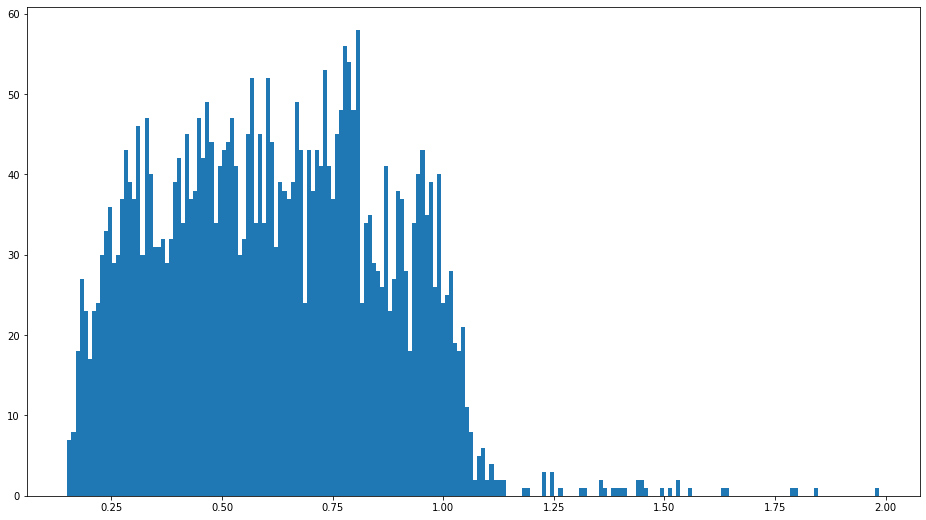

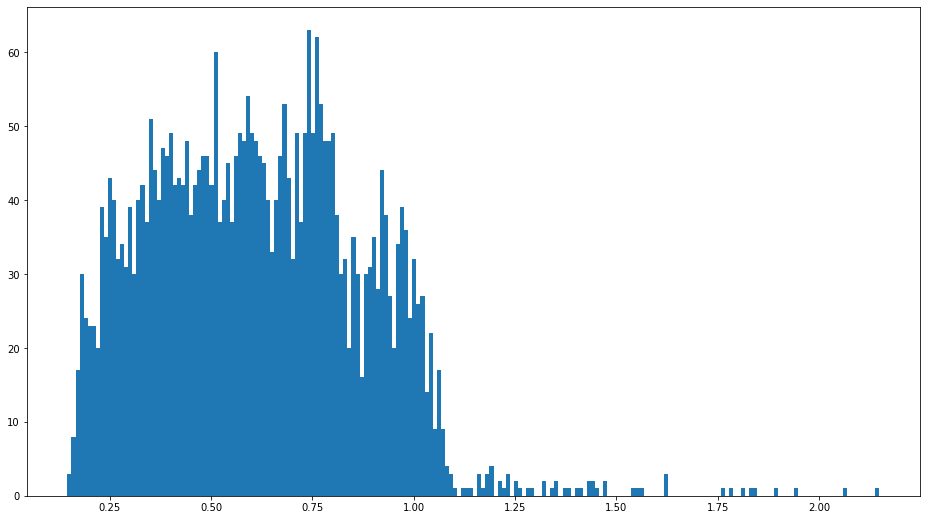

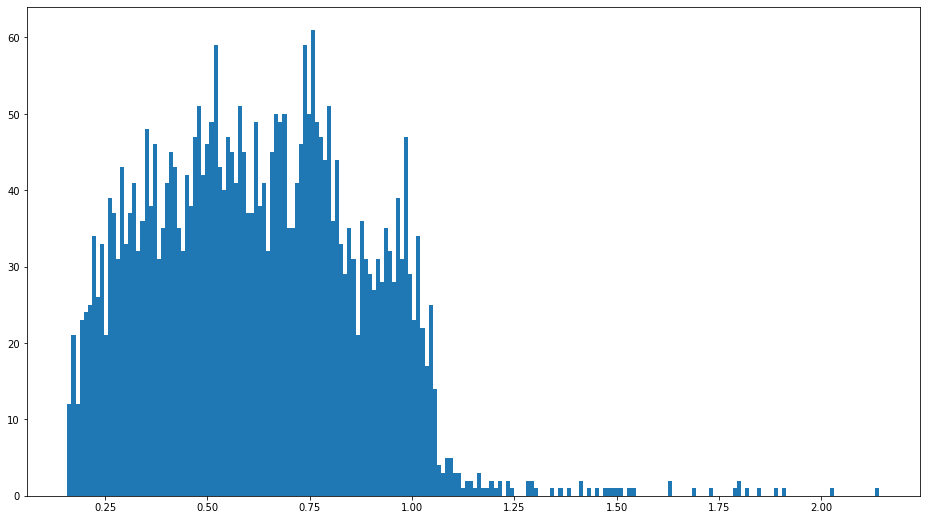

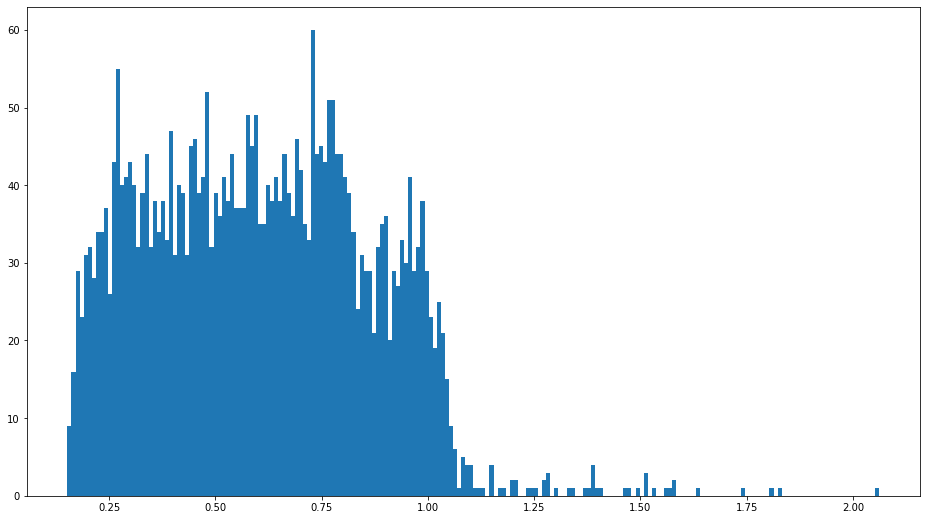

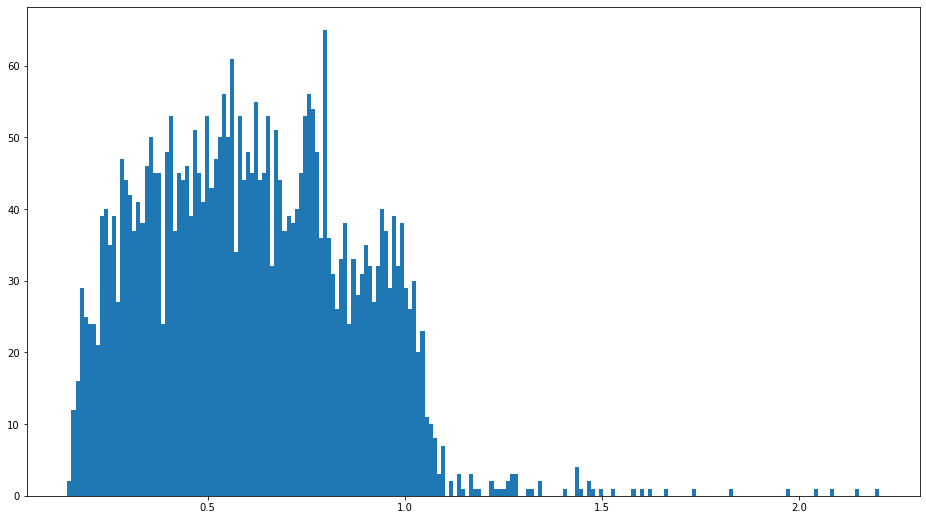

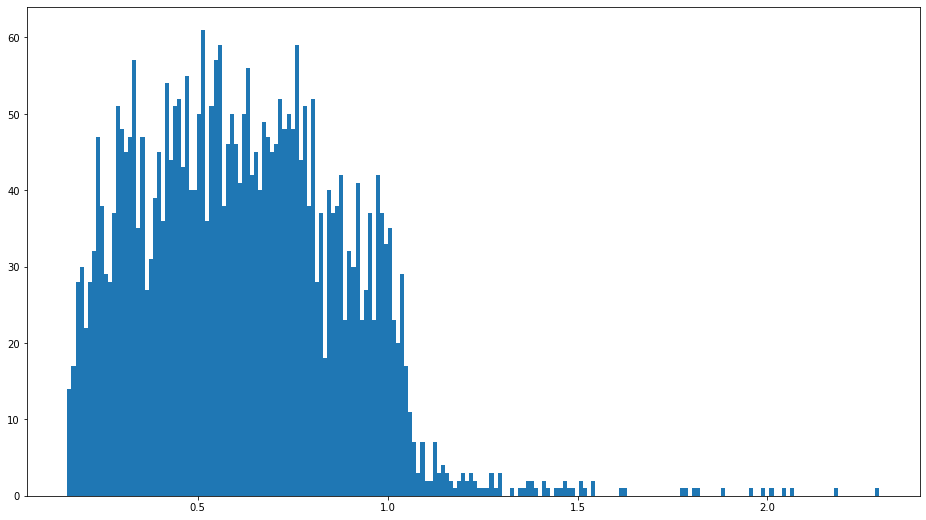

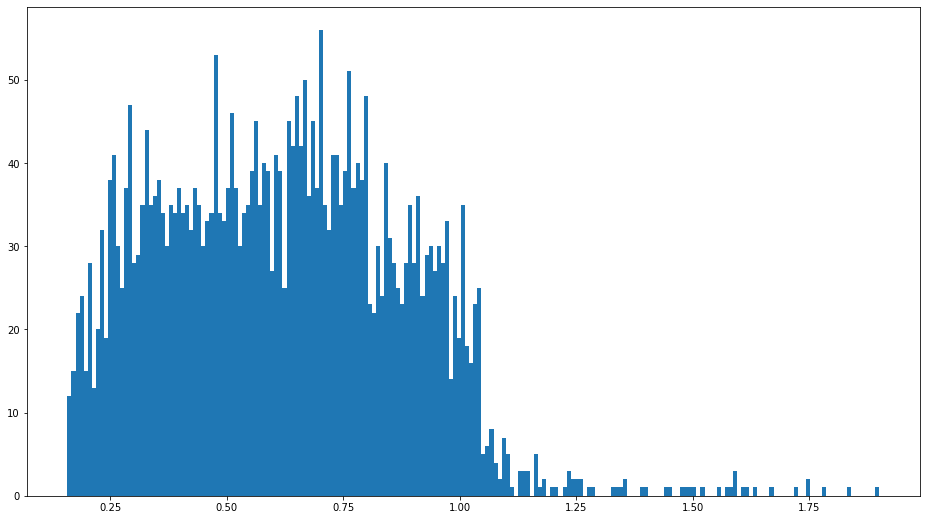

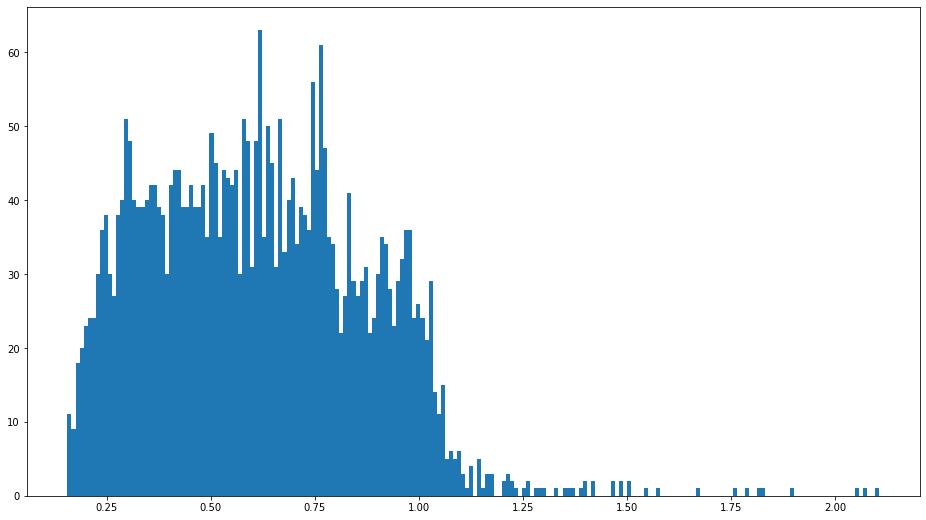

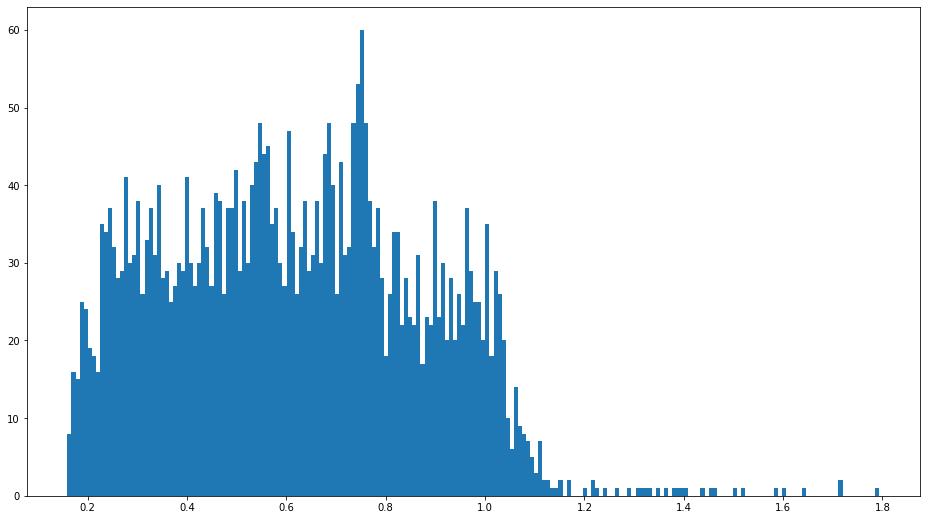

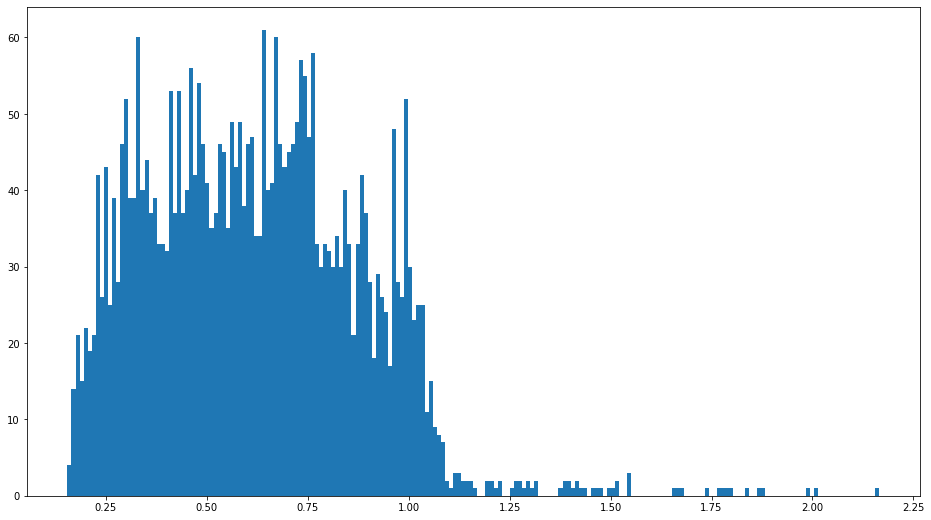

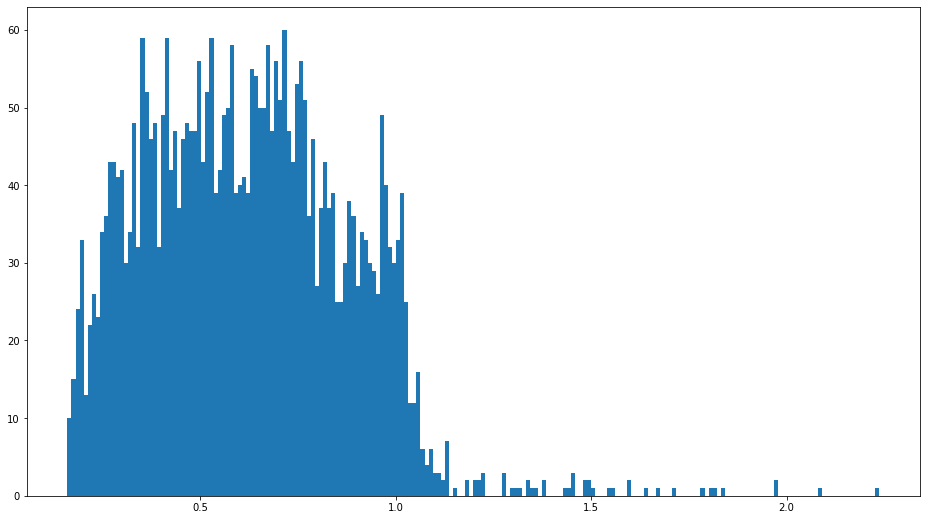

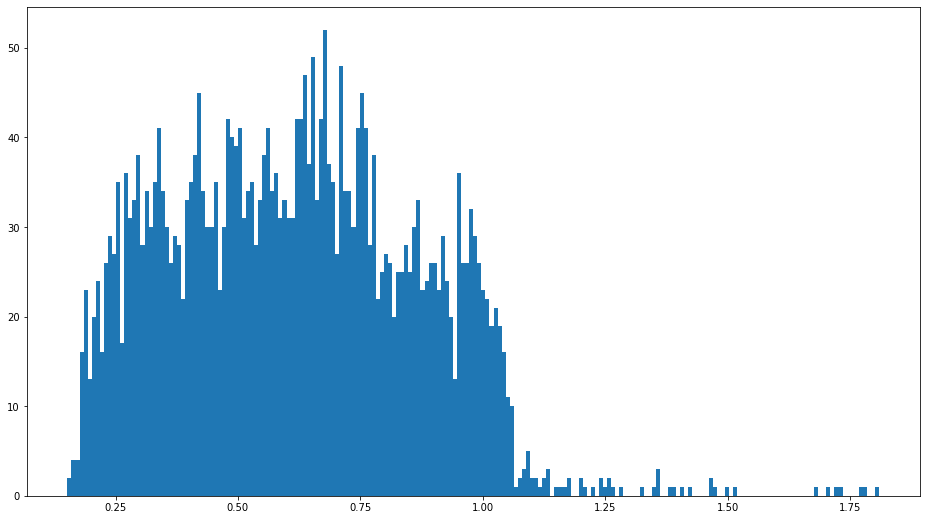

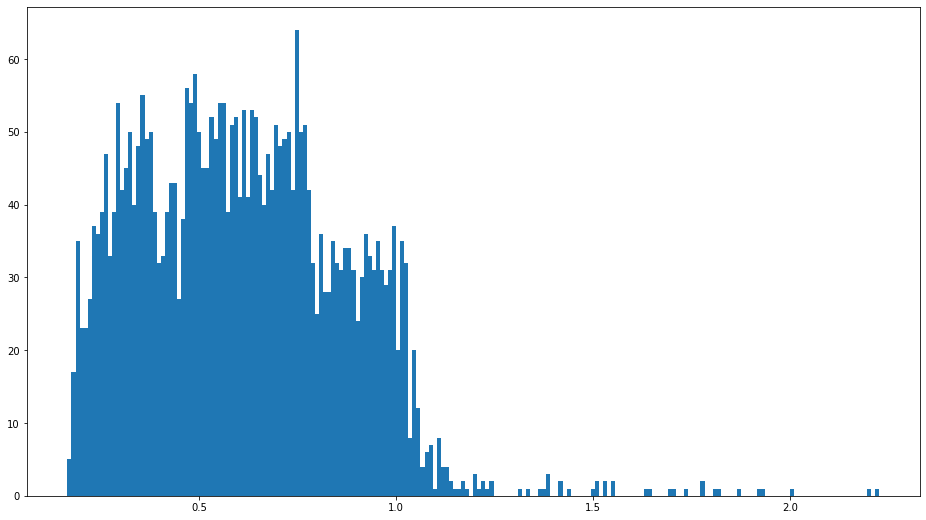

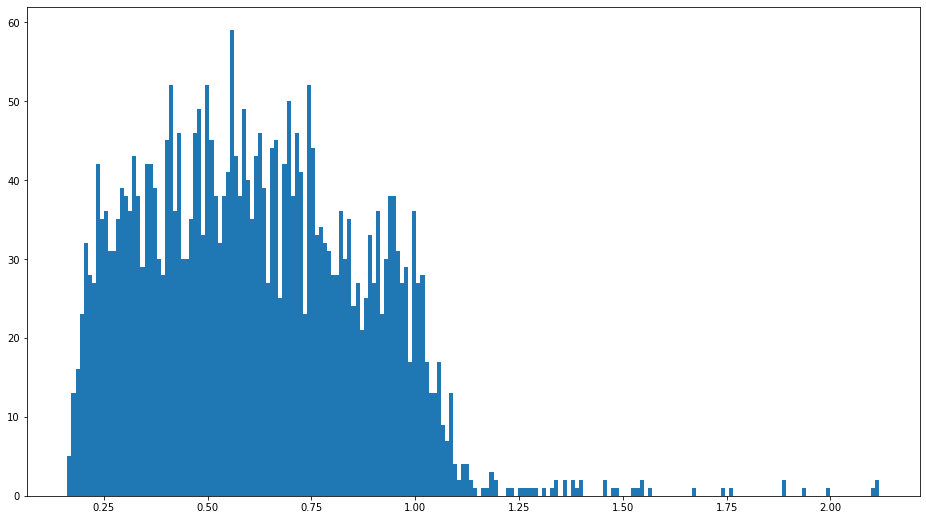

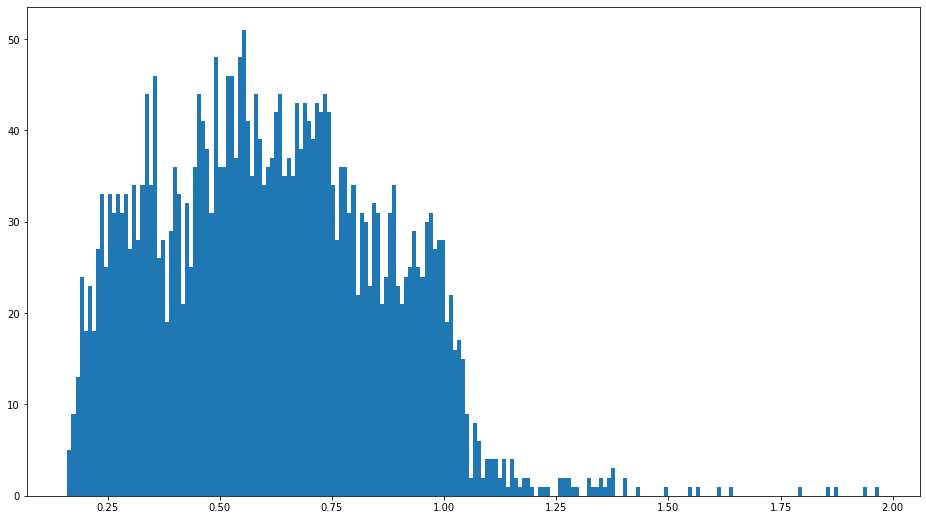

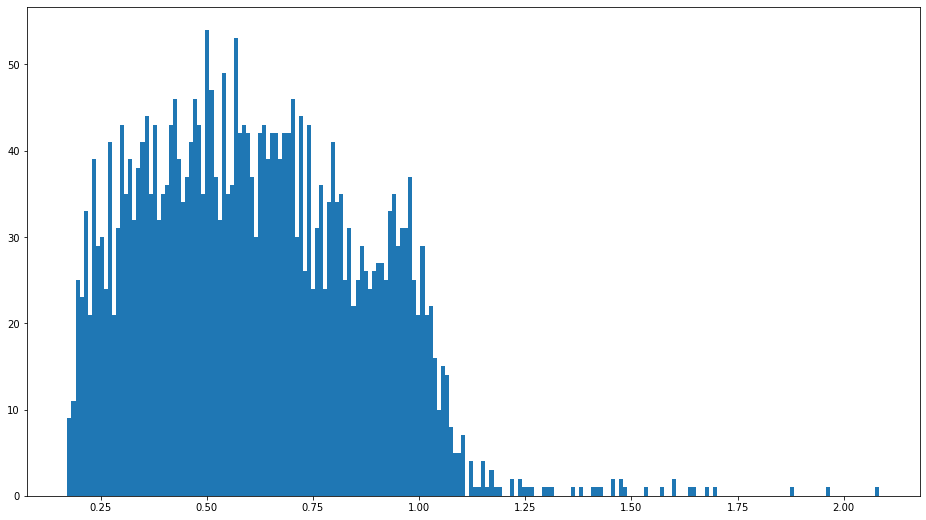

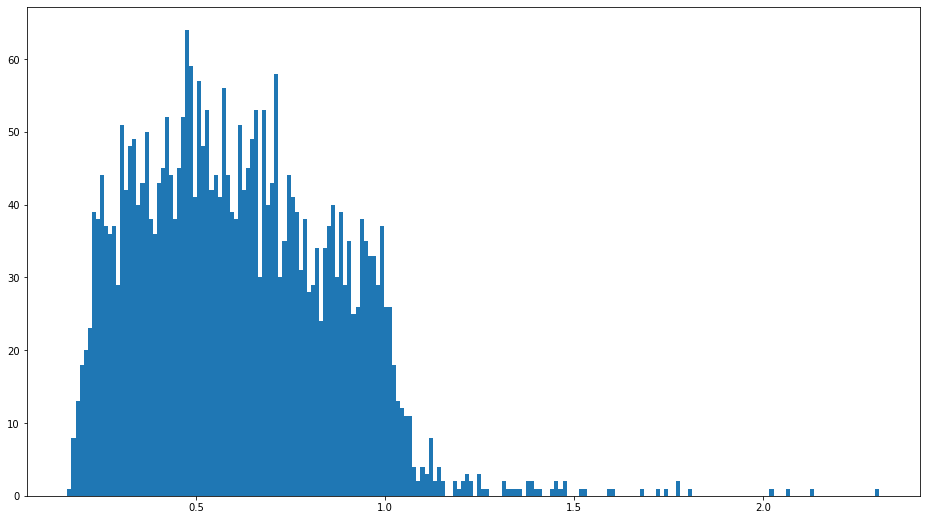

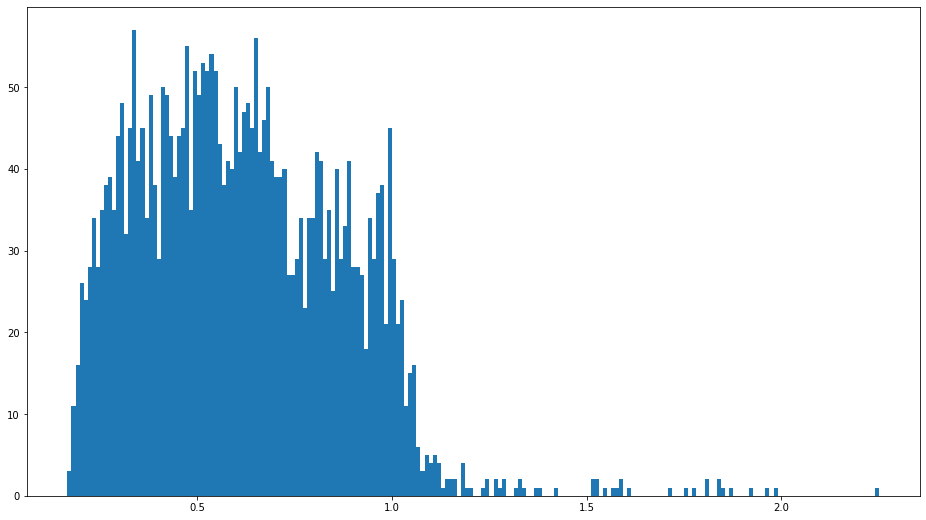

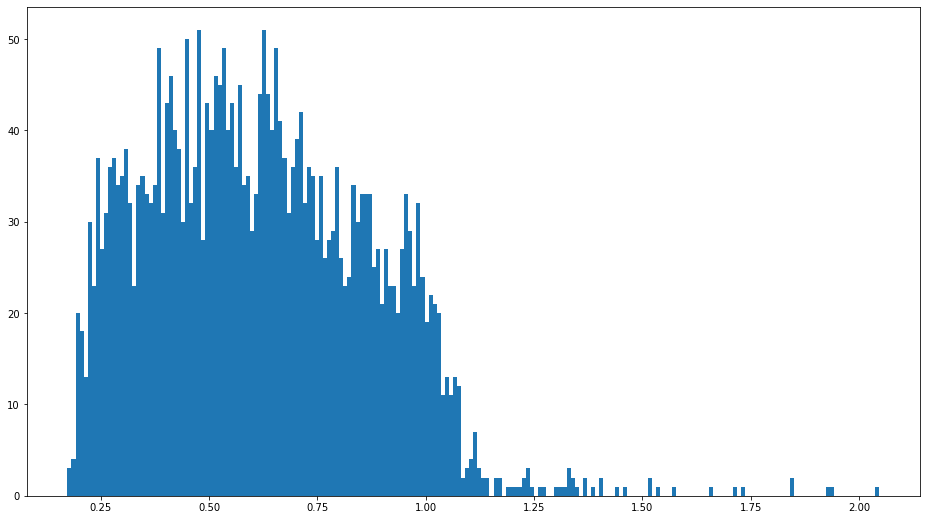

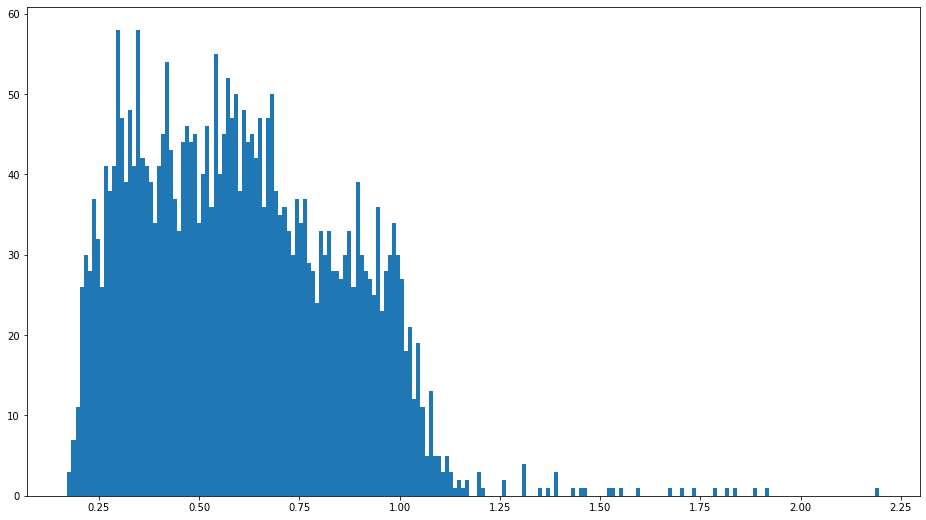

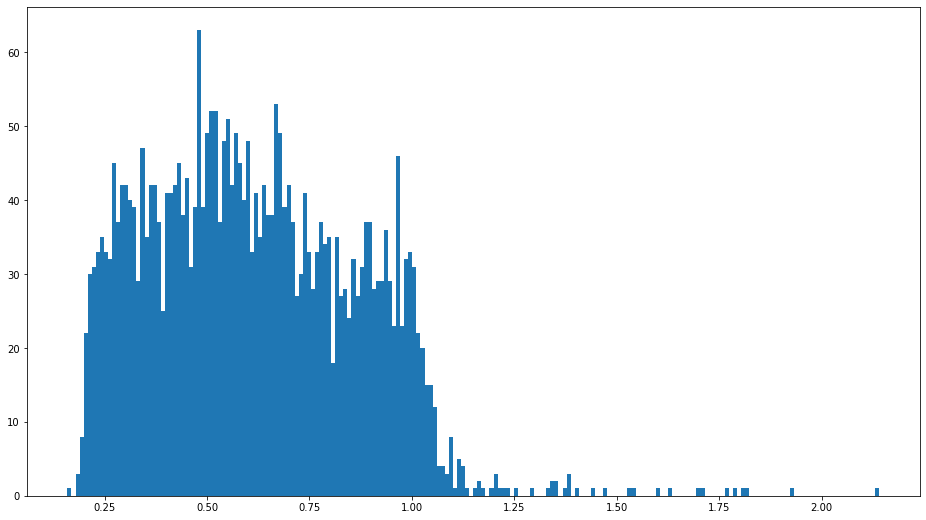

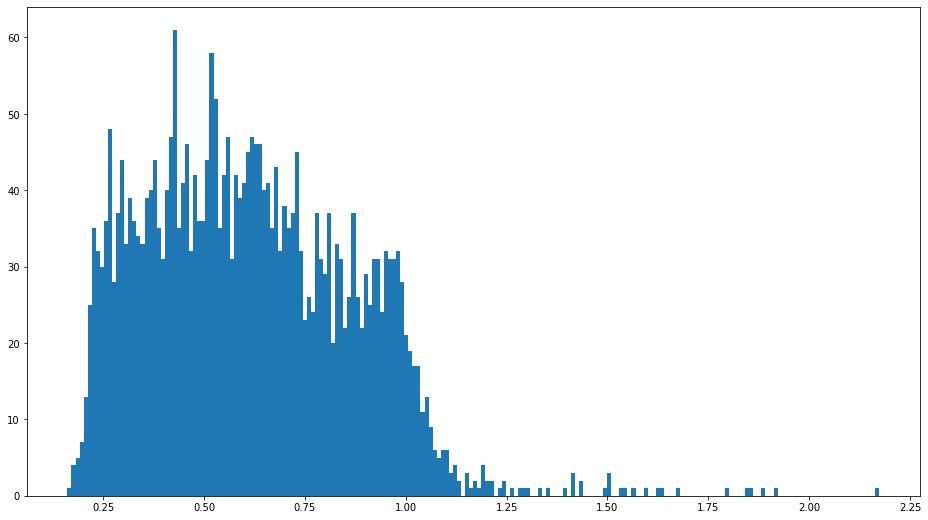

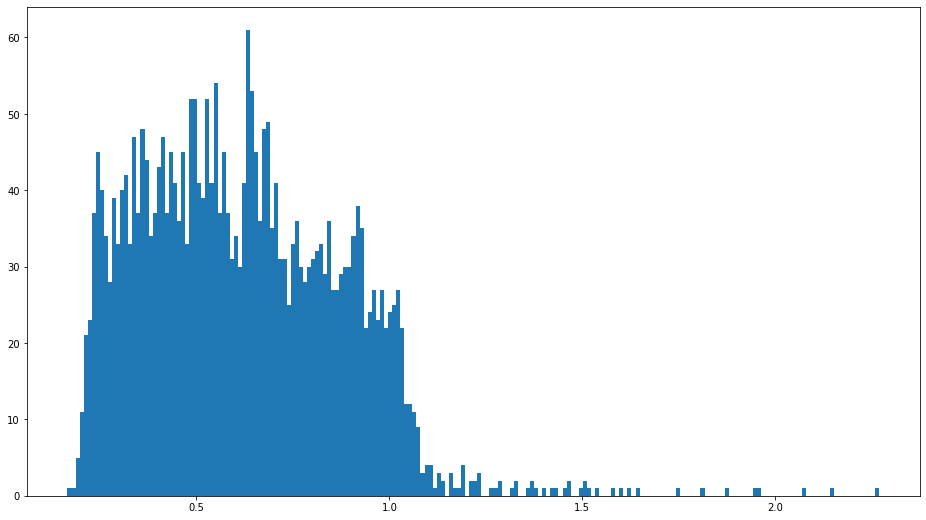

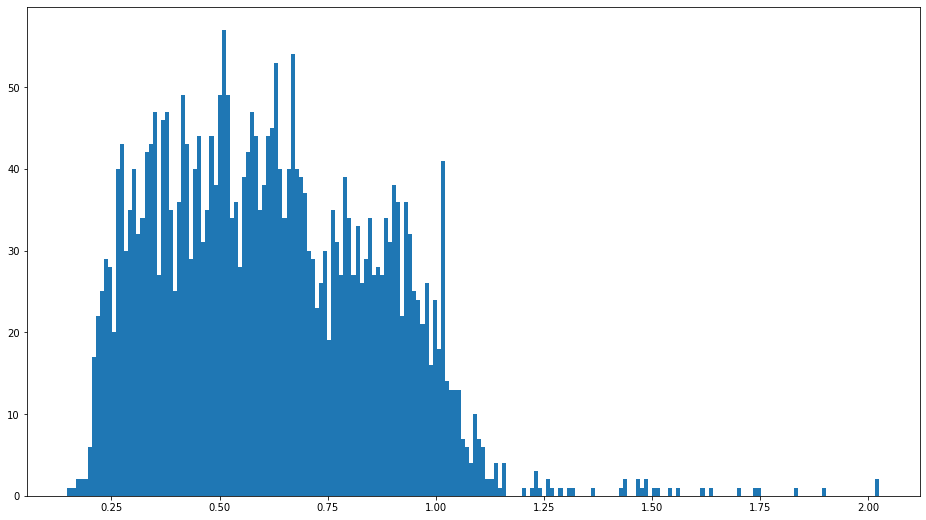

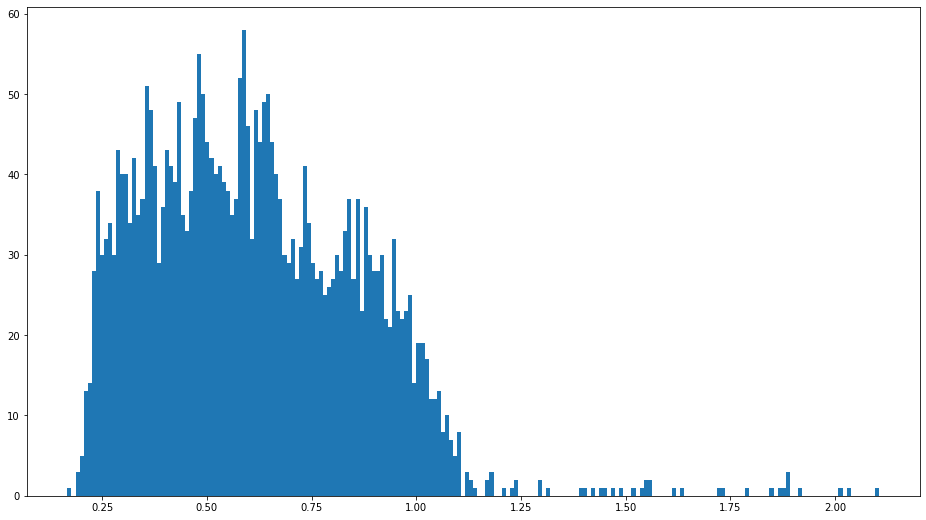

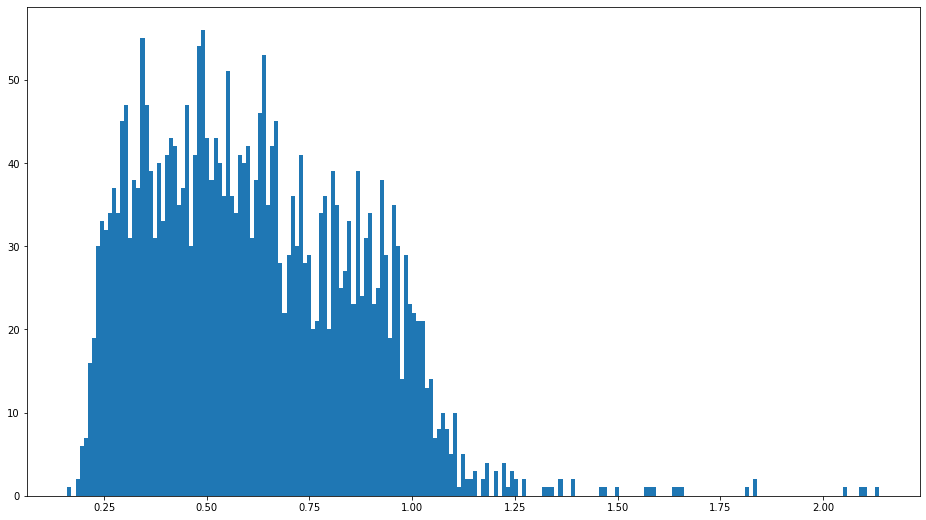

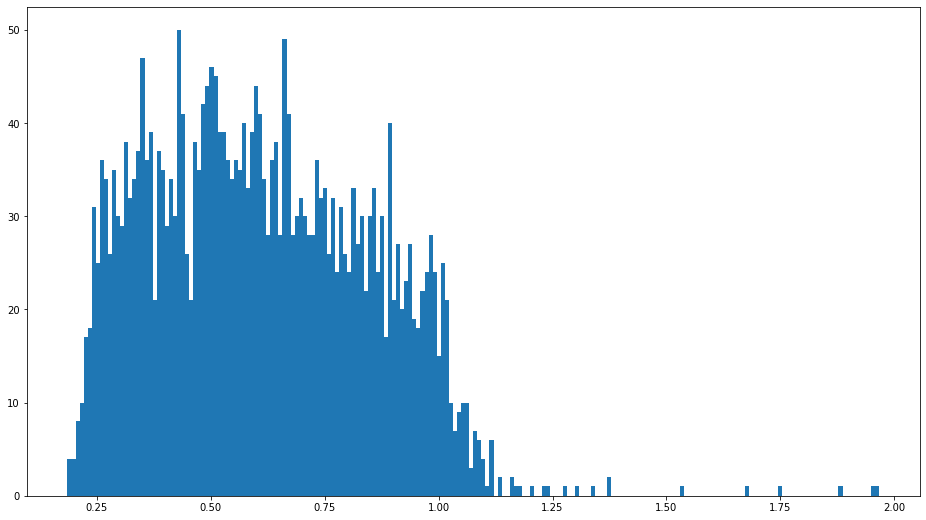

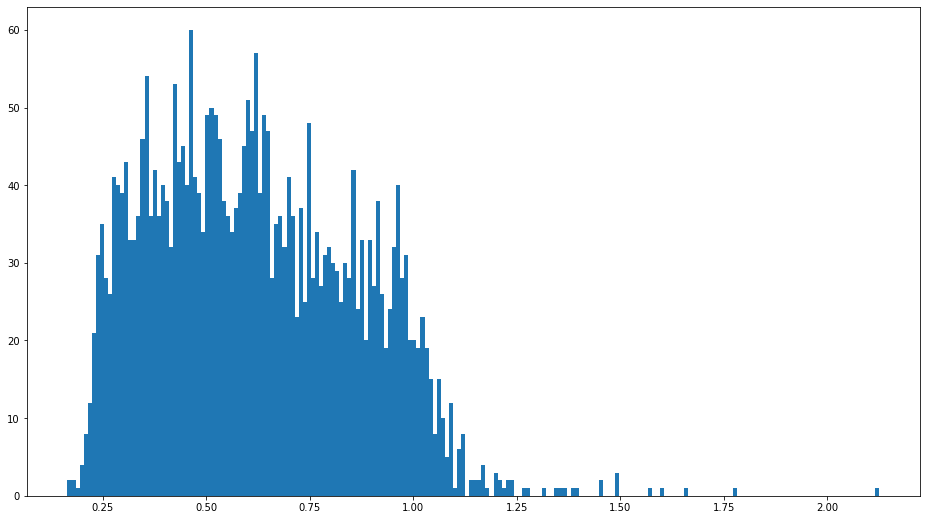

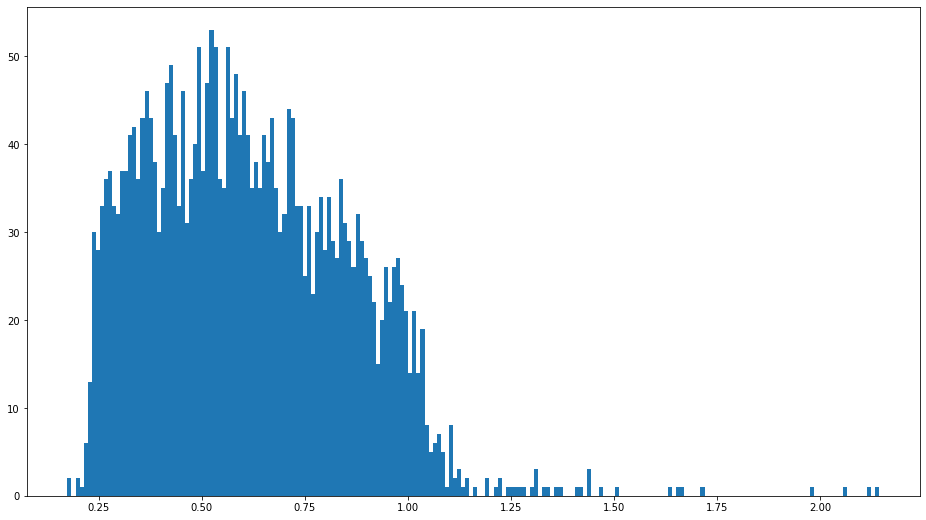

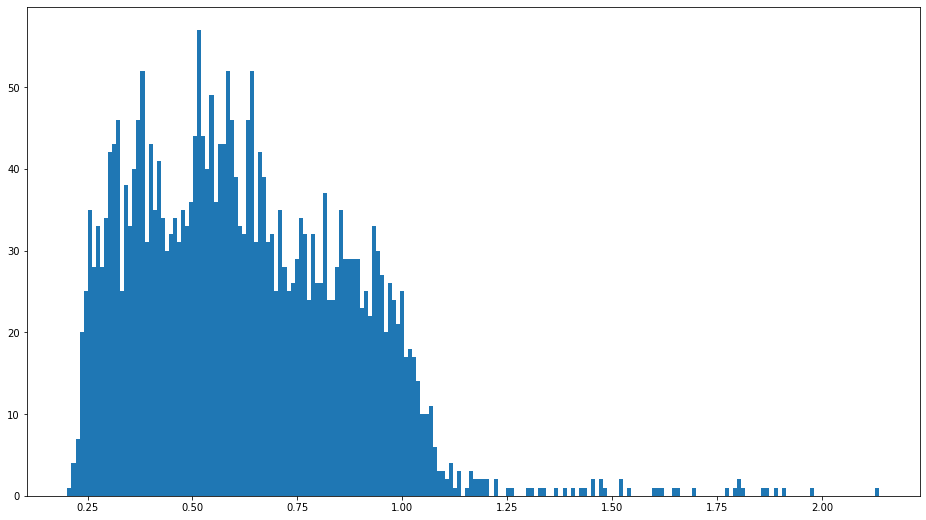

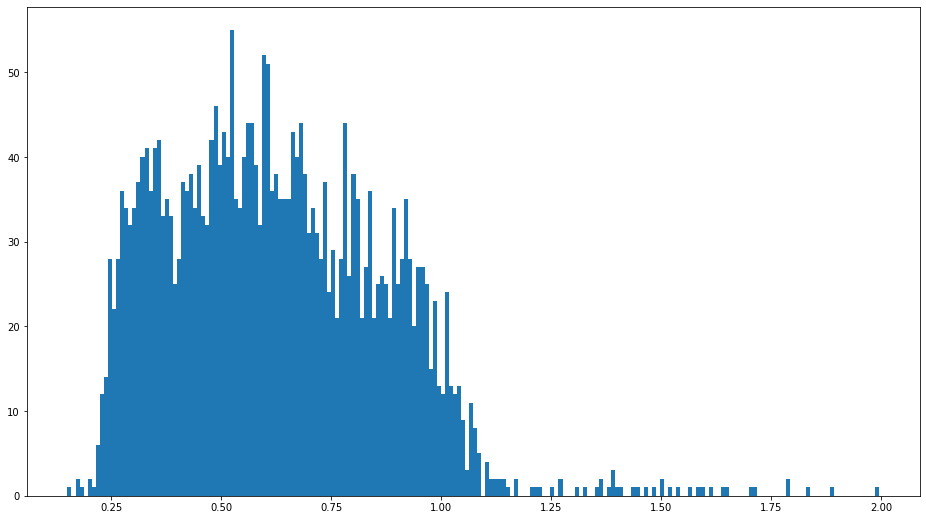

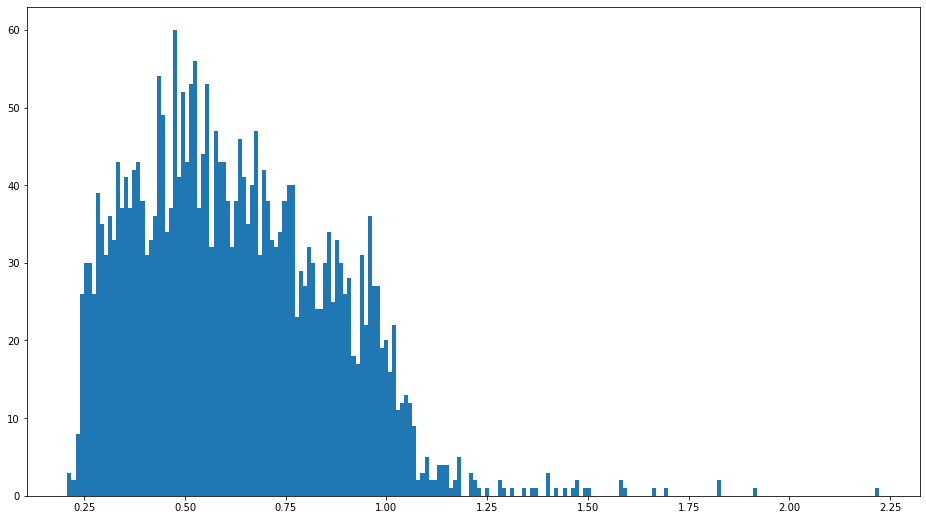

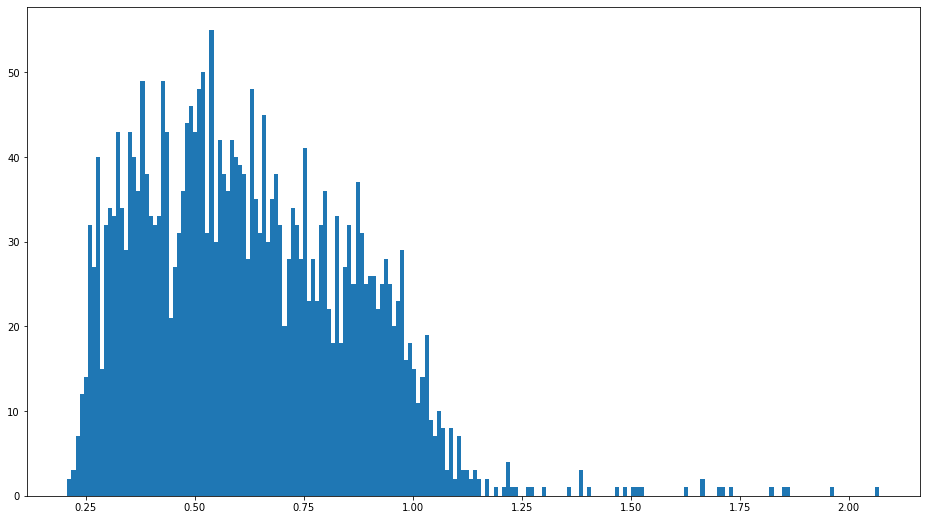

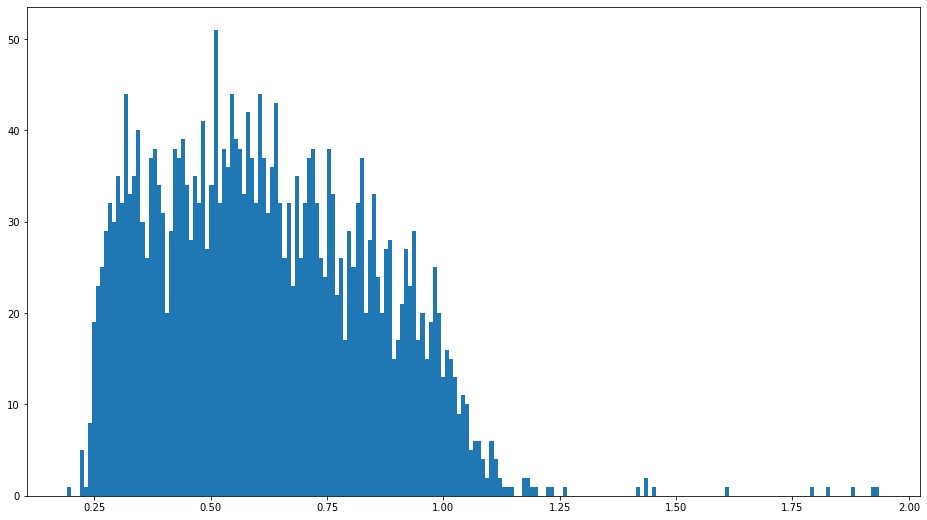

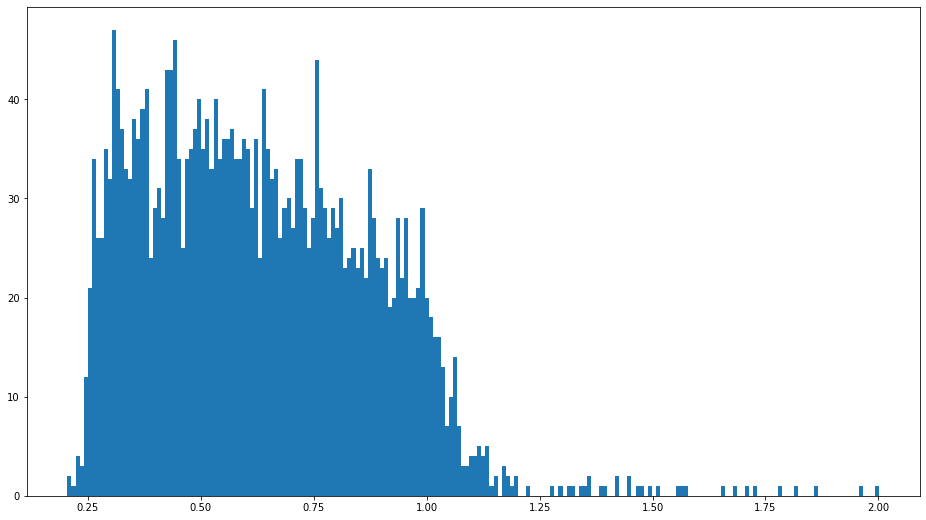

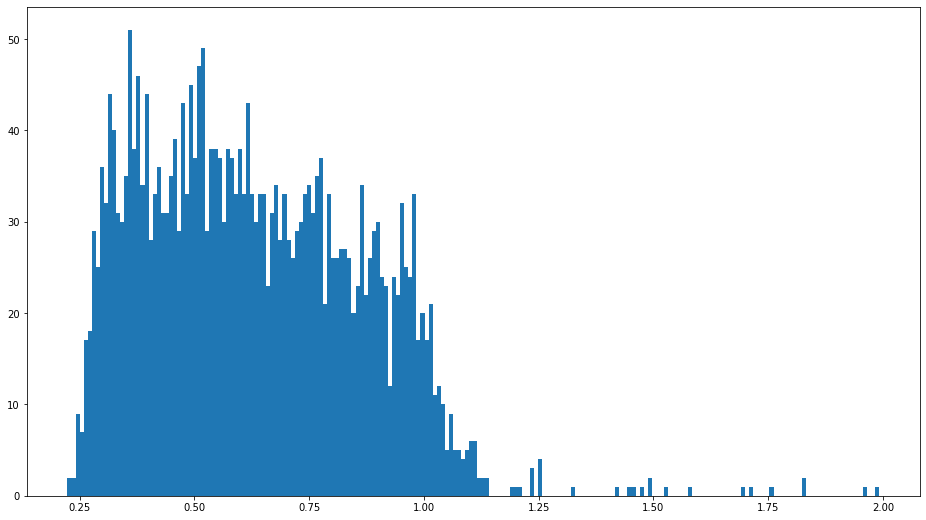

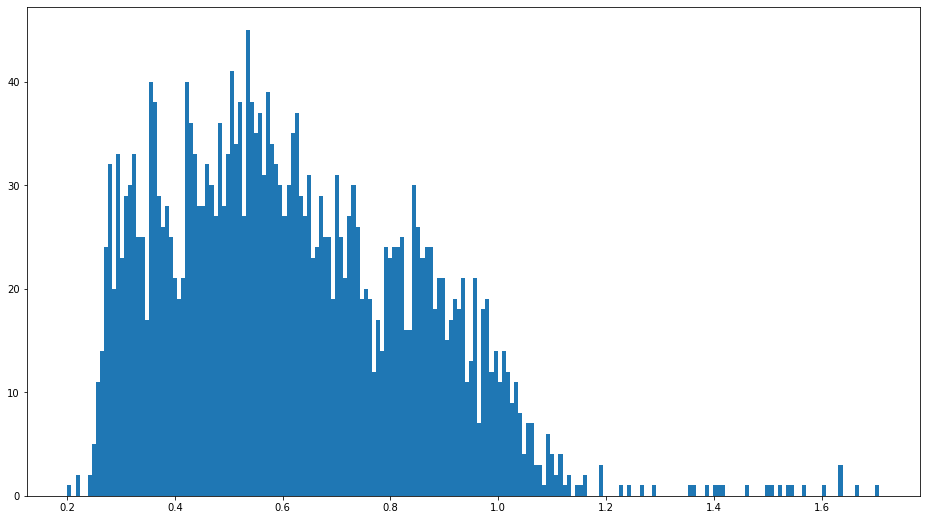

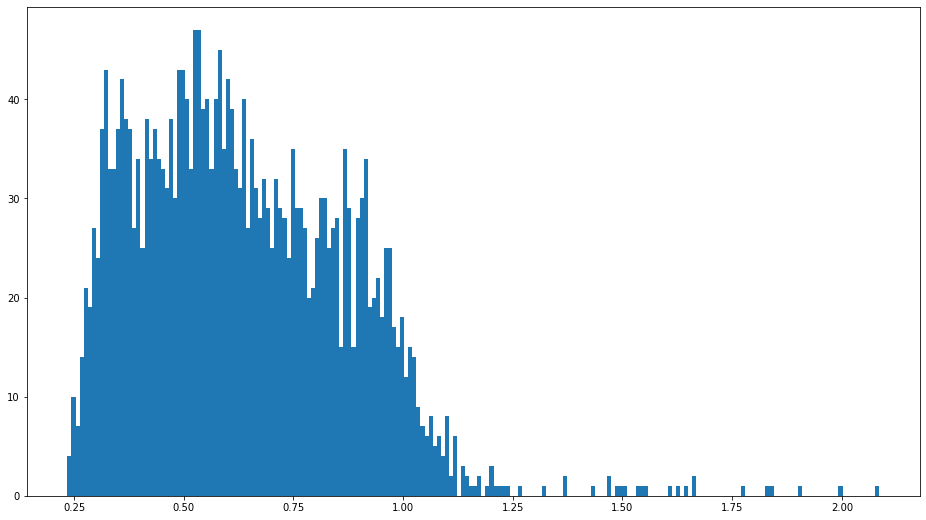

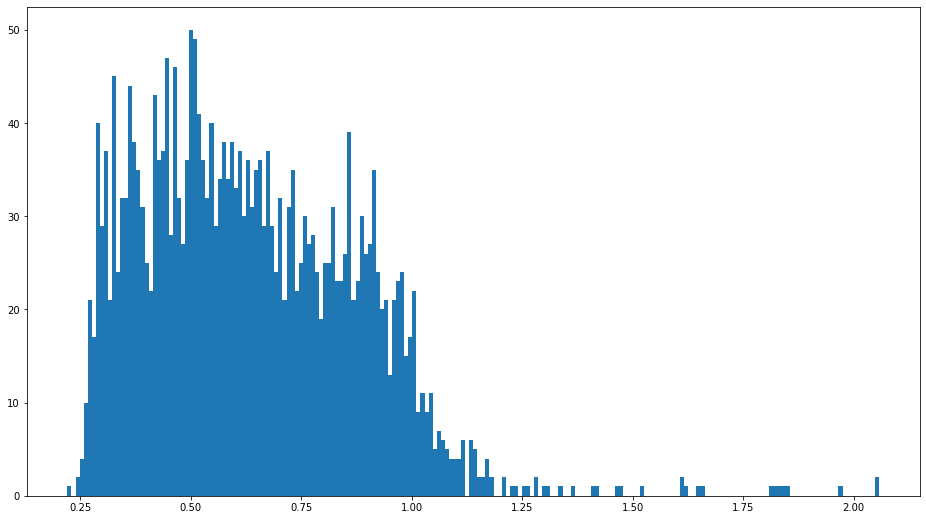

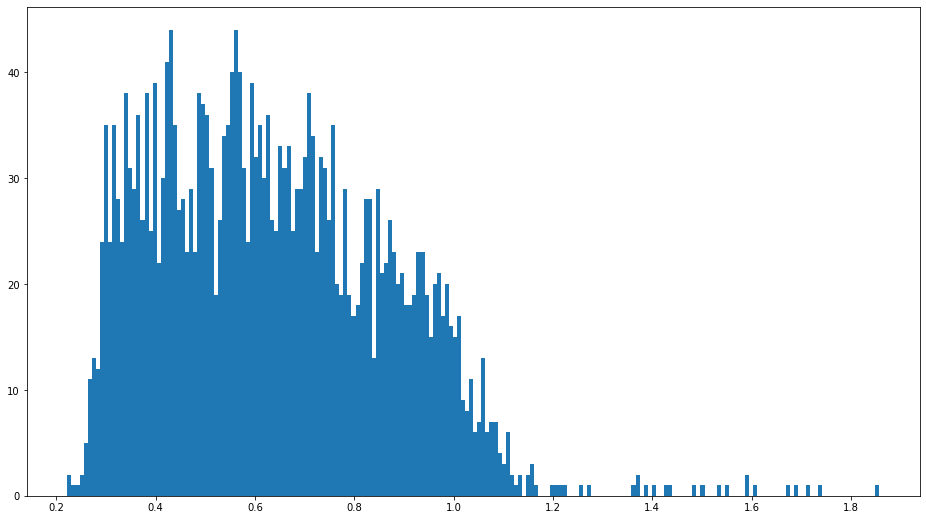

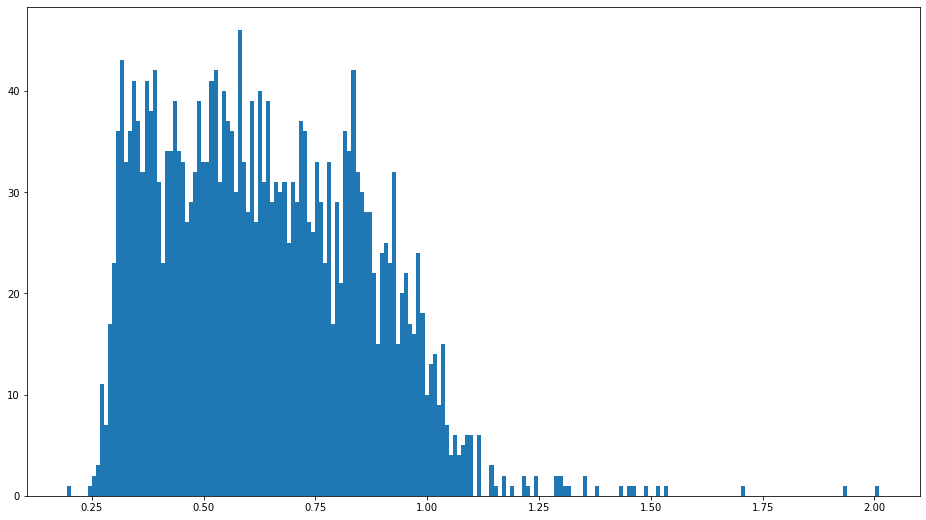

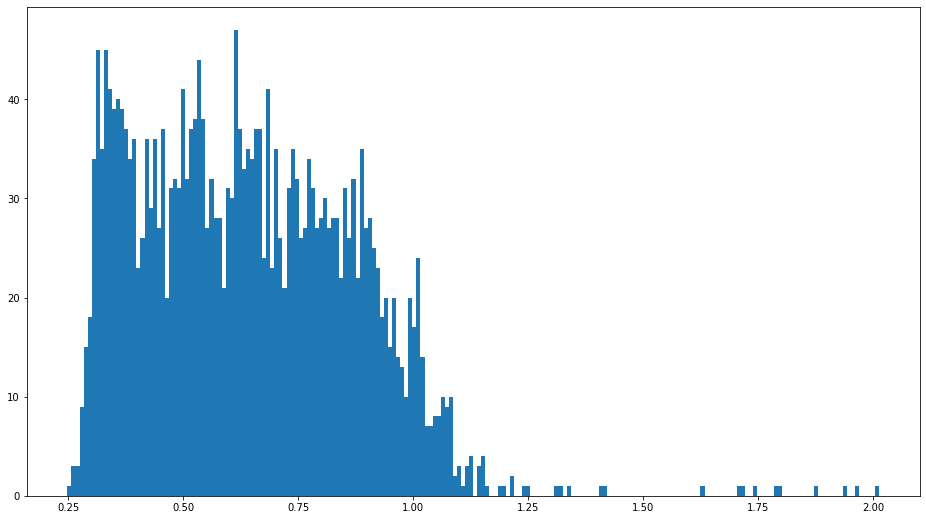

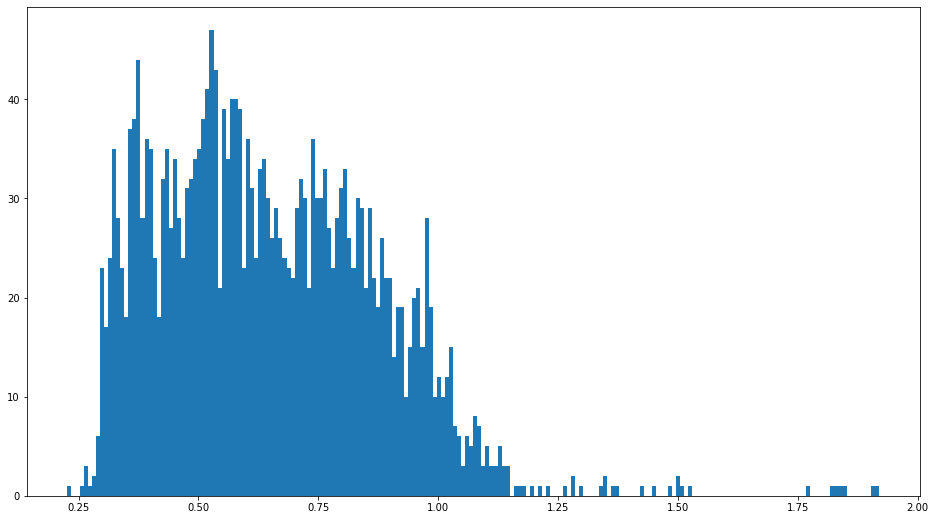

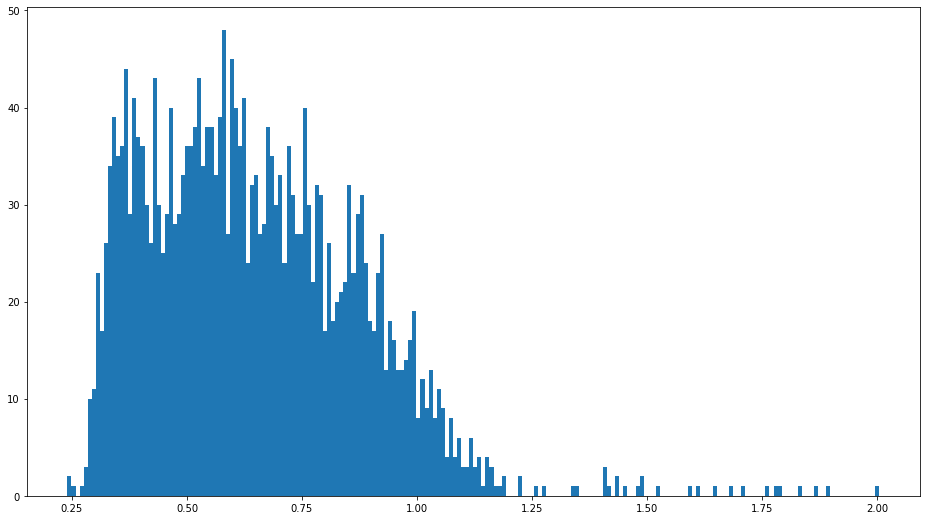

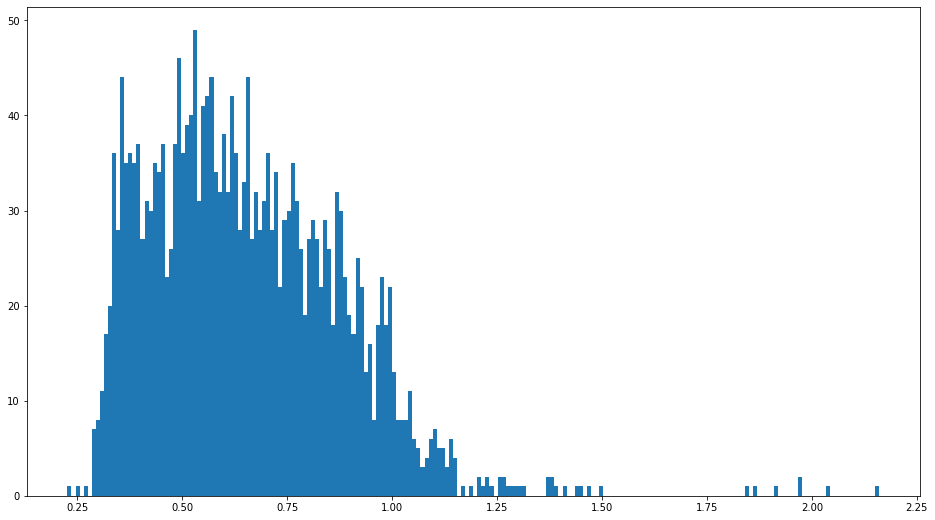

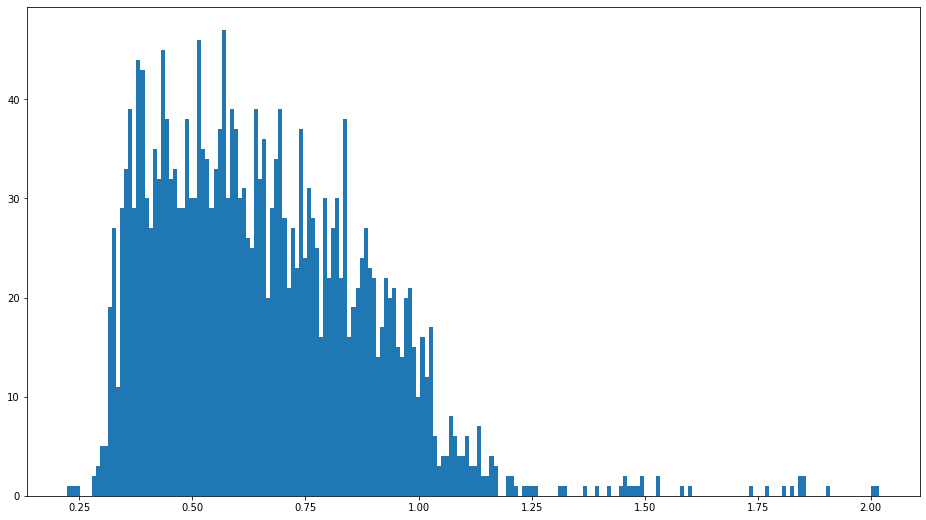

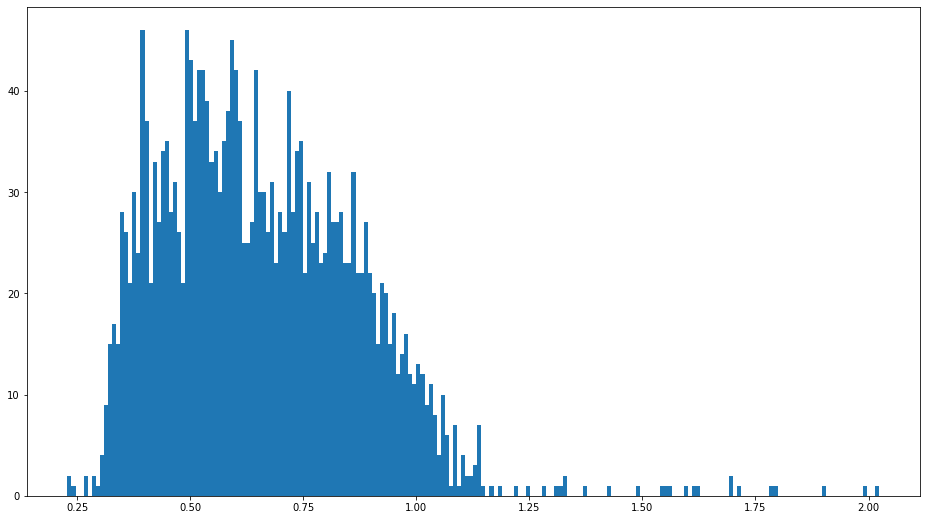

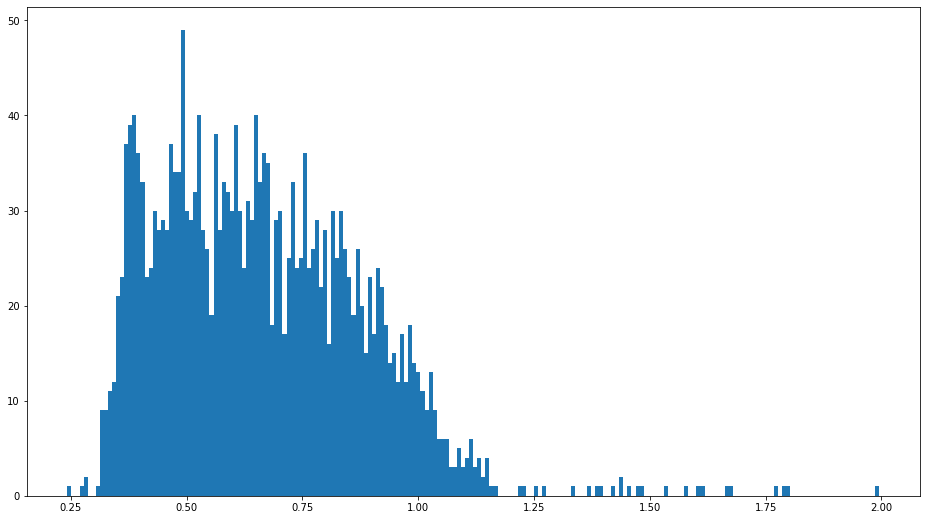

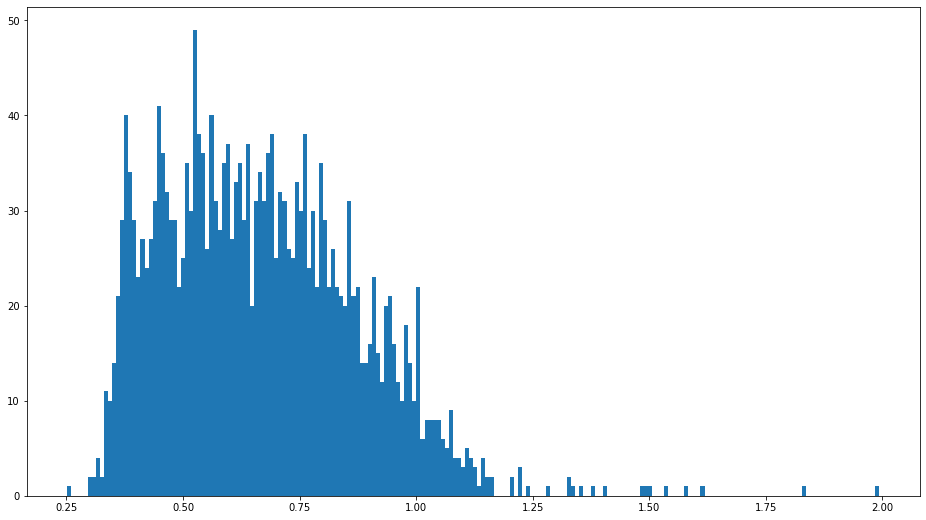

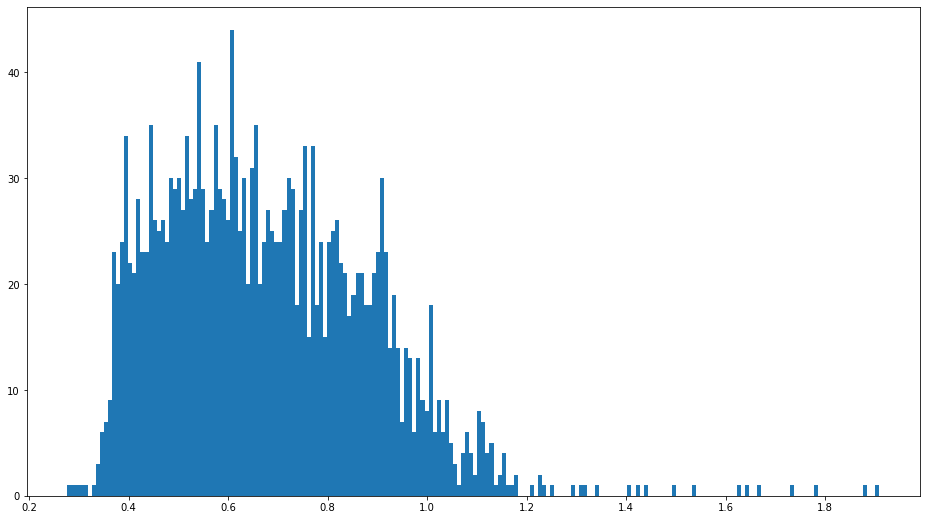

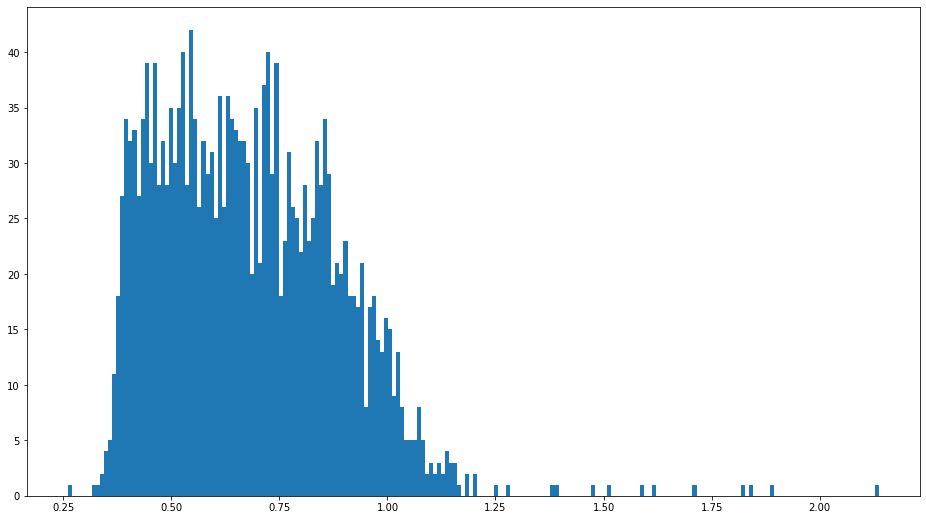

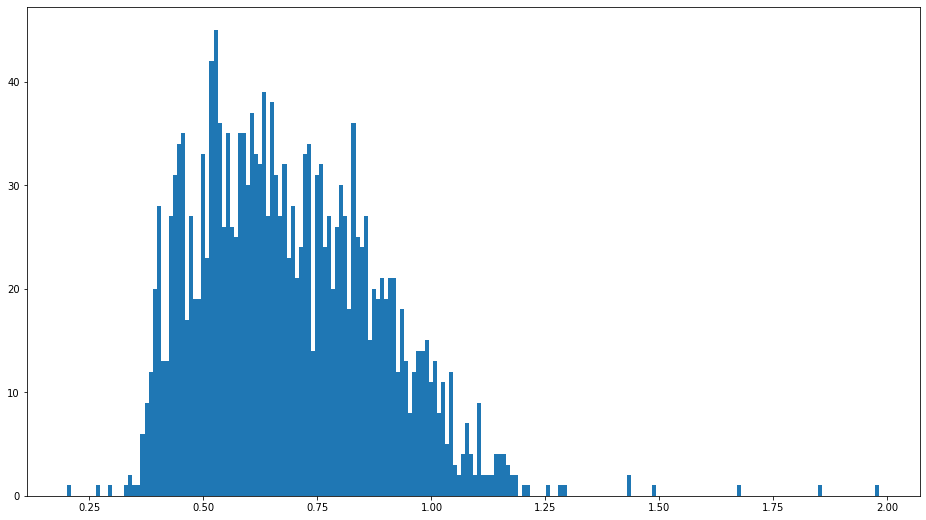

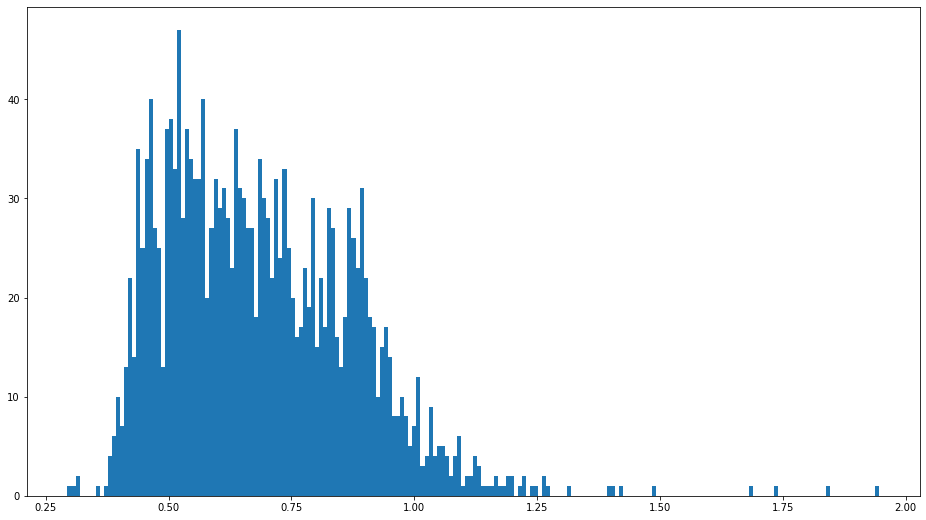

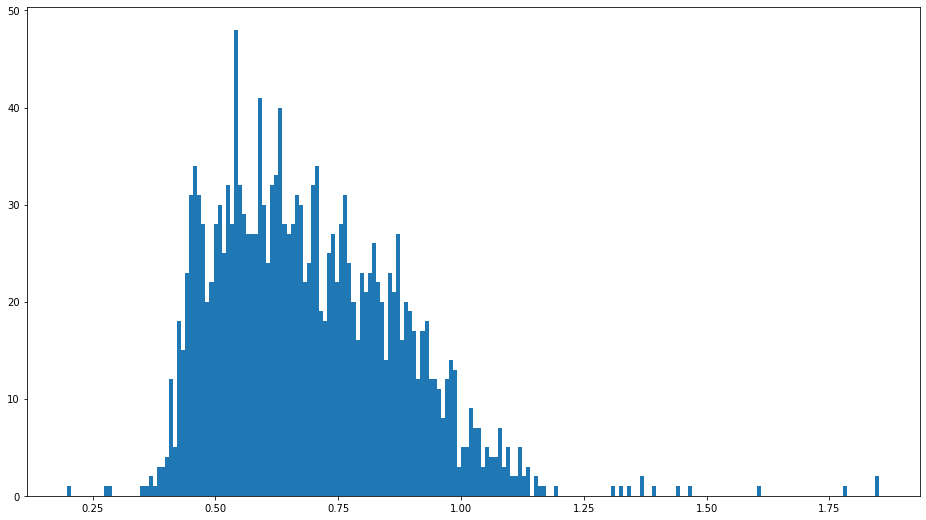

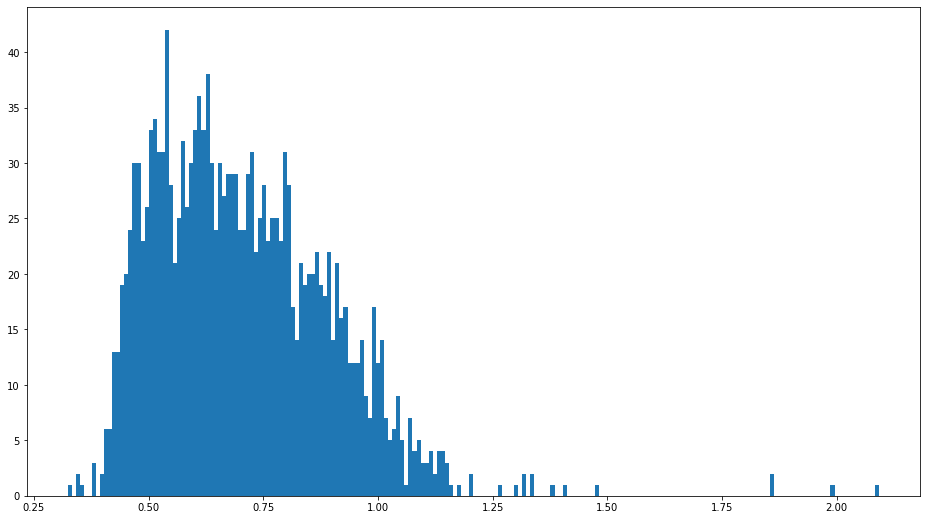

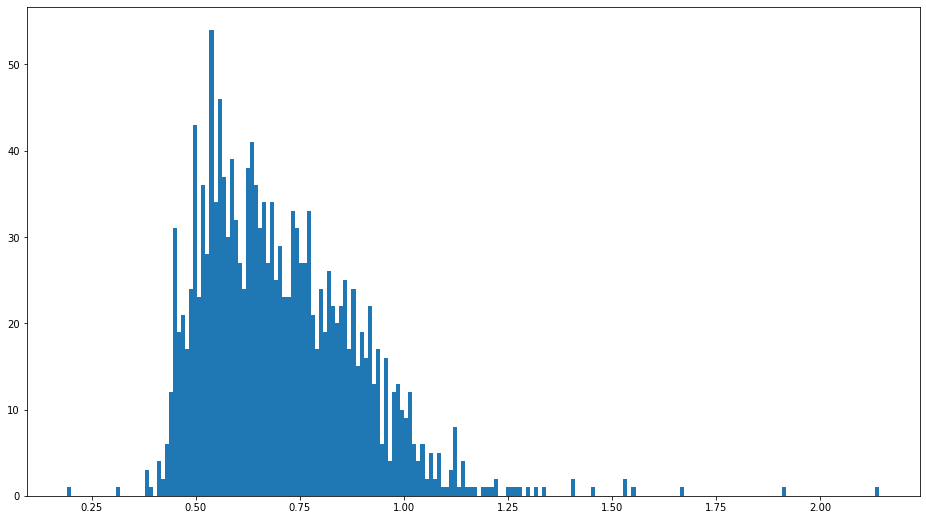

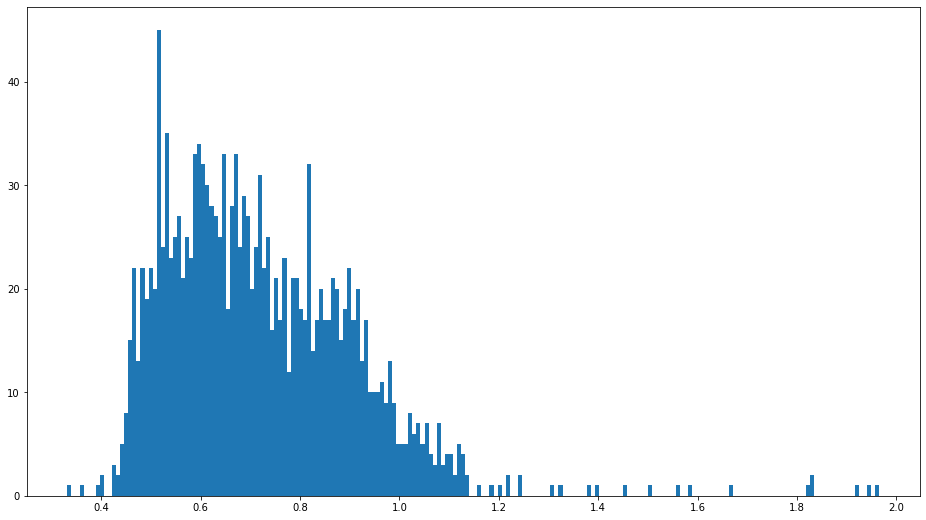

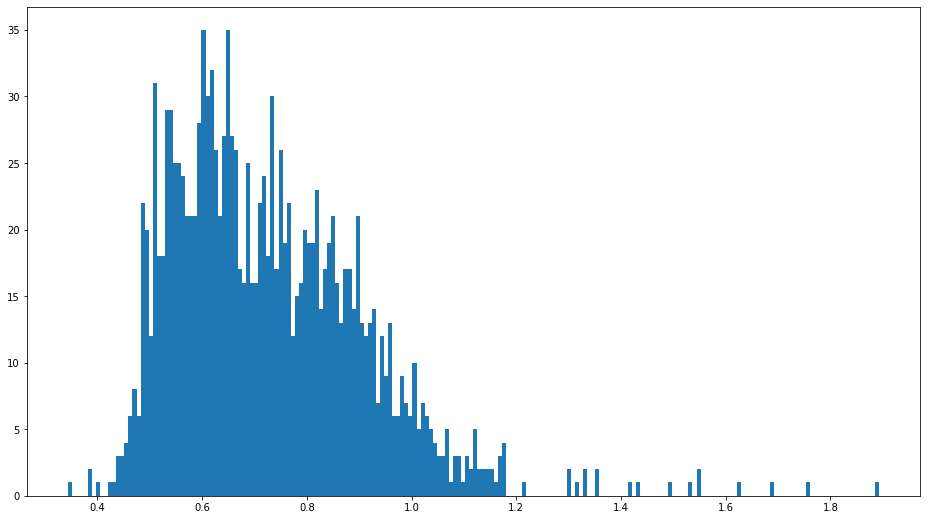

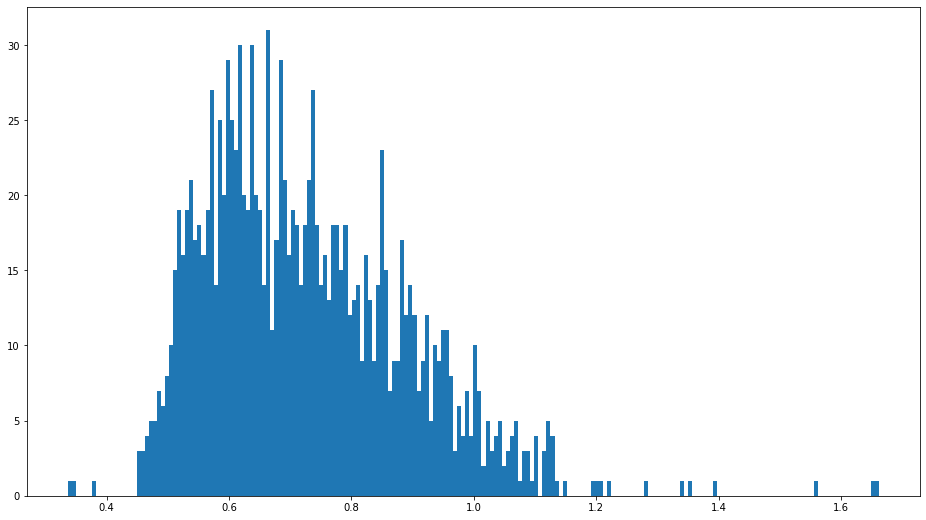

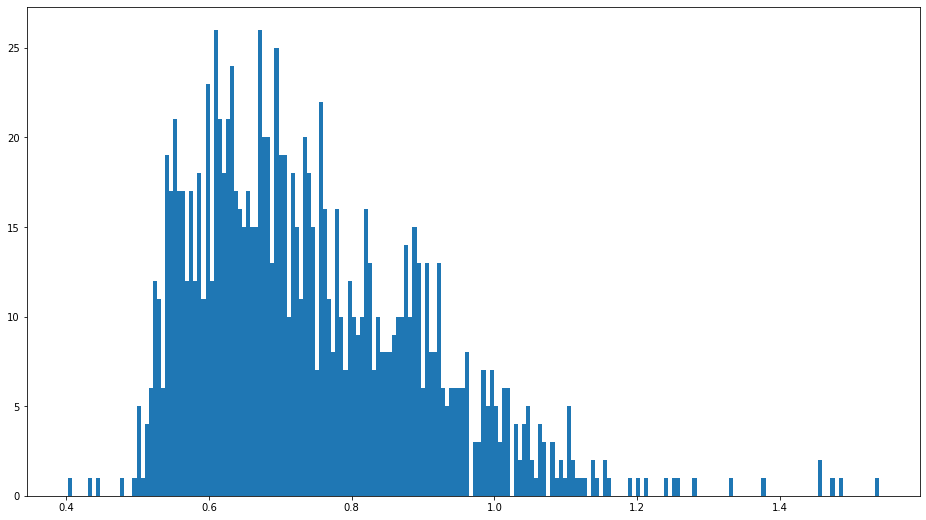

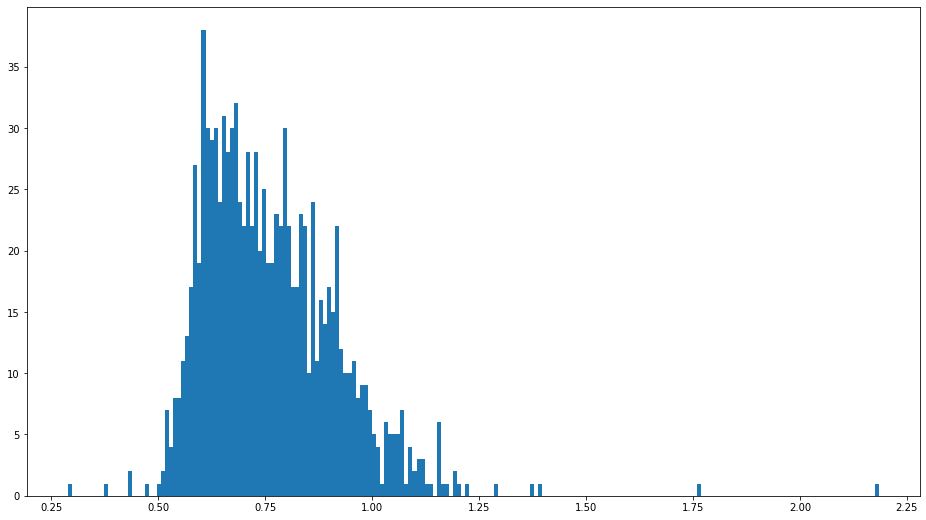

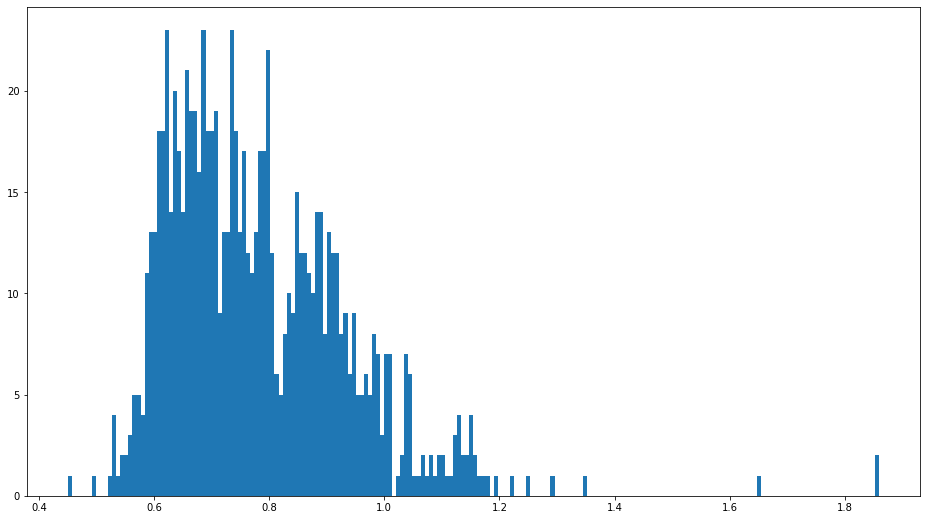

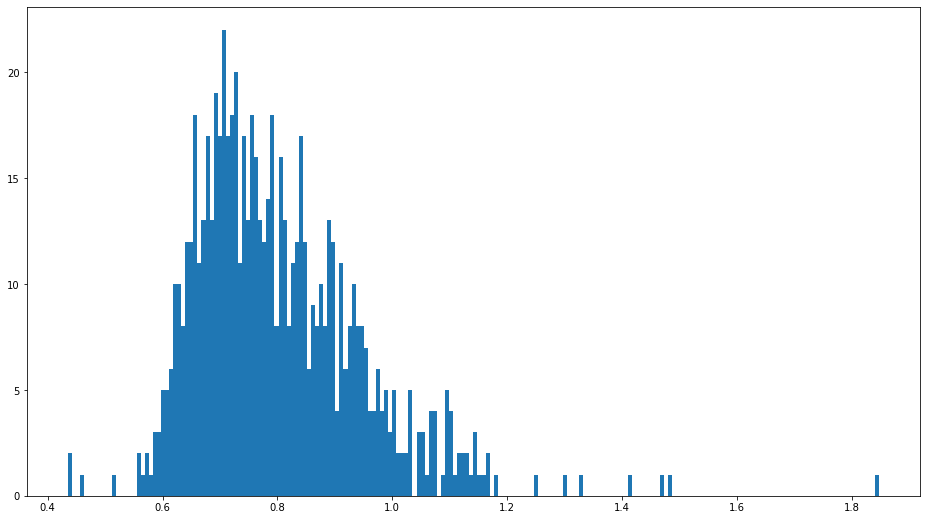

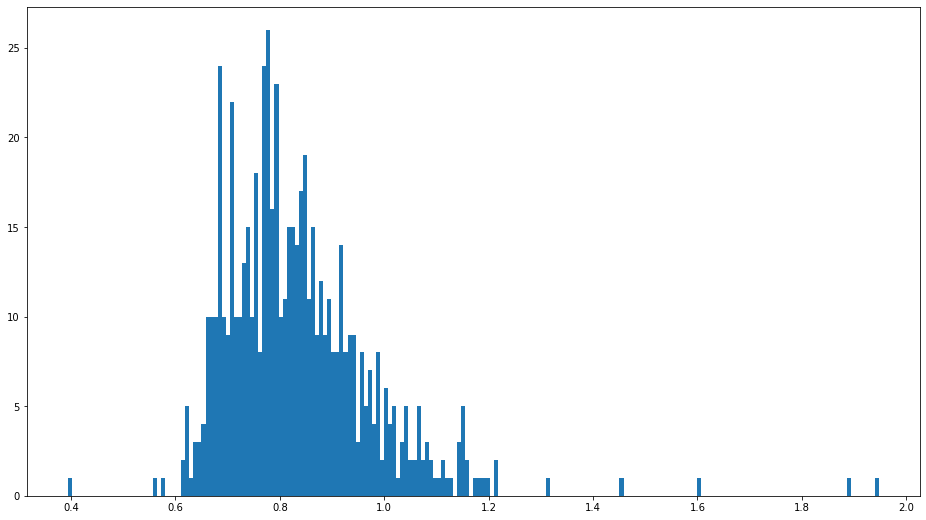

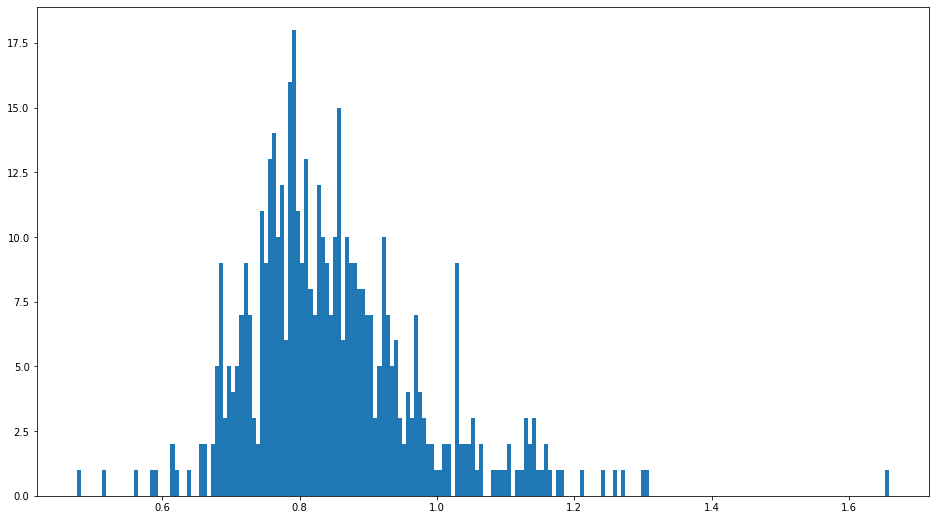

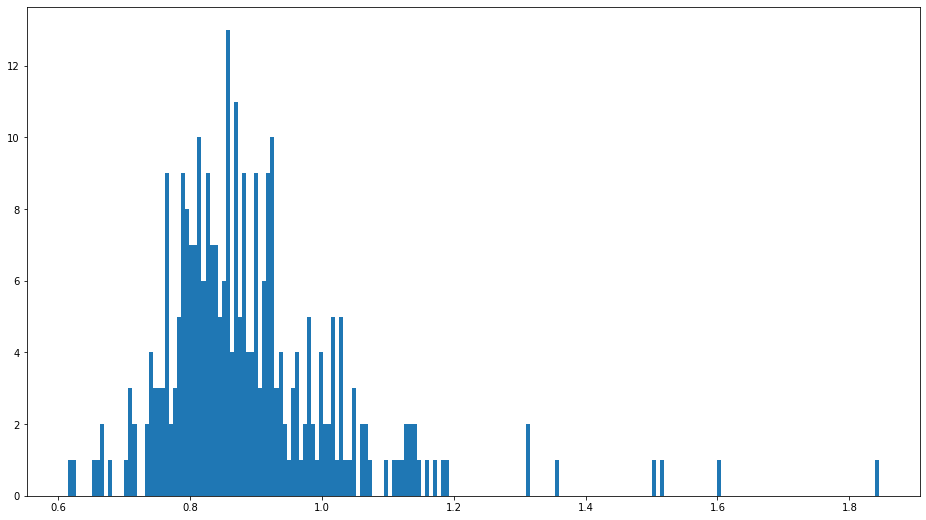

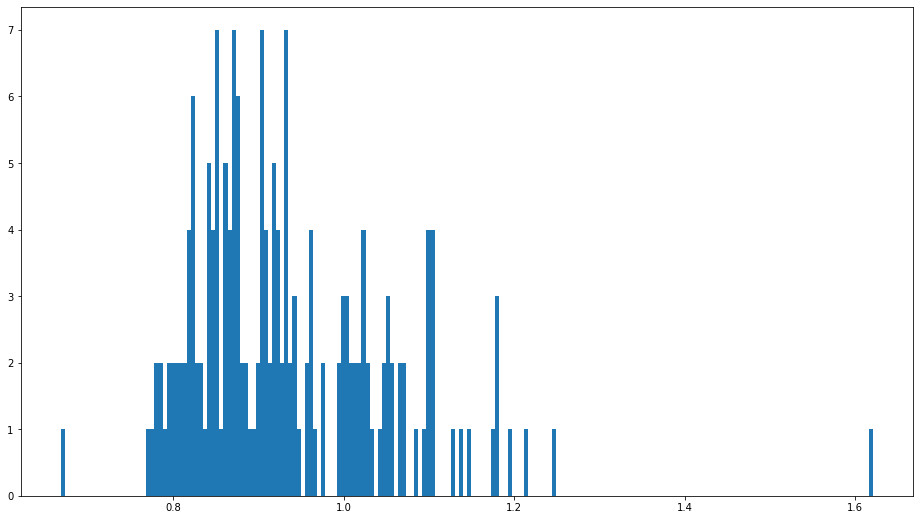

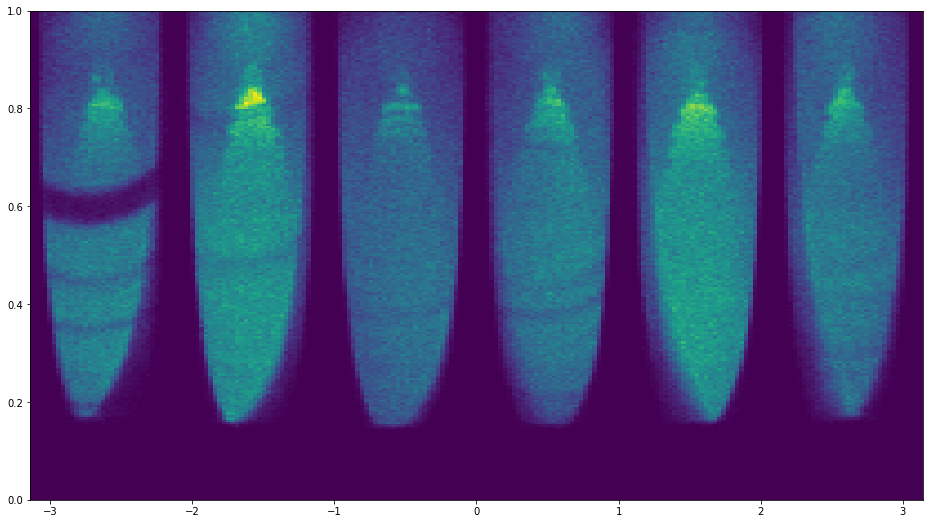

In [14]:
sf = SliceFitter(data, x_name="phi", y_name="theta", x_range=(-np.pi, np.pi), y_range=(0, 1.0))
sf.fit_slices()
sf.plot_2d()